In [1]:
# credit to https://gym.openai.com/evaluations/eval_EIcM1ZBnQW2LBaFN6FY65g/

import random
import gym
import math
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
%matplotlib inline
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import display

In [3]:
# alpha, alpha_decay: params of the adam optimizer of the NN (DQN)
# batch size: used for training the DQN (experience replay)
# n_episodes: how long to train for

# gamma: discount factor of future actions based on randomness
# here there's no randomness

# epsilon, min and decay control what % of the time the model tries new things vs uses experience over time
# ideally first the model tries new things then it learns and just uses experience.. 

class DQNCartPoleSolver():
    def __init__(self, n_episodes=1000, n_win_ticks=195, max_env_steps=None, gamma=1.0, epsilon=1.0, 
         epsilon_min=0.01, epsilon_log_decay=0.995, alpha=0.01, alpha_decay=0.01, 
         batch_size=64, monitor=False, quiet=False):
        
        self.memory = deque(maxlen=100000)
        self.env = gym.make('CartPole-v0')
        if monitor: self.env = gym.wrappers.Monitor(self.env, '../data/cartpole-1', force=True)
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_log_decay
        self.alpha = alpha
        self.alpha_decay = alpha_decay
        self.n_episodes = n_episodes
        self.n_win_ticks = n_win_ticks
        self.batch_size = batch_size
        self.quiet = quiet
        if max_env_steps is not None: self.env._max_episode_steps = max_env_steps

        # Init model
        self.model = Sequential()
        # the model takes four inputs as the state (cart position, velocity, stick angle, velocity at tip)
        # https://github.com/openai/gym/wiki/CartPole-v0
        self.model.add(Dense(24, input_dim=4, activation='tanh'))
        self.model.add(Dense(48, activation='tanh'))
        # model outputs two numbers - cumulative rewards for two available actions 
        self.model.add(Dense(2, activation='linear'))
        self.model.compile(loss='mse', optimizer=Adam(lr=self.alpha, decay=self.alpha_decay))

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
    # return a random action if epsilon is high and a model prediction if epsilon is low.. 
    # our model predicts scores of all available actions (two) based on a state...
    def choose_action(self, state, epsilon):
        return self.env.action_space.sample() if (np.random.random() <= epsilon) else np.argmax(self.model.predict(state))

    # epsilon gradually declines over time until the min
    def get_epsilon(self, t):
        return max(self.epsilon_min, min(self.epsilon, 1.0 - math.log10((t + 1) * self.epsilon_decay)))

    def preprocess_state(self, state):
        return np.reshape(state, [1, 4])

    def replay(self, batch_size):
        x_batch, y_batch = [], []
        
        # use just the batch size for training
        minibatch = random.sample(
            self.memory, min(len(self.memory), batch_size))
        
        # training follows the recursive Bellman equation..
        for state, action, reward, next_state, done in minibatch:
            y_target = self.model.predict(state)
            # should produce two numbers, scores for two actions.. 
            # action is 1 or 0
            y_target[0][action] = reward if done else reward + self.gamma * np.max(self.model.predict(next_state)[0])
            x_batch.append(state[0])
            y_batch.append(y_target[0])
        
        self.model.fit(np.array(x_batch), np.array(y_batch), batch_size=len(x_batch), verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def run(self):
        scores = deque(maxlen=100)

        for e in range(self.n_episodes):
            state = self.preprocess_state(self.env.reset())
            done = False
            i = 0
            
            # play the game until lose
            while not done:
                # action is 0 or 1
                action = self.choose_action(state, self.get_epsilon(e))
                next_state, reward, done, _ = self.env.step(action)
                next_state = self.preprocess_state(next_state)
                self.remember(state, action, reward, next_state, done)
                state = next_state
                i += 1

            scores.append(i)
            mean_score = np.mean(scores)
            if mean_score >= self.n_win_ticks and e >= 100:
                if not self.quiet: print('Ran {} episodes. Solved after {} trials ✔'.format(e, e - 100))
                return e - 100
            if e % 100 == 0 and not self.quiet:
                print('[Episode {}] - Mean survival time over last 100 episodes was {} ticks.'.format(e, mean_score))

            # training happens here.
            self.replay(self.batch_size)
        
        if not self.quiet: print('Did not solve after {} episodes 😞'.format(e))
        return e

In [4]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))

In [5]:
agent = DQNCartPoleSolver(n_episodes=1000, n_win_ticks=195)

I0715 00:45:43.916476 139826722694912 registration.py:117] Making new env: CartPole-v0
/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
W0715 00:45:43.929859 139826722694912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0715 00:45:43.952091 139826722694912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0715 00:45:43.956732 139826722694912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.unifo

In [6]:
# train
agent.run()

W0715 00:45:44.061162 139826722694912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2741: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0715 00:45:44.065365 139826722694912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



[Episode 0] - Mean survival time over last 100 episodes was 15.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 10.84 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 11.69 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 13.51 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 20.32 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 32.27 ticks.
[Episode 600] - Mean survival time over last 100 episodes was 53.39 ticks.
[Episode 700] - Mean survival time over last 100 episodes was 65.13 ticks.
[Episode 800] - Mean survival time over last 100 episodes was 70.89 ticks.
[Episode 900] - Mean survival time over last 100 episodes was 88.03 ticks.
Did not solve after 999 episodes 😞


999

### This shows 1000 step is not sufficient to have a good resolvable trainning model


In [7]:
env = gym.make('CartPole-v0')
observation = env.reset()


I0715 00:46:50.235120 139826722694912 registration.py:117] Making new env: CartPole-v0


In [8]:
cum_reward = 0
frames = []
for t in range(100):
    # Render into buffer. 
    # You will still see the window.
    frames.append(env.render(mode = 'rgb_array'))
#    action = env.action_space.sample()
    # no epsilon, just follow the best strategy
    action = agent.choose_action(agent.preprocess_state(observation), 0)
    observation, reward, done, info = env.step(action)
    print (action, observation, reward, done, info)
#    if done:
#        print("Episode finished after {} timesteps".format(t+1))
#        break
env.render(close=True)

0 [ 0.01477118 -0.1949739  -0.04821164  0.3092603 ] 1.0 False {}
0 [ 0.01087171 -0.38937696 -0.04202643  0.58635732] 1.0 False {}
0 [ 0.00308417 -0.58388587 -0.03029929  0.86551093] 1.0 False {}
0 [-0.00859355 -0.77858261 -0.01298907  1.14851538] 1.0 False {}
0 [-0.0241652  -0.97353261  0.00998124  1.43709703] 1.0 False {}
1 [-0.04363586 -0.77853511  0.03872318  1.14754978] 1.0 False {}
1 [-0.05920656 -0.58393955  0.06167418  0.86725703] 1.0 False {}
0 [-0.07088535 -0.77984408  0.07901932  1.17867584] 1.0 False {}
1 [-0.08648223 -0.58583213  0.10259283  0.91177353] 1.0 False {}
1 [-0.09819887 -0.39223672  0.1208283   0.65301672] 1.0 False {}
1 [-0.10604361 -0.1989861   0.13388864  0.40069138] 1.0 False {}
1 [-0.11002333 -0.00599217  0.14190247  0.1530371 ] 1.0 False {}
0 [-0.11014317 -0.20283069  0.14496321  0.48690662] 1.0 False {}
1 [-0.11419979 -0.01001971  0.15470134  0.24319374] 1.0 False {}
1 [-0.11440018  0.1825931   0.15956521  0.00302591] 1.0 False {}
0 [-0.11074832 -0.0144146


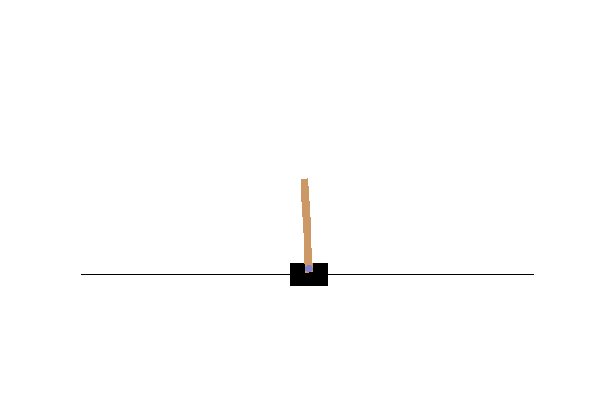
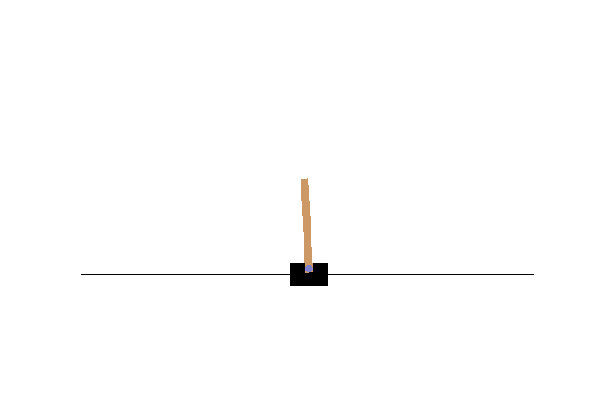
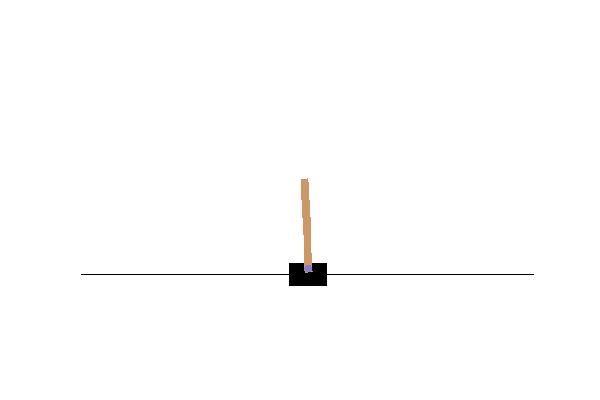
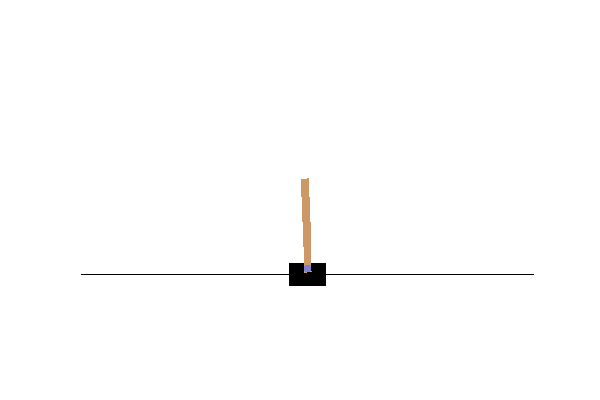
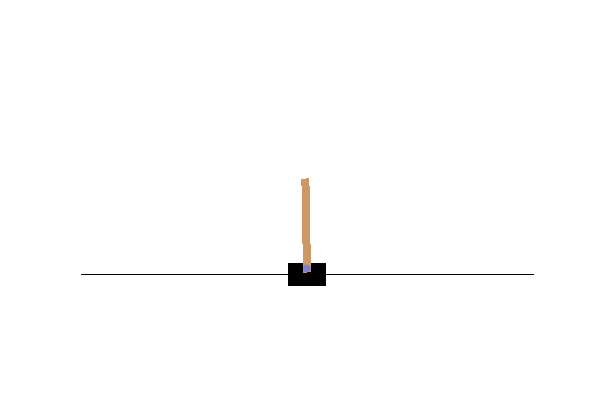
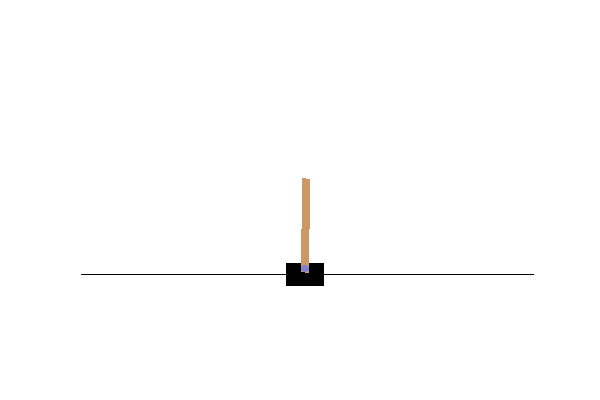
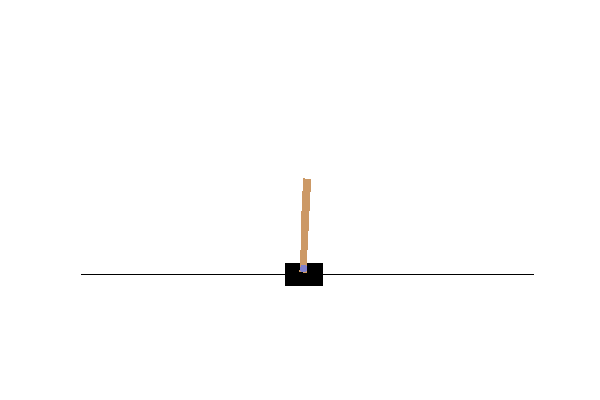
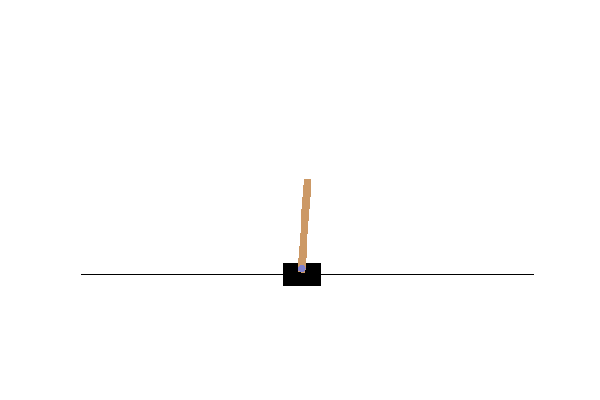
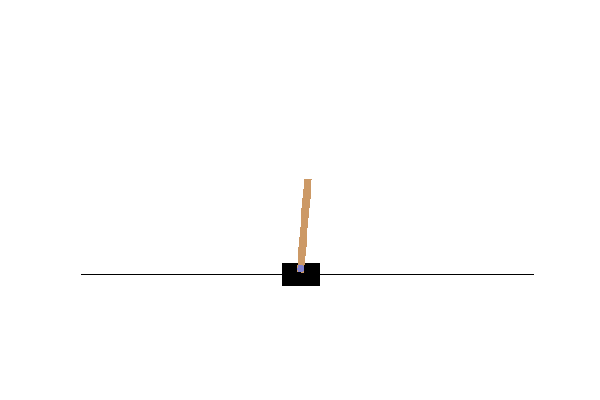
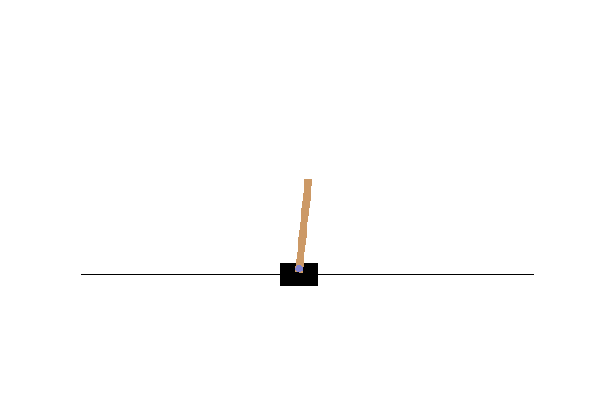
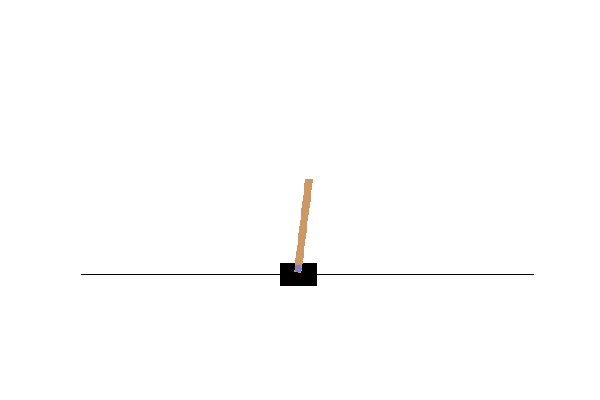
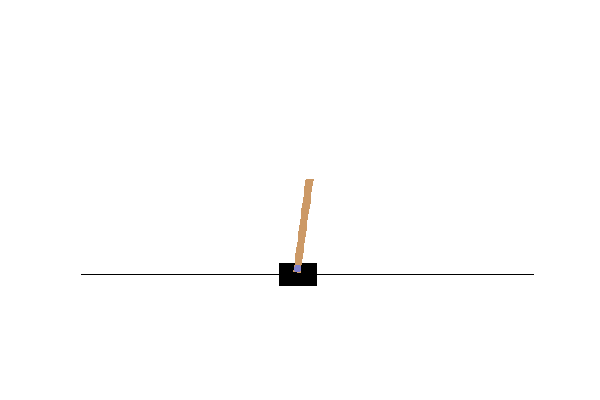
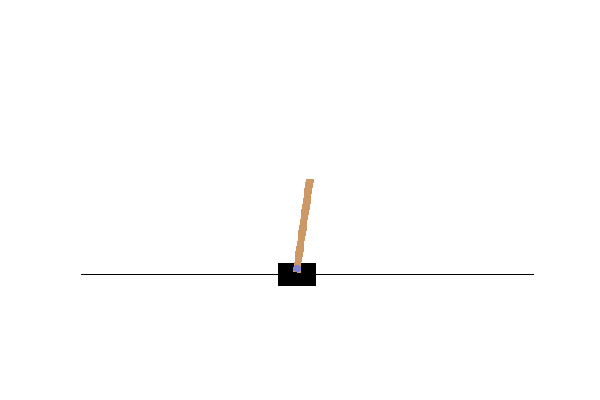
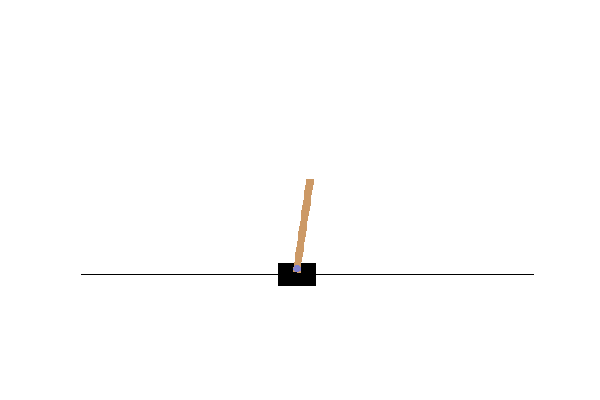
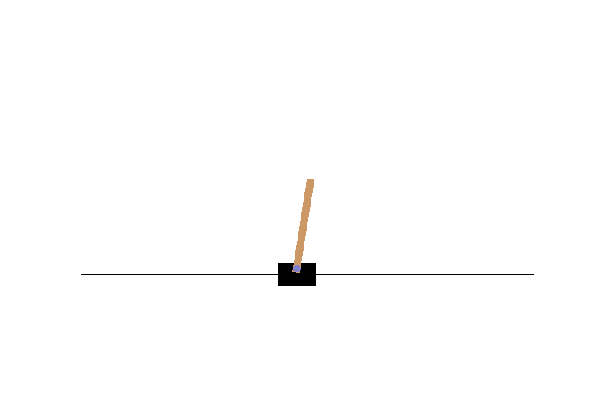
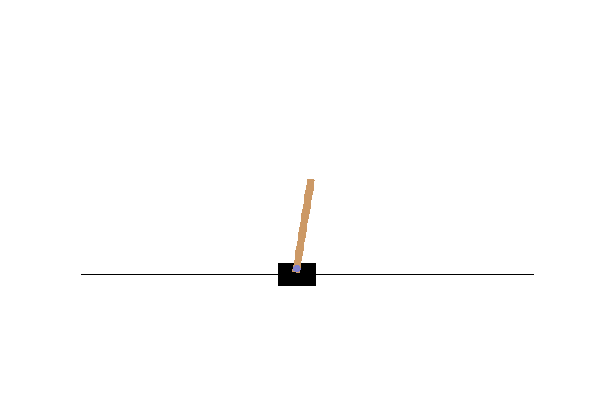
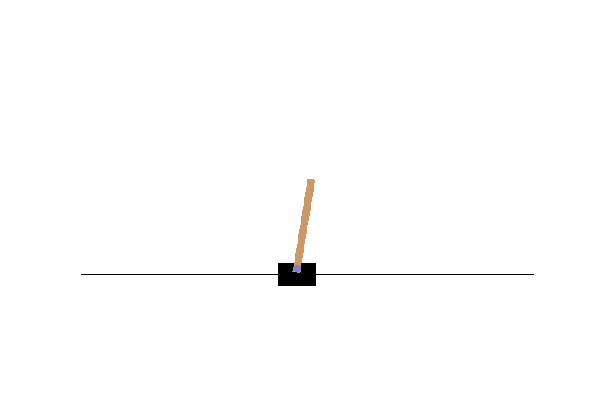
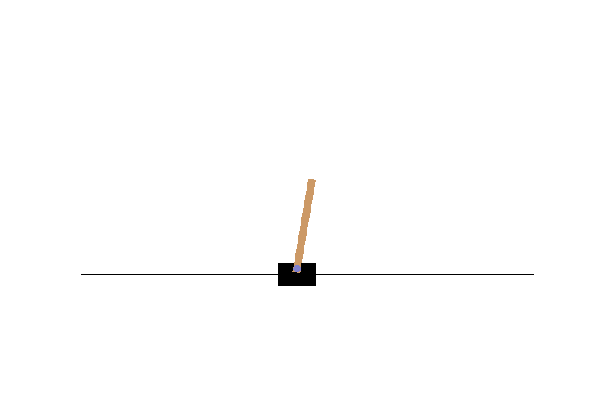
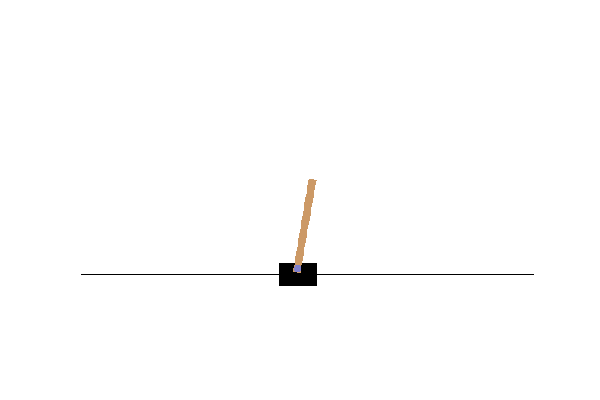
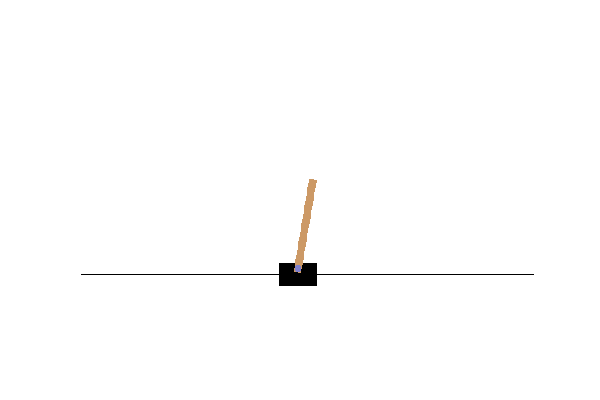
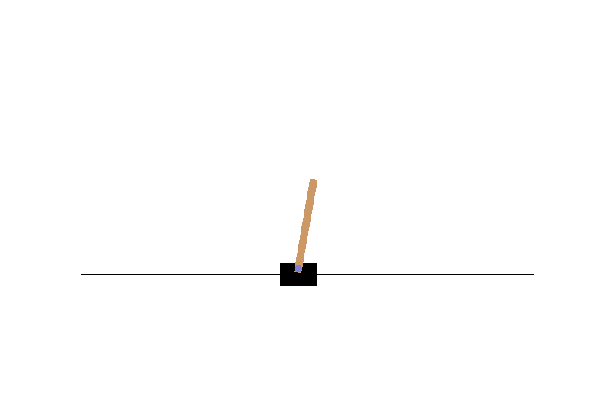
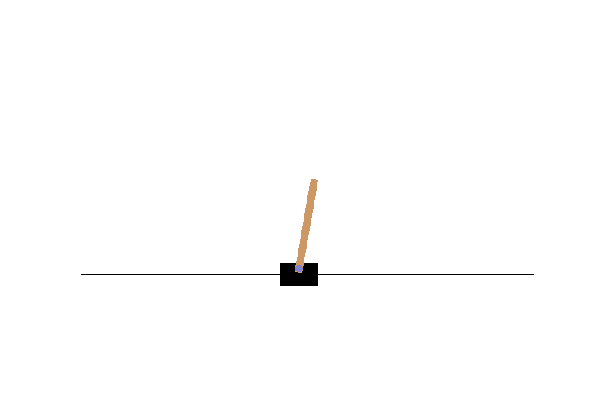
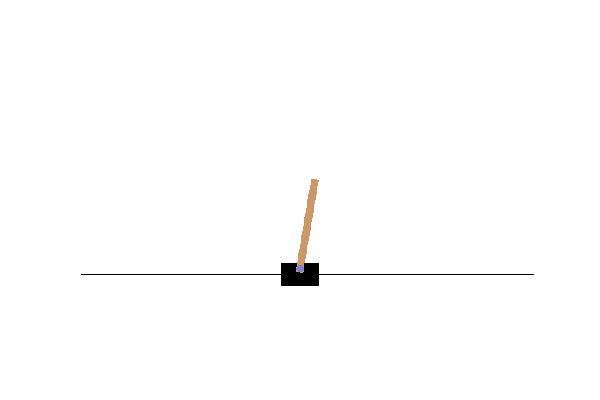
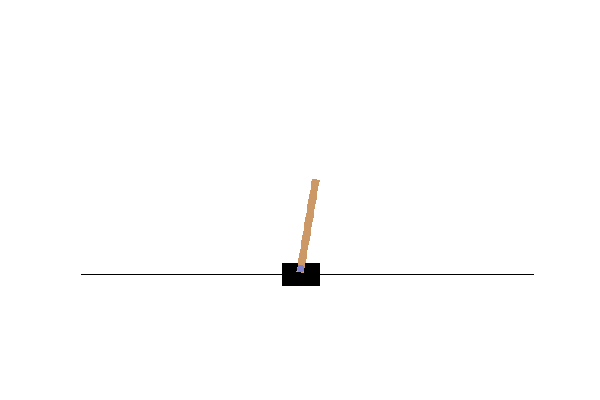
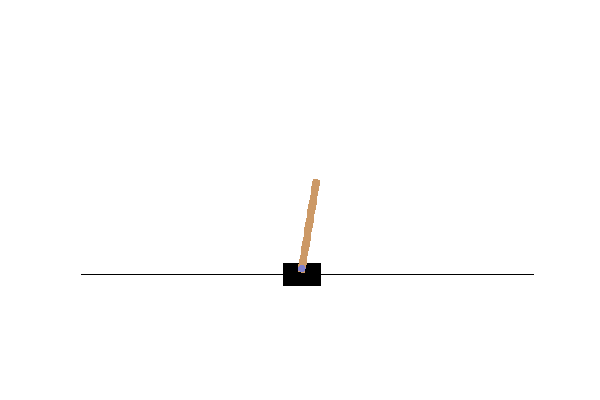
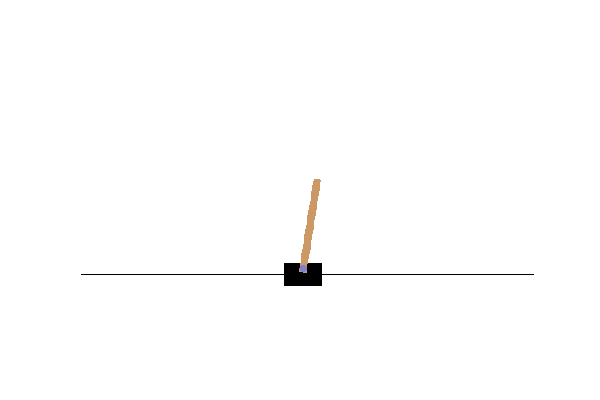
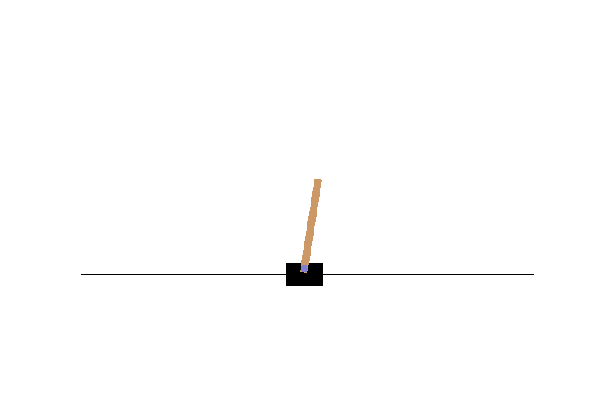
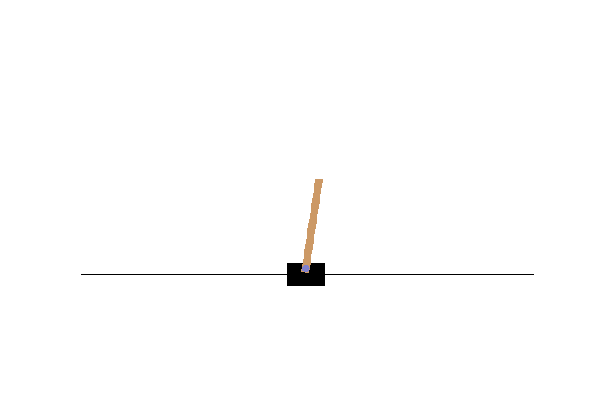
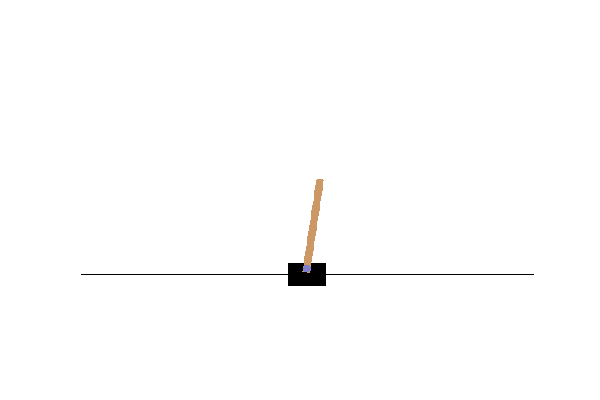
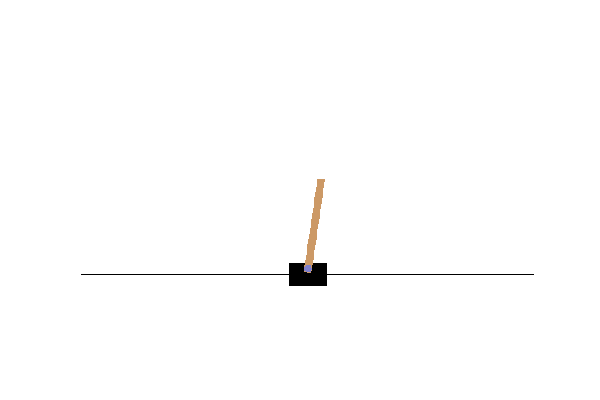
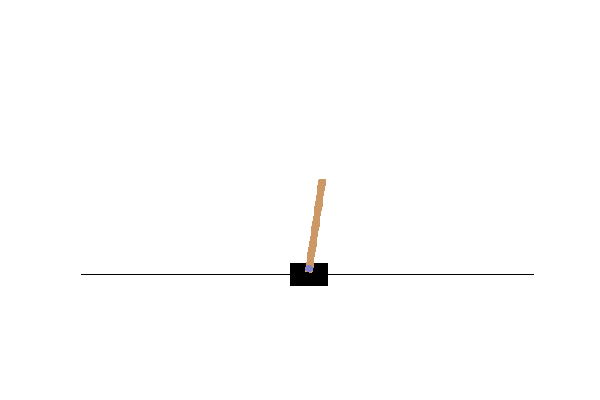
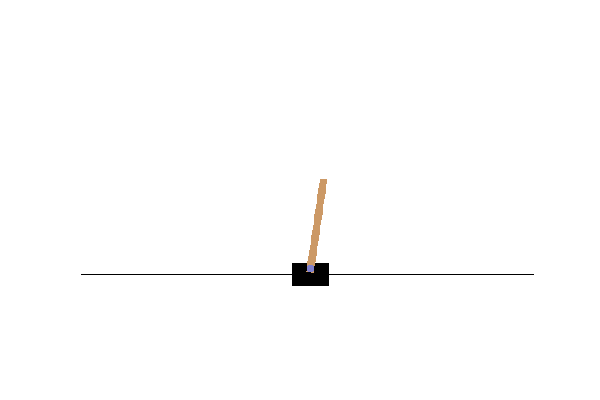
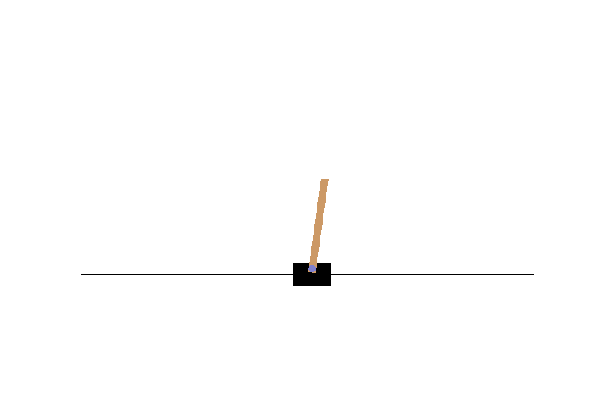
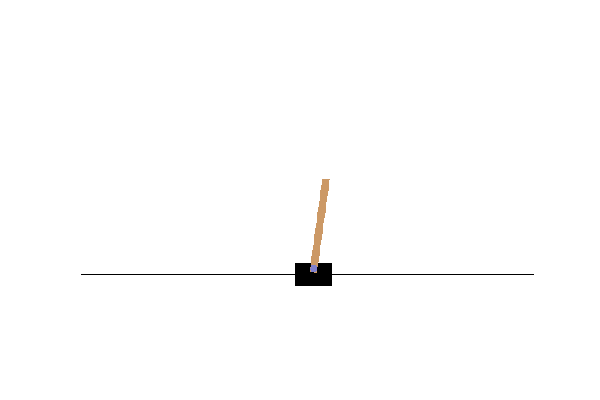
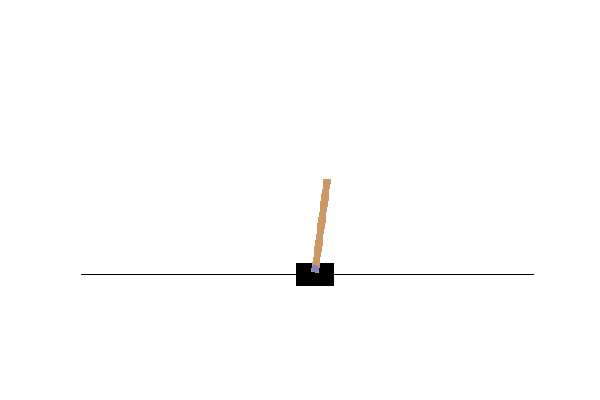
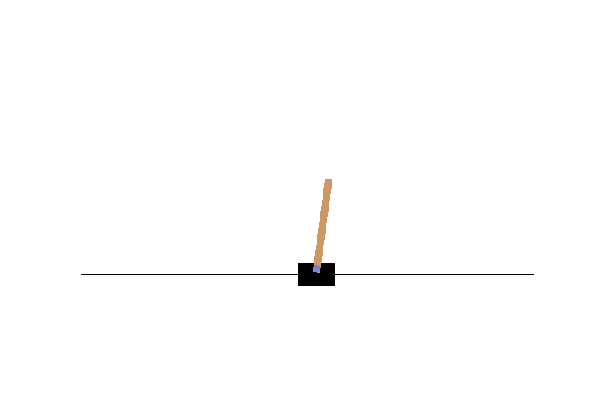
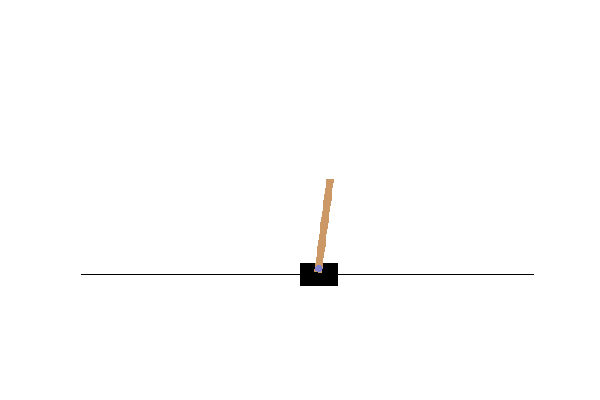
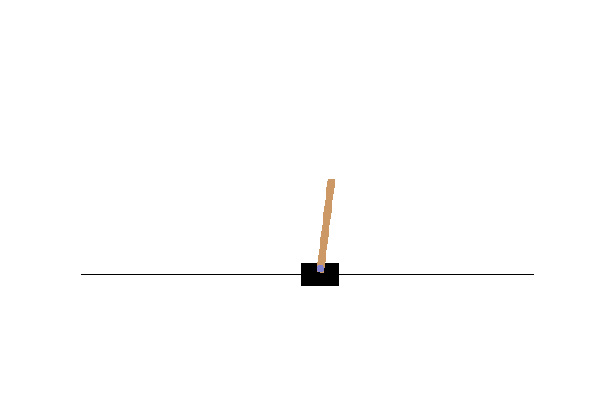
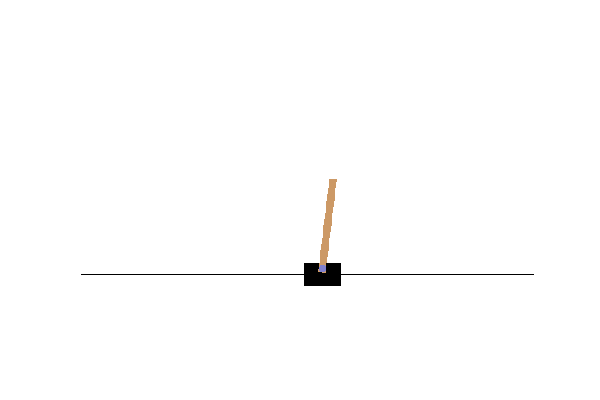
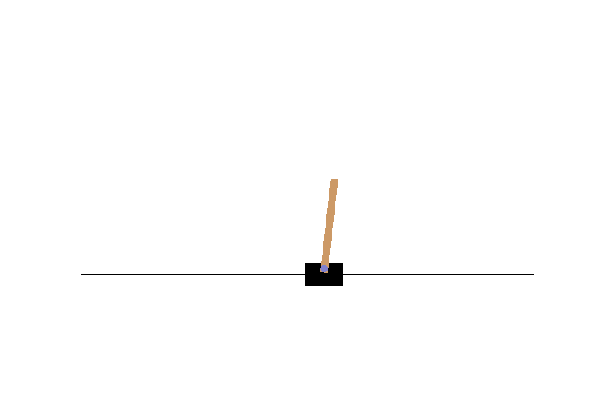
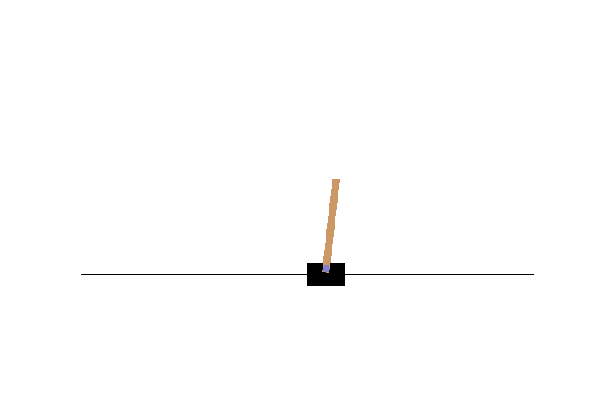
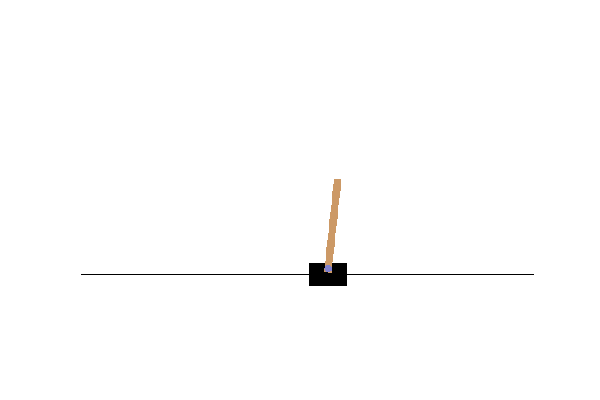
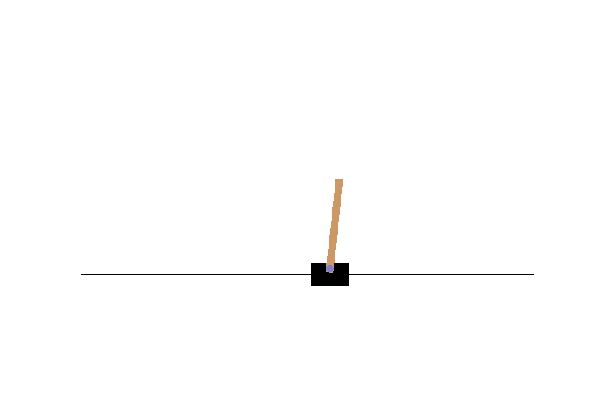
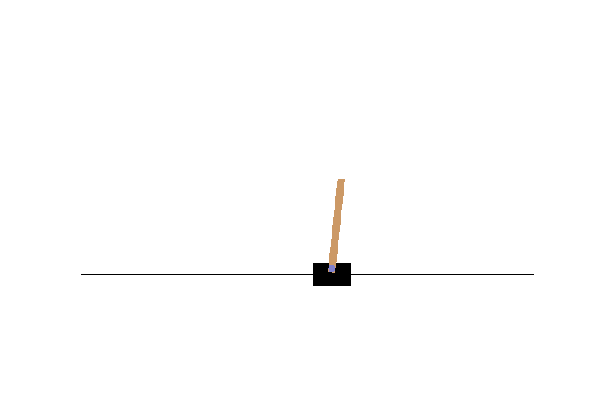
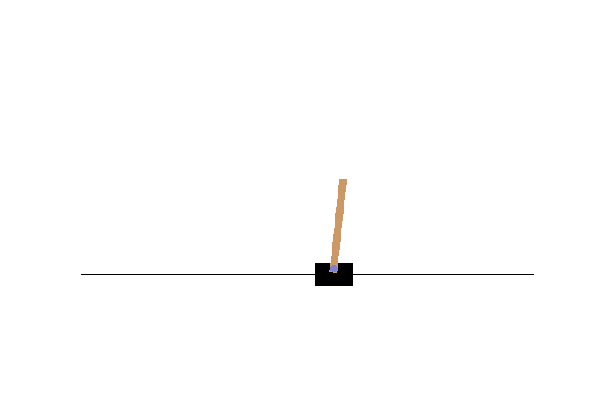
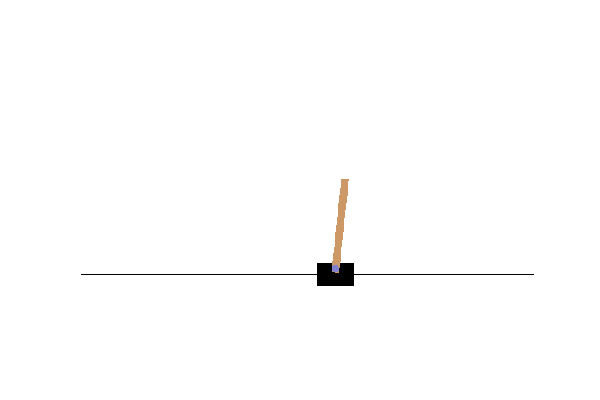
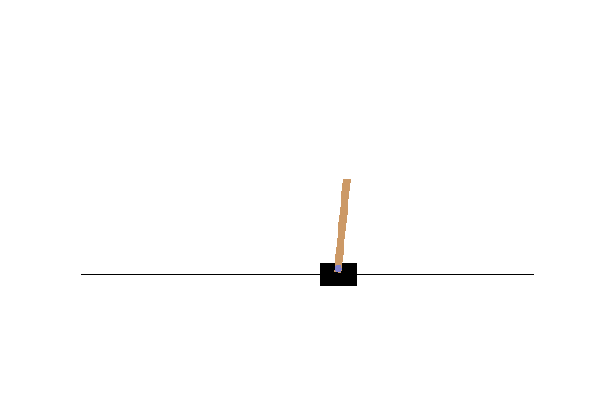
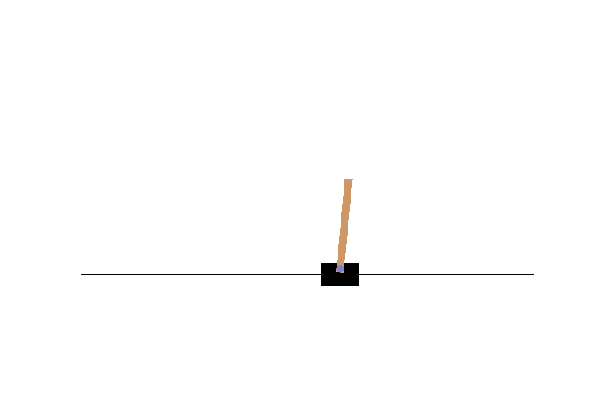
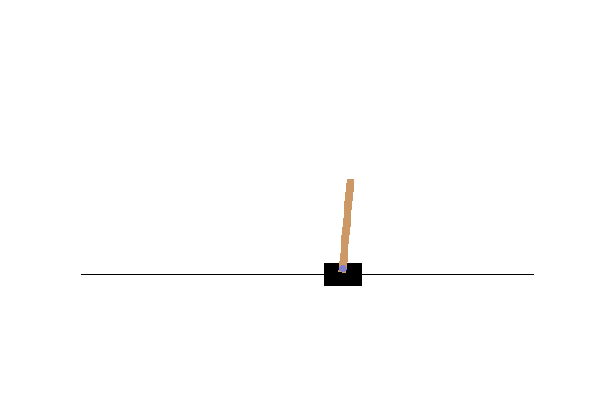
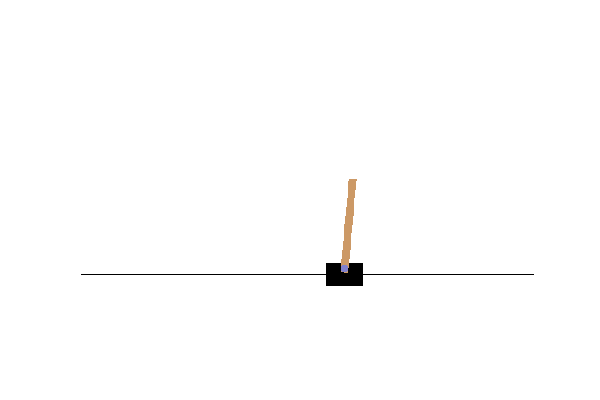
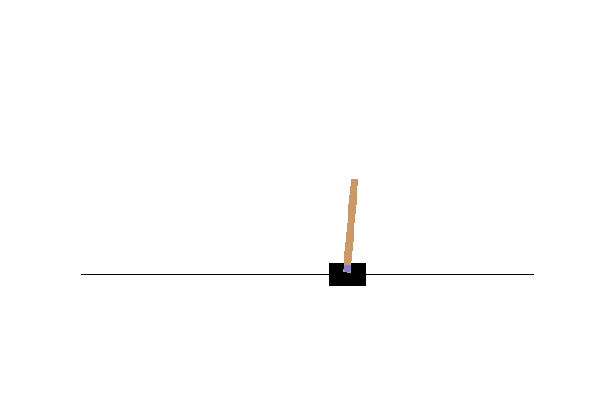
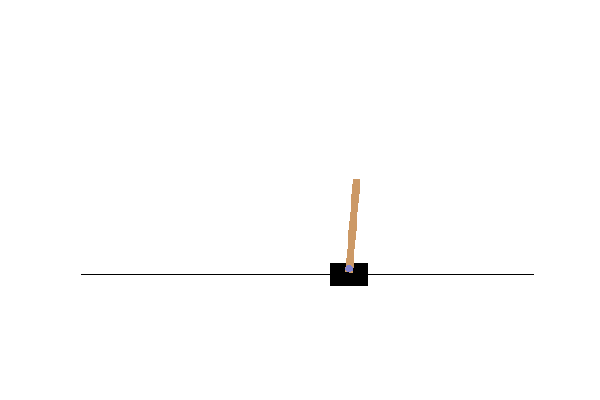
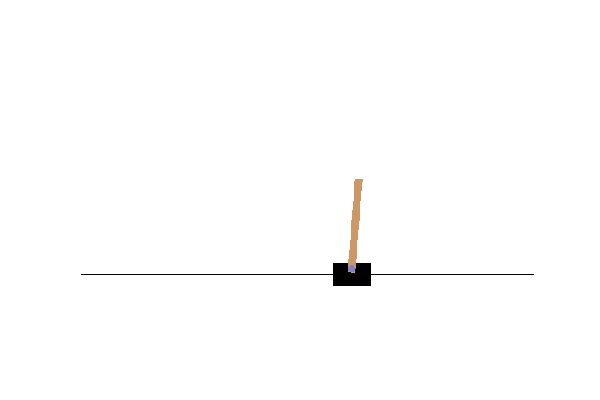
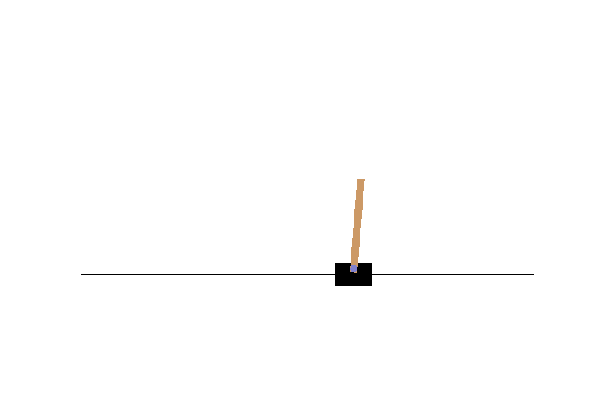
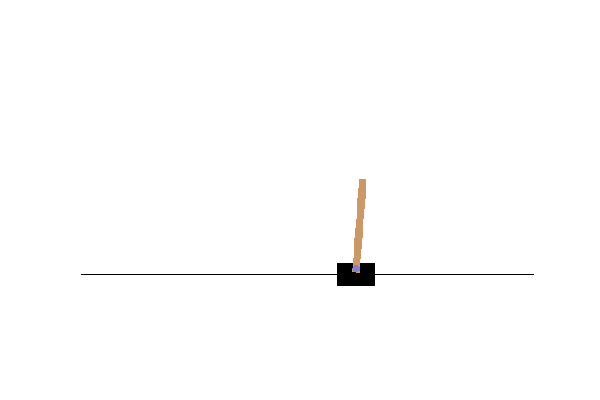
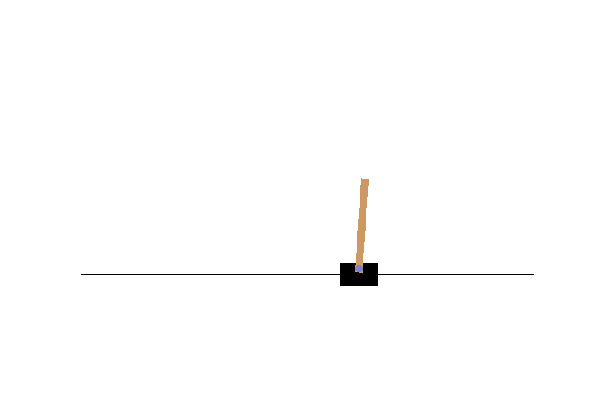
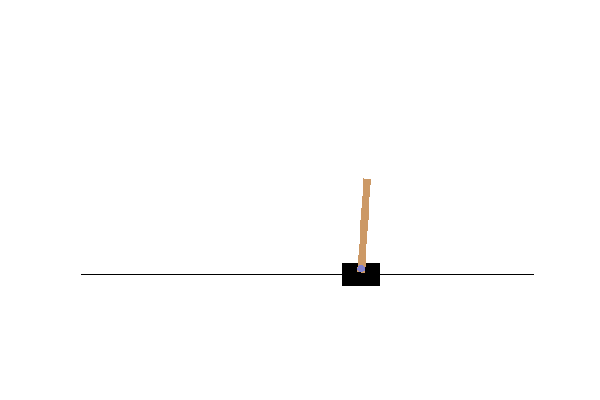
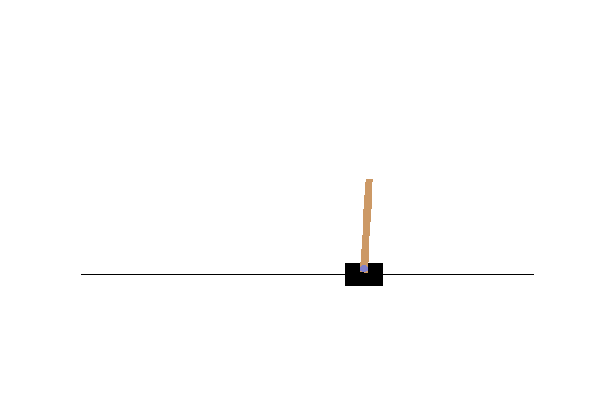
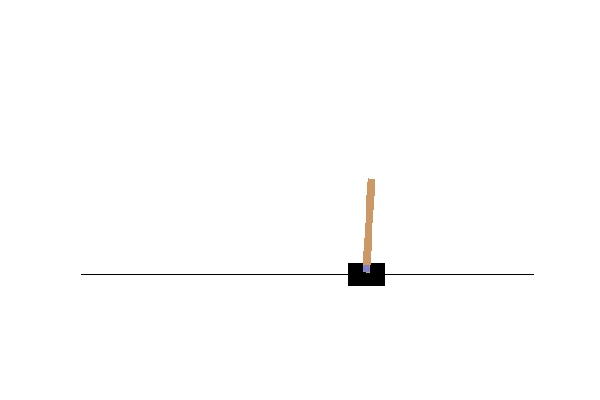
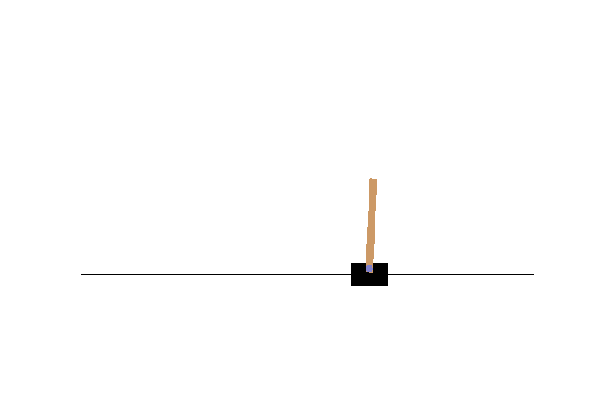
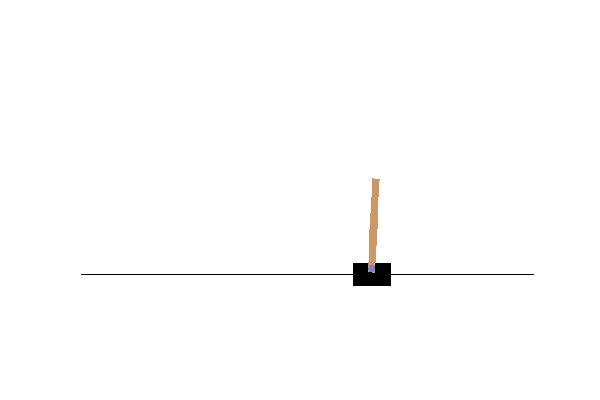
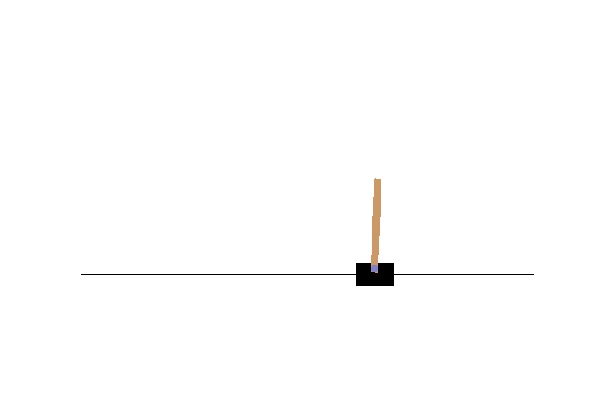
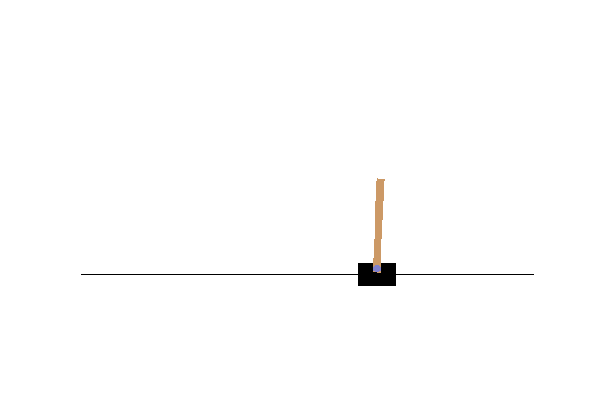
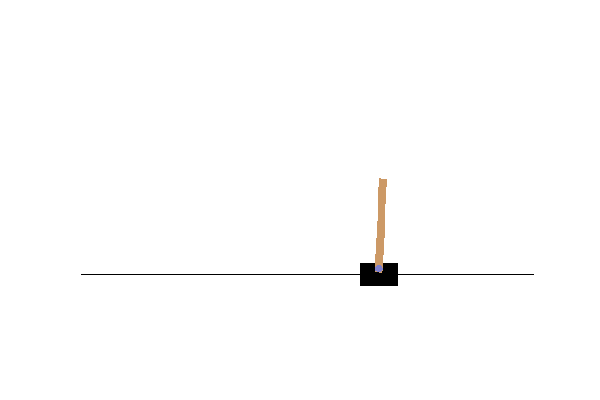
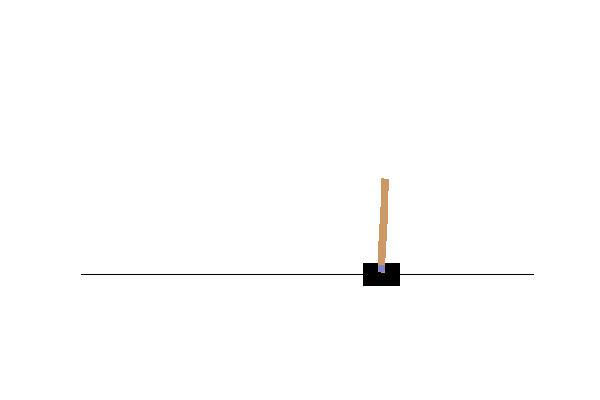
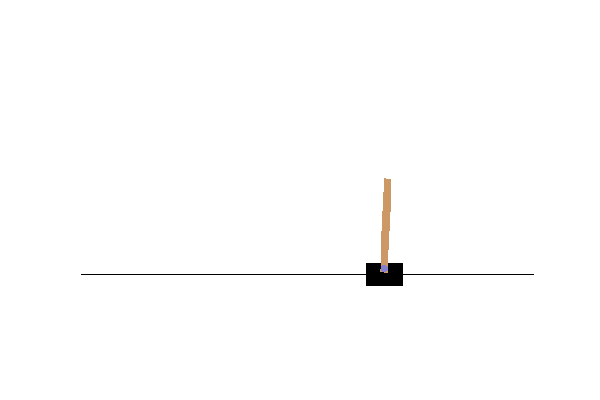
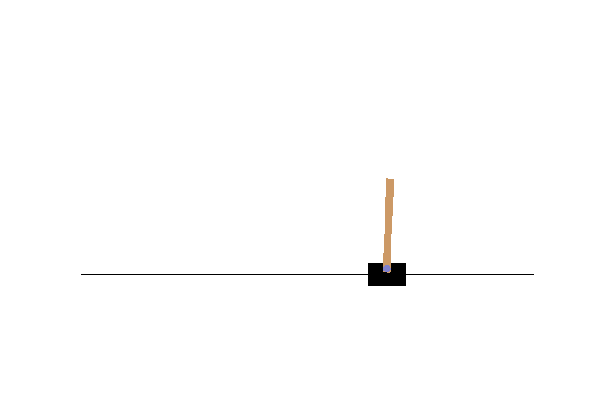
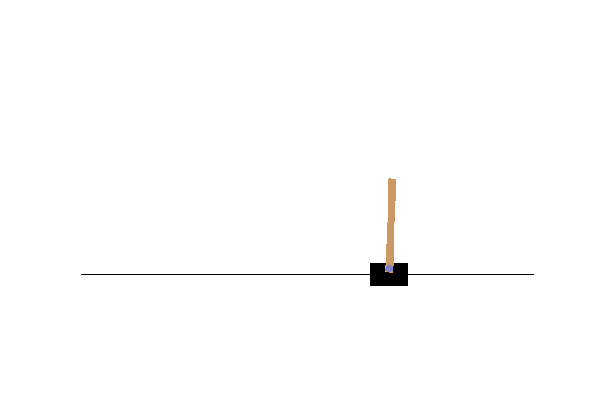
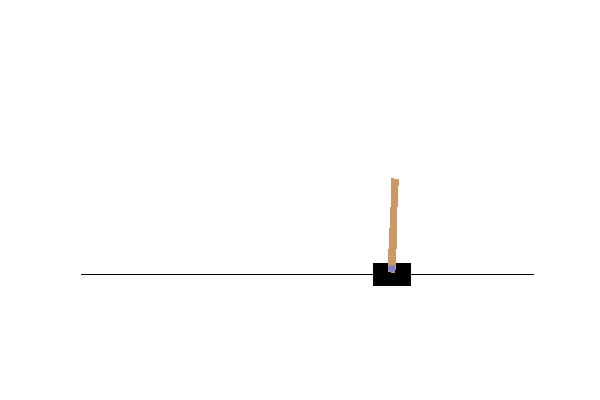
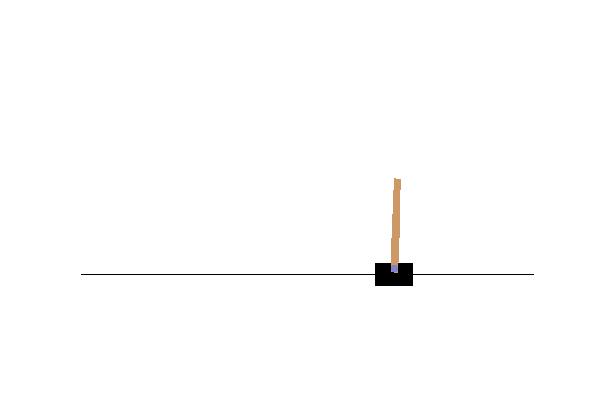
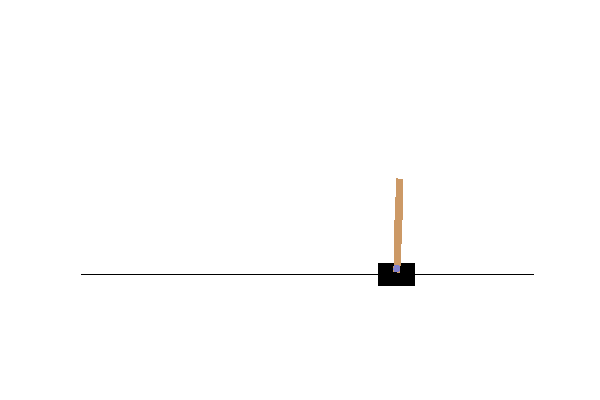
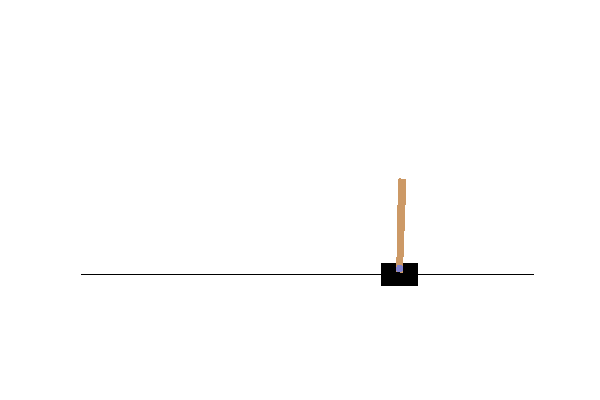
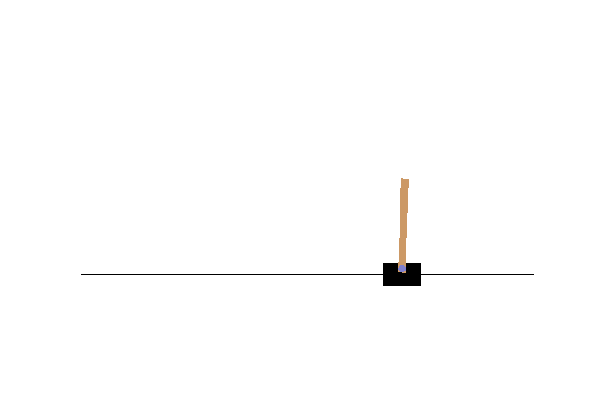
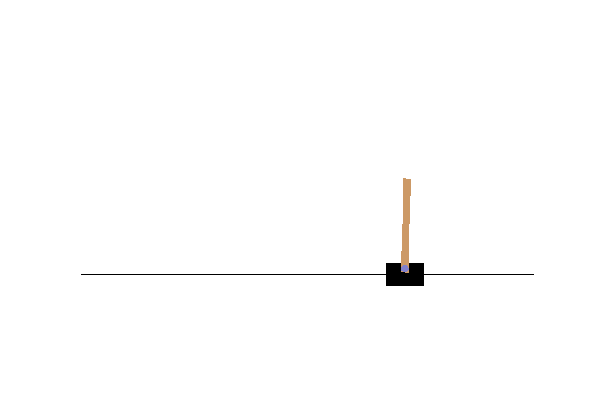
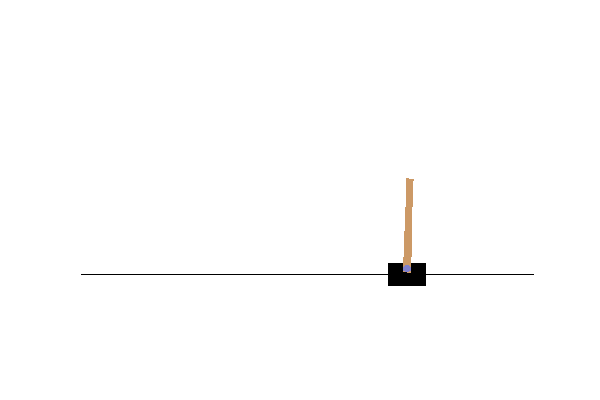
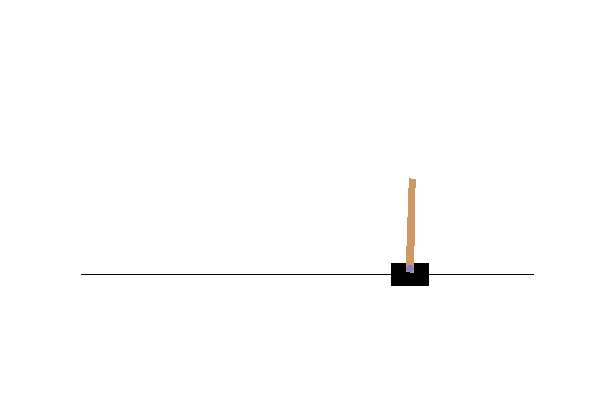
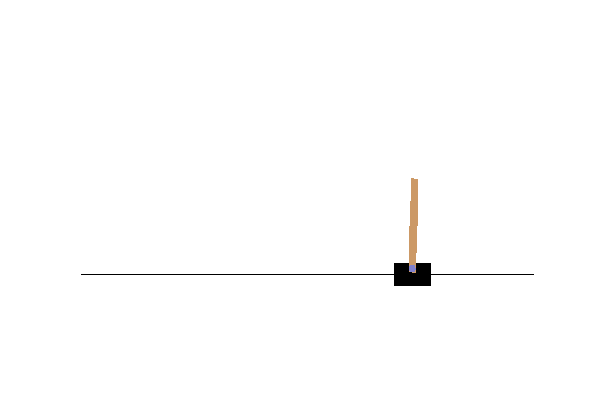
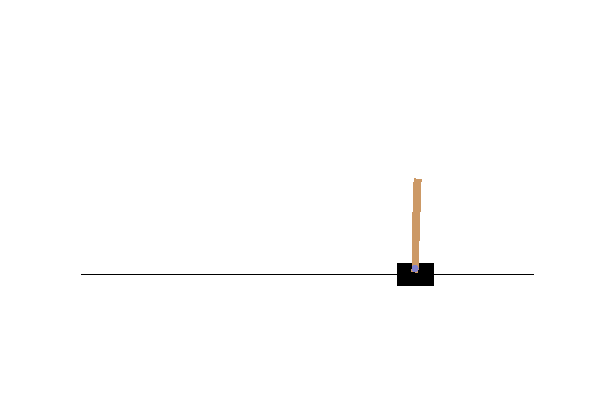
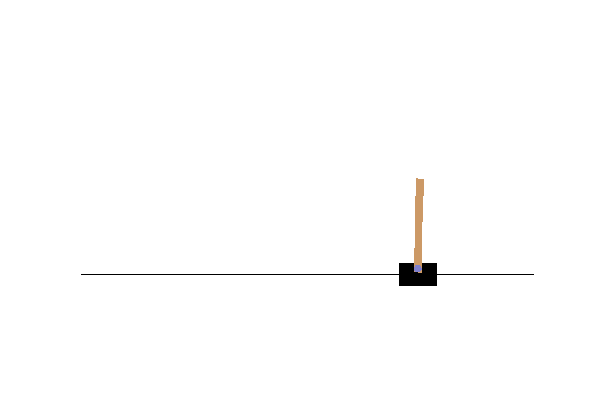
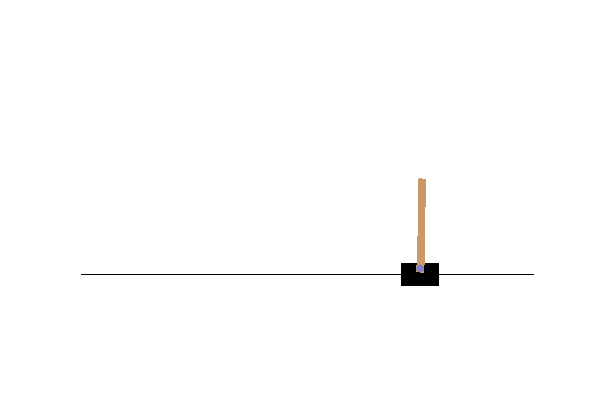
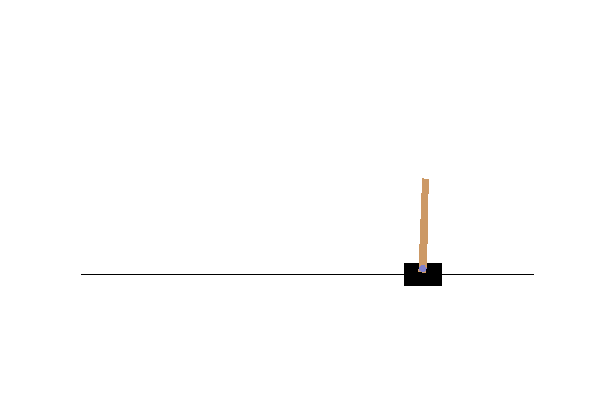
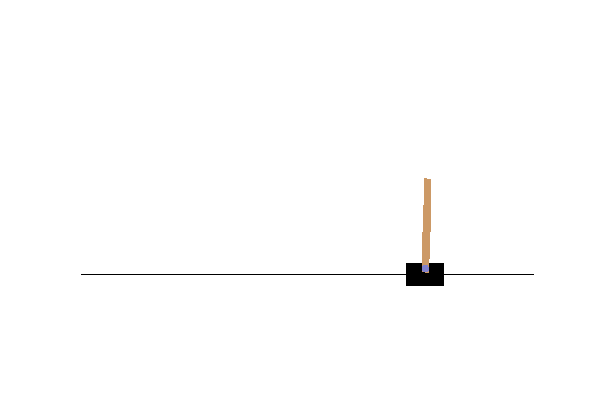
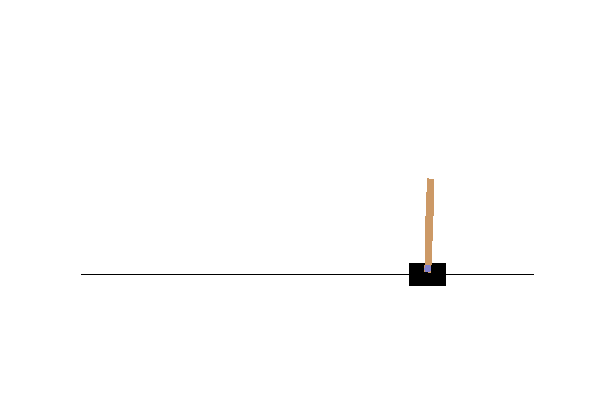
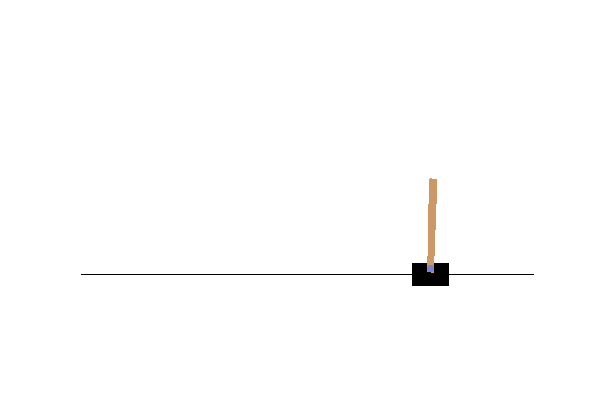
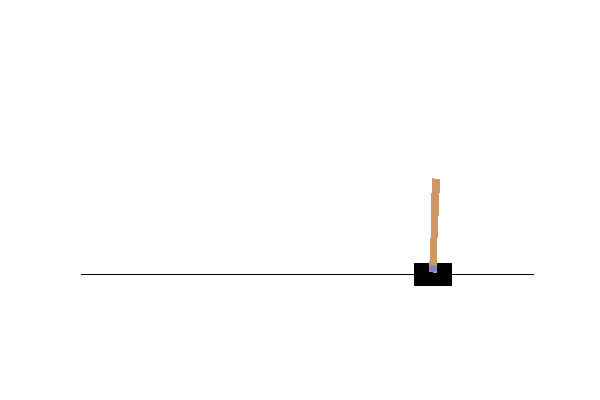
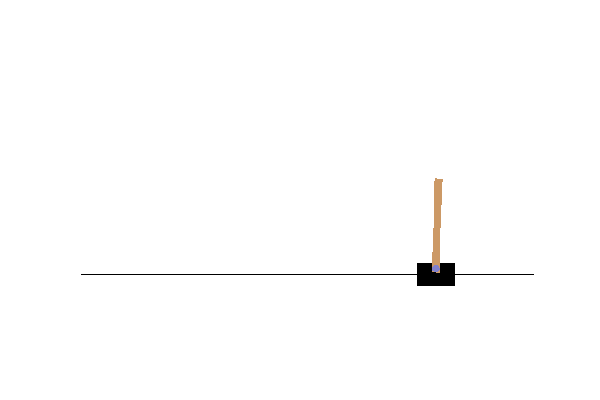
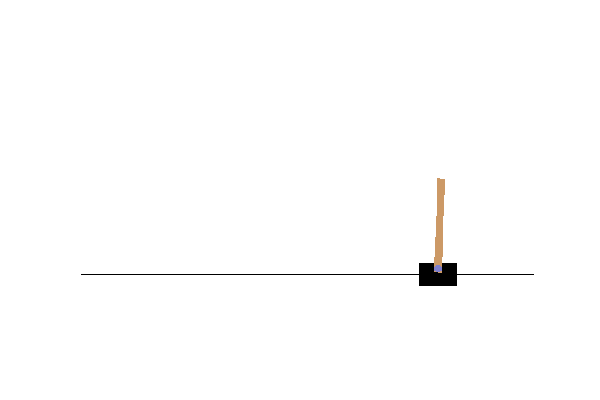
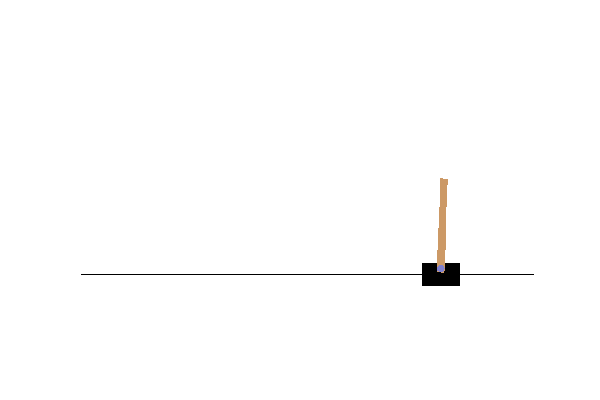
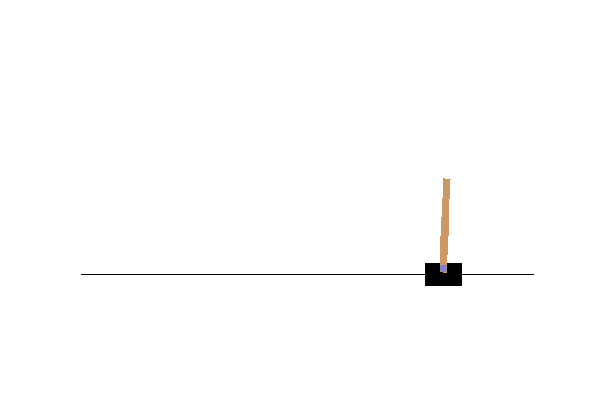
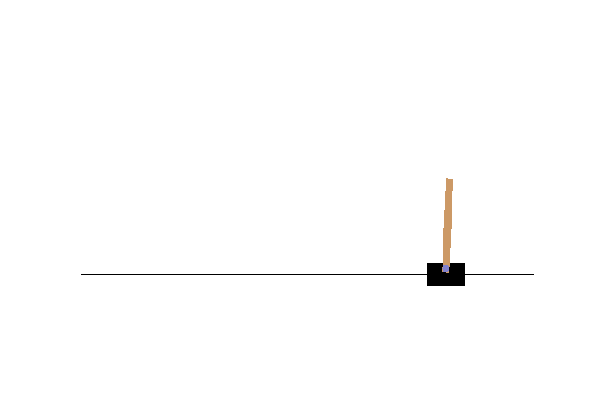
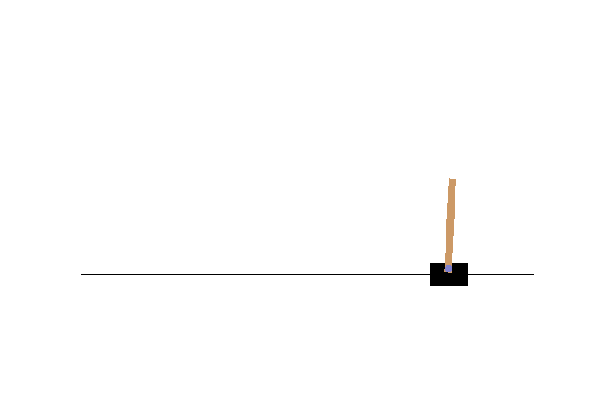
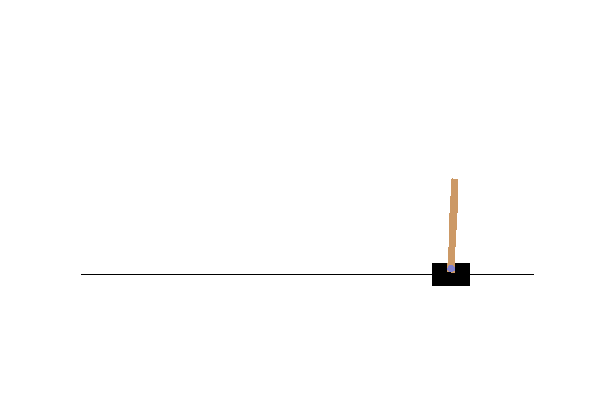
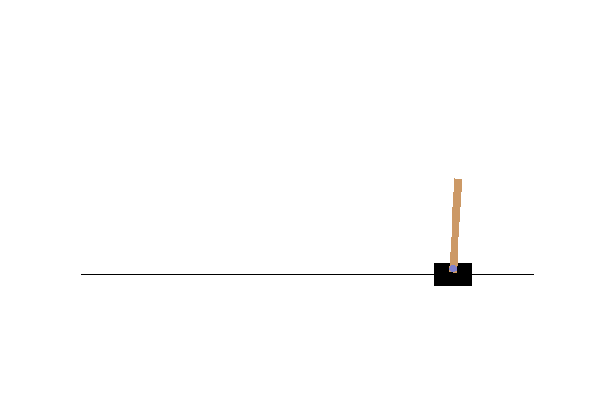
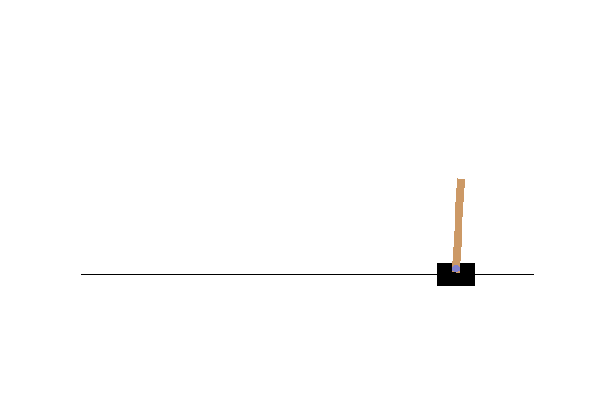
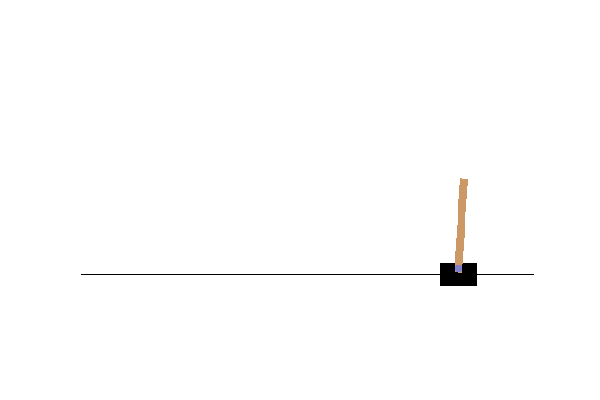
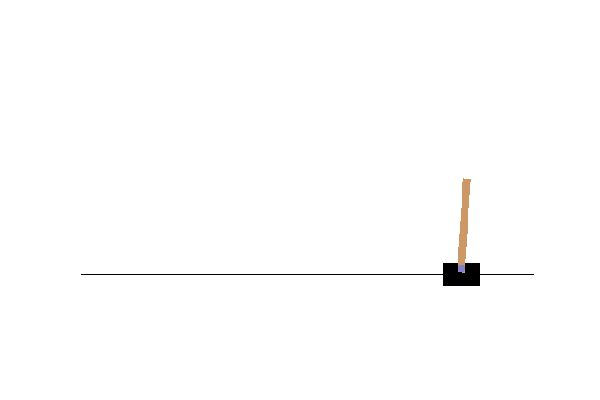
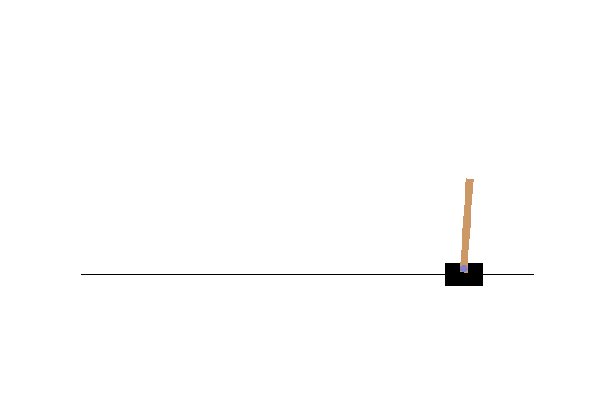
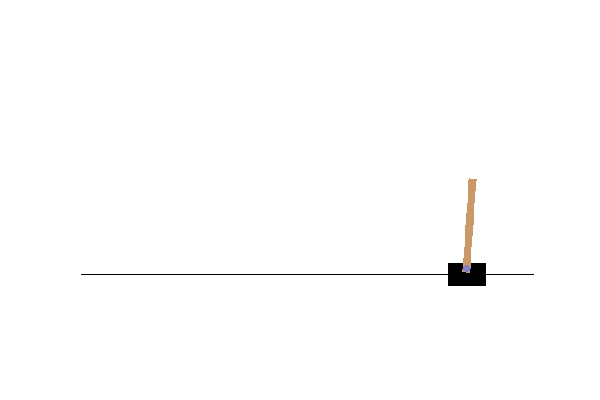
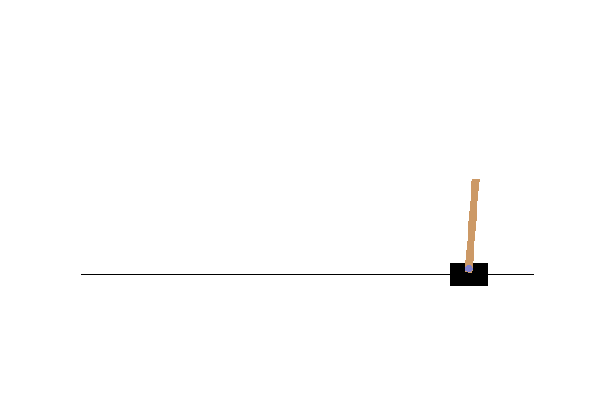
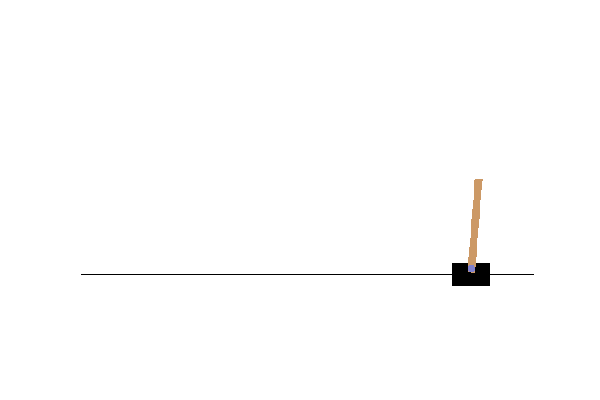

In [9]:
display_frames_as_gif(frames)

In [15]:
# alpha, alpha_decay: params of the adam optimizer of the NN (DQN)
# batch size: used for training the DQN (experience replay)
# n_episodes: how long to train for

# gamma: discount factor of future actions based on randomness
# here there's no randomness

# epsilon, min and decay control what % of the time the model tries new things vs uses experience over time
# ideally first the model tries new things then it learns and just uses experience.. 

class DQNCartPoleSolver2():
    def __init__(self, n_episodes=1000, n_win_ticks=195, max_env_steps=None, gamma=1.0, epsilon=1.0, 
         epsilon_min=0.05, epsilon_log_decay=0.995, alpha=0.01, alpha_decay=0.01, 
         batch_size=64, monitor=False, quiet=False):
        
        self.memory = deque(maxlen=100000)
        self.env = gym.make('CartPole-v0')
        if monitor: self.env = gym.wrappers.Monitor(self.env, '../data/cartpole-1', force=True)
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_log_decay
        self.alpha = alpha
        self.alpha_decay = alpha_decay
        self.n_episodes = n_episodes
        self.n_win_ticks = n_win_ticks
        self.batch_size = batch_size
        self.quiet = quiet
        if max_env_steps is not None: self.env._max_episode_steps = max_env_steps

        # Init model
        self.model = Sequential()
        # the model takes four inputs as the state (cart position, velocity, stick angle, velocity at tip)
        # https://github.com/openai/gym/wiki/CartPole-v0
        self.model.add(Dense(24, input_dim=4, activation='tanh'))
        self.model.add(Dense(48, activation='tanh'))
        # model outputs two numbers - cumulative rewards for two available actions 
        self.model.add(Dense(2, activation='linear'))
        self.model.compile(loss='mse', optimizer=Adam(lr=self.alpha, decay=self.alpha_decay))

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
    # return a random action if epsilon is high and a model prediction if epsilon is low.. 
    # our model predicts scores of all available actions (two) based on a state...
    def choose_action(self, state, epsilon):
        return self.env.action_space.sample() if (np.random.random() <= epsilon) else np.argmax(self.model.predict(state))

    # epsilon gradually declines over time until the min
    def get_epsilon(self, t):
        return max(self.epsilon_min, min(self.epsilon, 1.0 - math.log10((t + 1) * self.epsilon_decay)))

    def preprocess_state(self, state):
        return np.reshape(state, [1, 4])

    def replay(self, batch_size):
        x_batch, y_batch = [], []
        
        # use just the batch size for training
        minibatch = random.sample(
            self.memory, min(len(self.memory), batch_size))
        
        # training follows the recursive Bellman equation..
        for state, action, reward, next_state, done in minibatch:
            y_target = self.model.predict(state)
            # should produce two numbers, scores for two actions.. 
            # action is 1 or 0
            y_target[0][action] = reward if done else reward + self.gamma * np.max(self.model.predict(next_state)[0])
            x_batch.append(state[0])
            y_batch.append(y_target[0])
        
        self.model.fit(np.array(x_batch), np.array(y_batch), batch_size=len(x_batch), verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def run(self):
        scores = deque(maxlen=100)

        for e in range(self.n_episodes):
            state = self.preprocess_state(self.env.reset())
            done = False
            i = 0
            
            # play the game until lose
            while not done:
                # action is 0 or 1
                action = self.choose_action(state, self.get_epsilon(e))
                next_state, reward, done, _ = self.env.step(action)
                next_state = self.preprocess_state(next_state)
                self.remember(state, action, reward, next_state, done)
                state = next_state
                i += 1

            scores.append(i)
            mean_score = np.mean(scores)
            if mean_score >= self.n_win_ticks and e >= 100:
                if not self.quiet: print('Ran {} episodes. Solved after {} trials ✔'.format(e, e - 100))
                return e - 100
            if e % 100 == 0 and not self.quiet:
                print('[Episode {}] - Mean survival time over last 100 episodes was {} ticks.'.format(e, mean_score))

            # training happens here.
            self.replay(self.batch_size)
        
        if not self.quiet: print('Did not solve after {} episodes 😞'.format(e))
        return e

In [16]:
agent1 = DQNCartPoleSolver2(n_episodes=5000, n_win_ticks=195)

I0715 01:31:09.472343 139826722694912 registration.py:117] Making new env: CartPole-v0
/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [17]:
agent1.run()

[Episode 0] - Mean survival time over last 100 episodes was 15.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 31.36 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 40.53 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 118.44 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 140.89 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 116.12 ticks.
[Episode 600] - Mean survival time over last 100 episodes was 162.58 ticks.
[Episode 700] - Mean survival time over last 100 episodes was 174.54 ticks.
[Episode 800] - Mean survival time over last 100 episodes was 161.23 ticks.
[Episode 900] - Mean survival time over last 100 episodes was 140.07 ticks.
[Episode 1000] - Mean survival time over last 100 episodes was 117.13 ticks.
[Episode 1100] - Mean survival time over last 100 episodes was 160.15 ticks.
[Episode 1200] - Mean survival time over last 100 episodes was 159.97 ticks.
[Episode 1300] 

2748

In [18]:
env = gym.make('CartPole-v0')
observation = env.reset()
cum_reward = 0
frames = []
for t in range(100):
    # Render into buffer. 
    # You will still see the window.
    frames.append(env.render(mode = 'rgb_array'))
#    action = env.action_space.sample()
    # no epsilon, just follow the best strategy
    action = agent3.choose_action(agent3.preprocess_state(observation), 0)
    observation, reward, done, info = env.step(action)
    print (action, observation, reward, done, info)
#    if done:
#        print("Episode finished after {} timesteps".format(t+1))
#        break
env.render(close=True)

I0715 01:36:14.147564 139826722694912 registration.py:117] Making new env: CartPole-v0


0 [-0.02797462 -0.17008332 -0.04500279  0.32627431] 1.0 False {}
1 [-0.03137628  0.02564951 -0.03847731  0.01974596] 1.0 False {}
0 [-0.03086329 -0.16890012 -0.03808239  0.30004487] 1.0 False {}
1 [-0.03424129  0.02674337 -0.03208149 -0.0044011 ] 1.0 False {}
0 [-0.03370643 -0.16790415 -0.03216951  0.2779896 ] 1.0 False {}
1 [-0.03706451  0.02766161 -0.02660972 -0.02466347] 1.0 False {}
0 [-0.03651128 -0.16706883 -0.02710299  0.25950644] 1.0 False {}
1 [-0.03985265  0.02842935 -0.02191286 -0.04160042] 1.0 False {}
0 [-0.03928407 -0.16637164 -0.02274487  0.24408904] 1.0 False {}
1 [-0.0426115   0.02906768 -0.01786309 -0.05568052] 1.0 False {}
0 [-0.04203015 -0.16579365 -0.0189767   0.23131337] 1.0 False {}
1 [-0.04534602  0.02959425 -0.01435043 -0.06729453] 1.0 False {}
0 [-0.04475413 -0.16531905 -0.01569632  0.22082644] 1.0 False {}
1 [-0.04806052  0.03002371 -0.01127979 -0.07676613] 1.0 False {}
0 [-0.04746004 -0.16493474 -0.01281512  0.21233675] 1.0 False {}
1 [-0.05075874  0.0303680


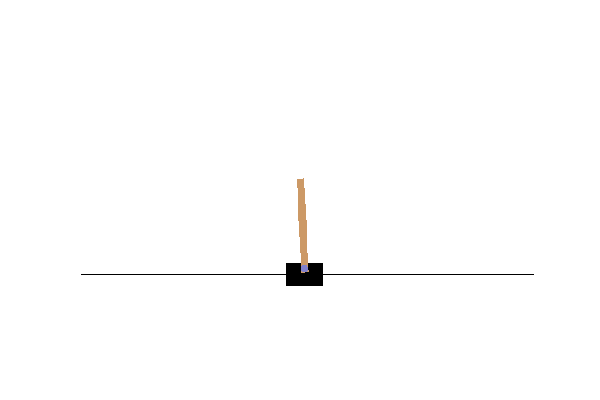
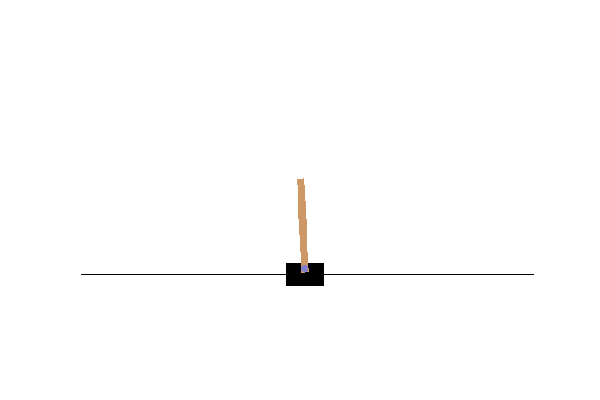
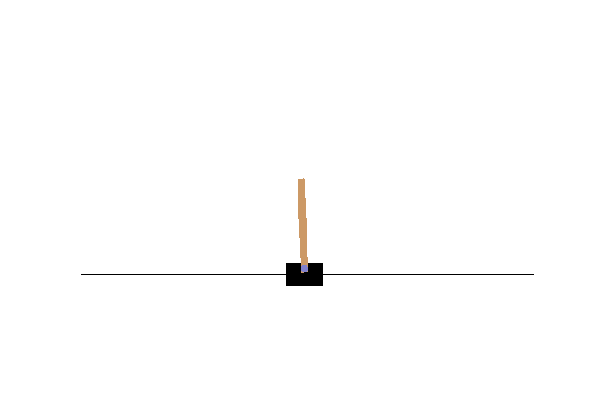
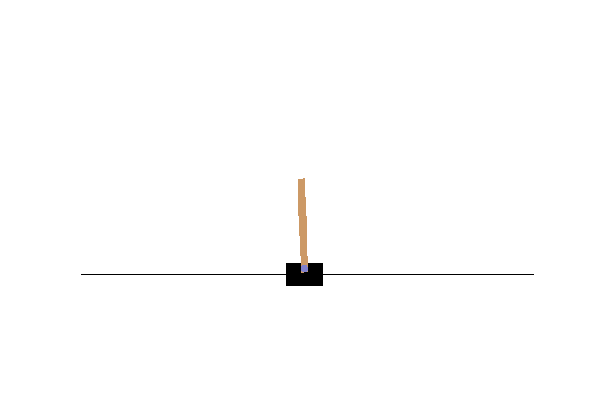
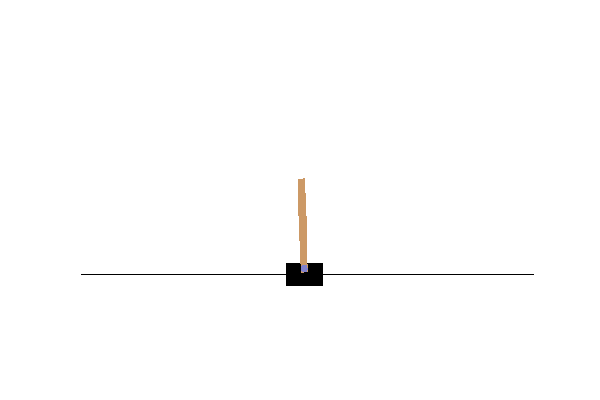
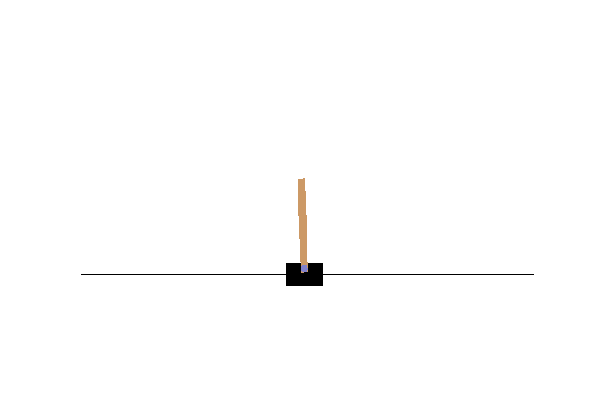
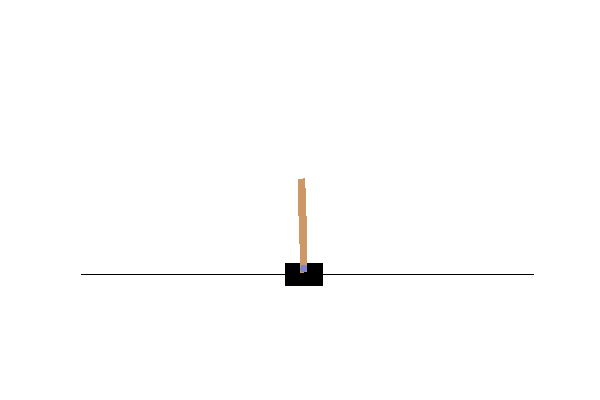
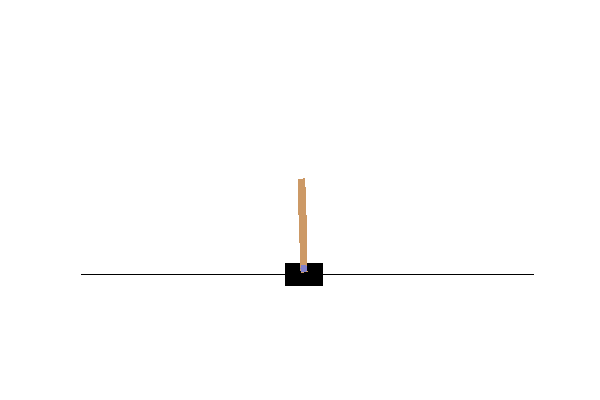
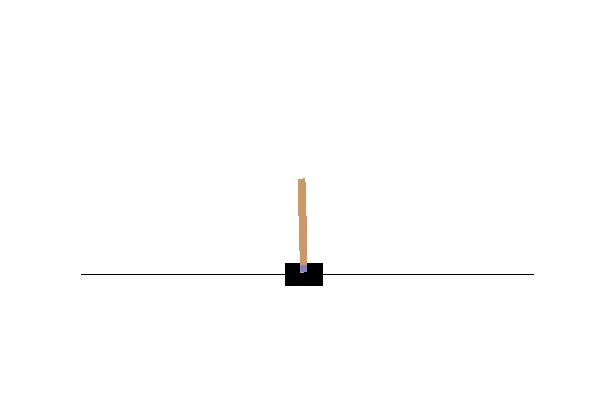
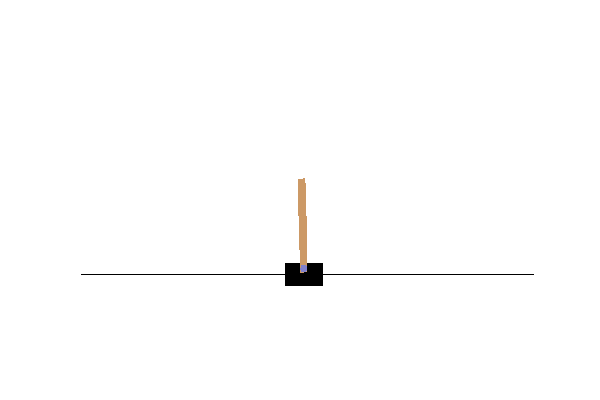
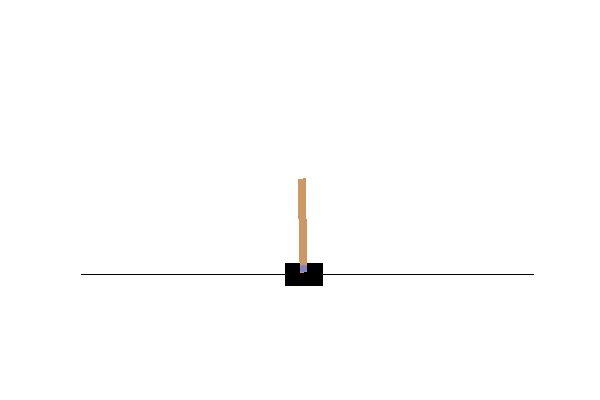
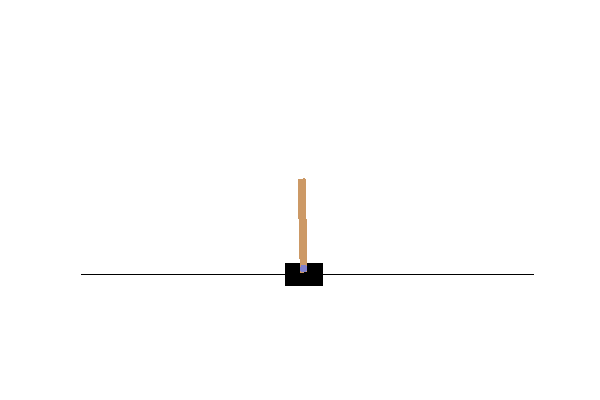
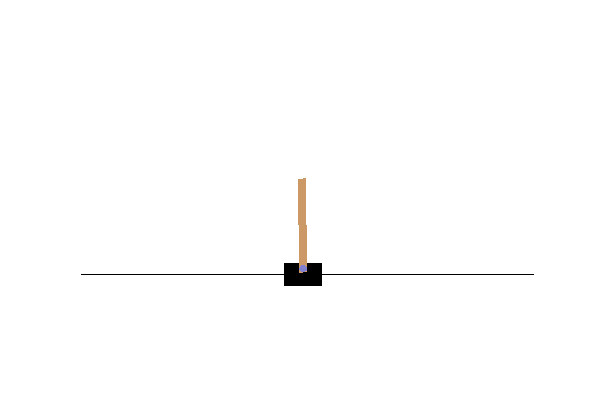
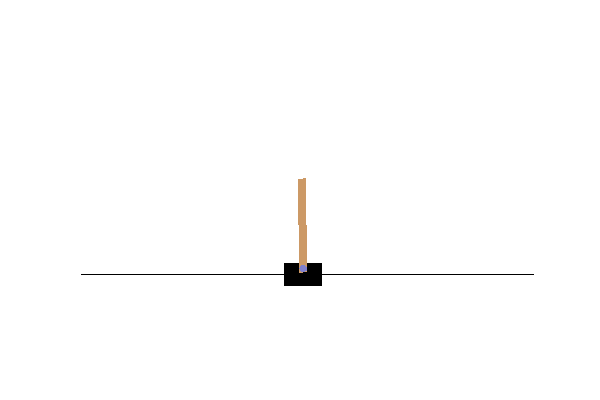
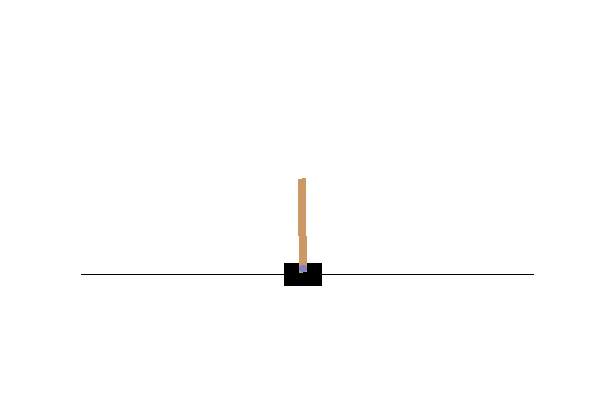
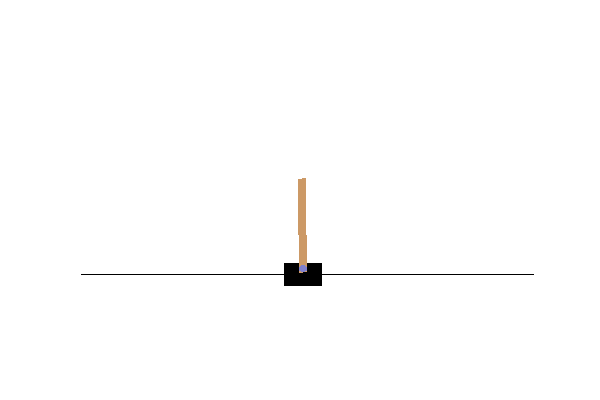
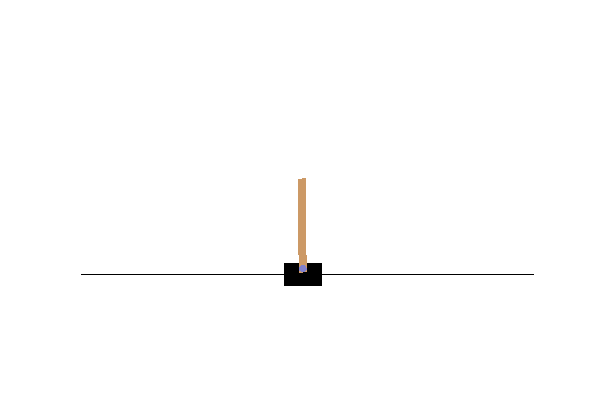
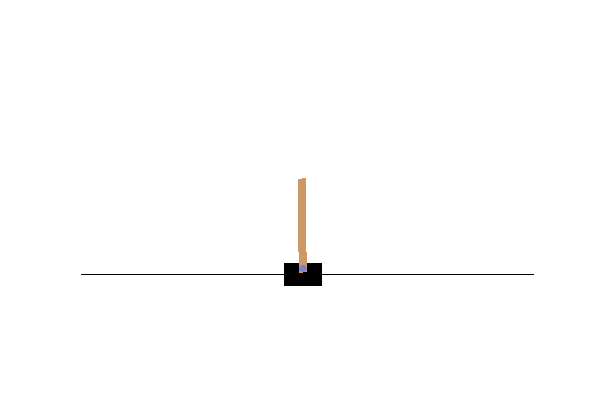
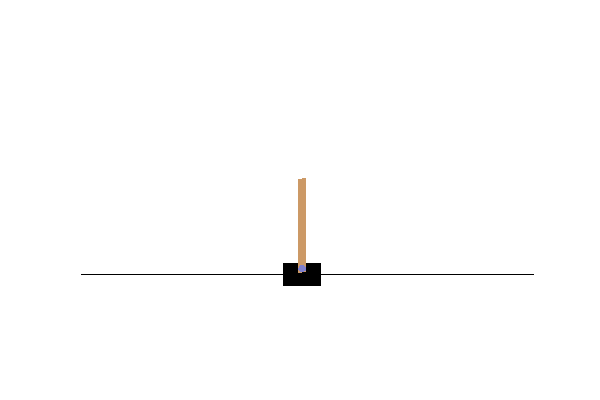
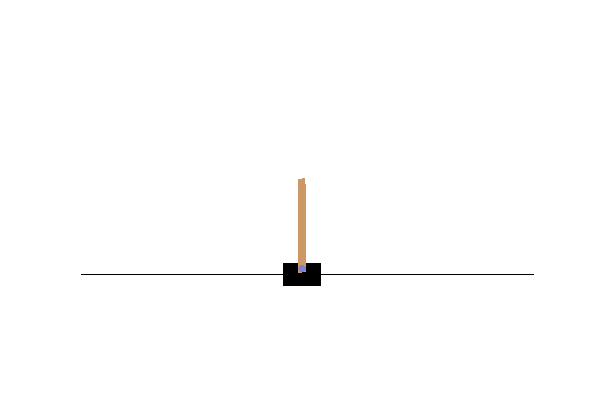
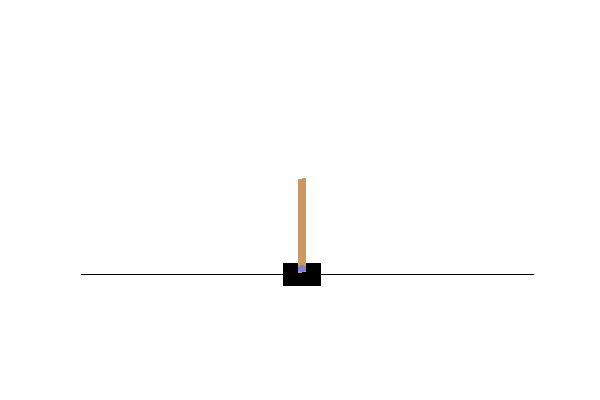
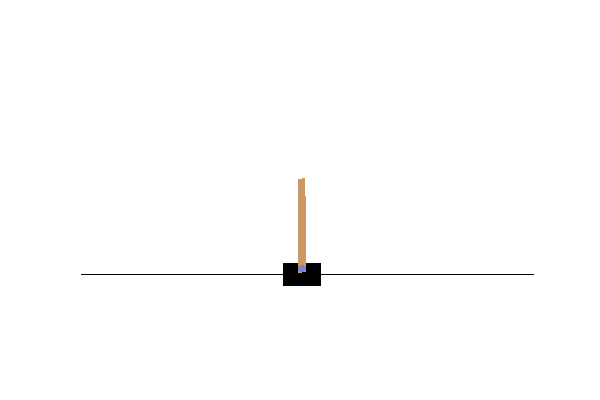
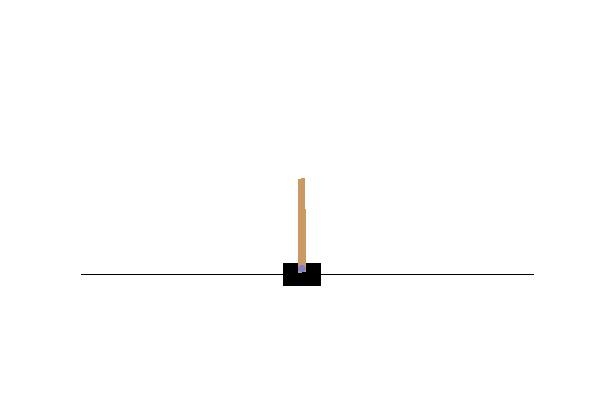
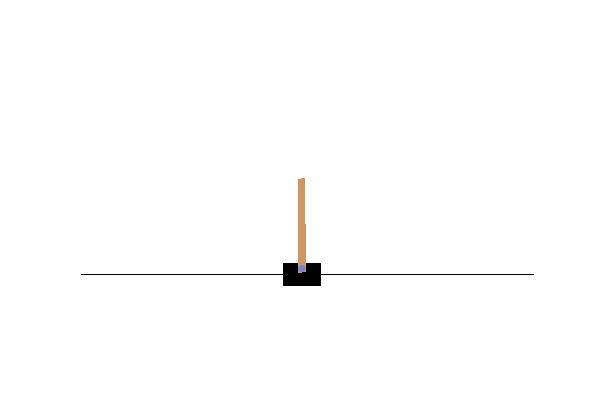
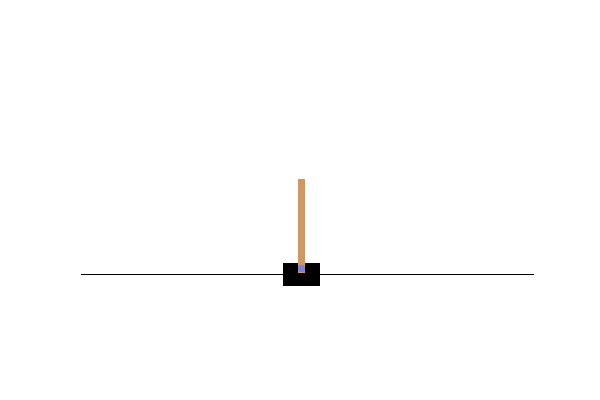
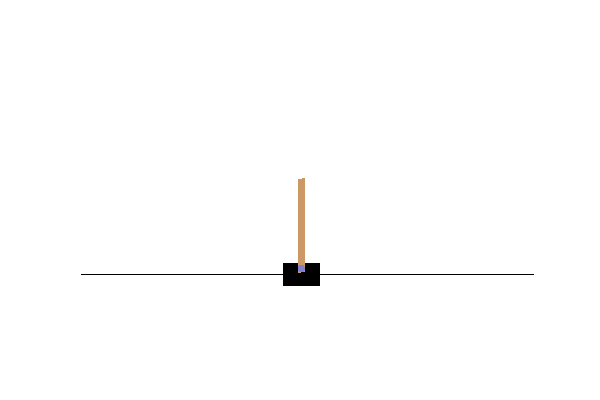
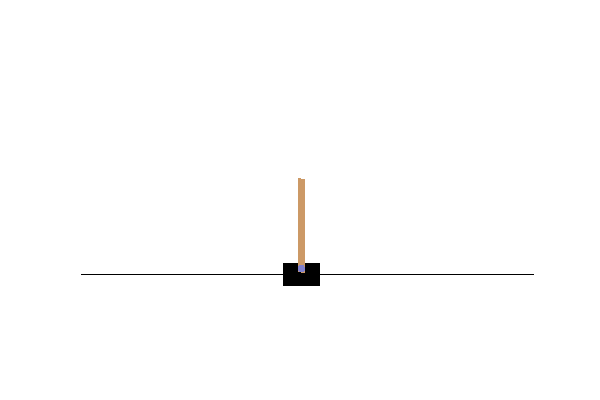
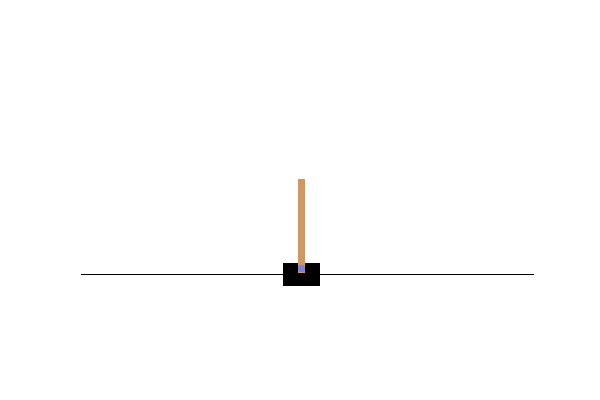
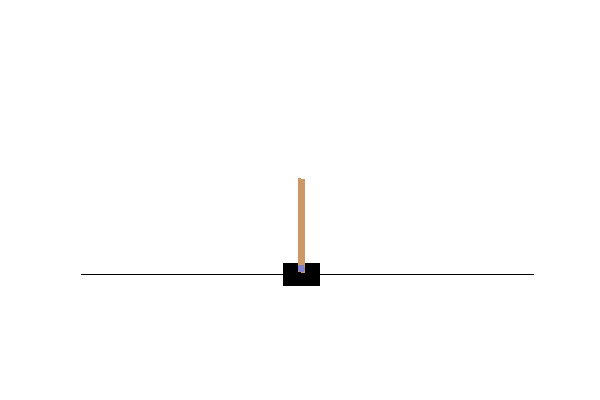
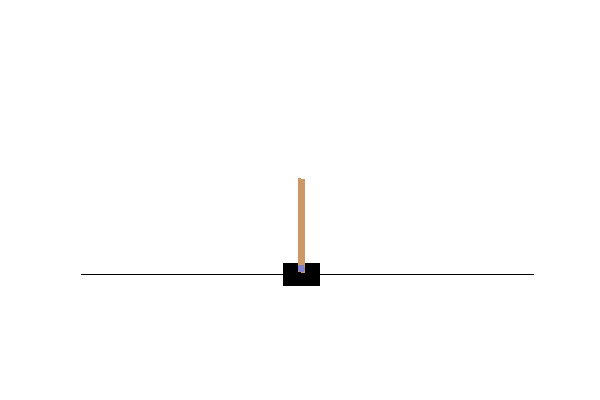
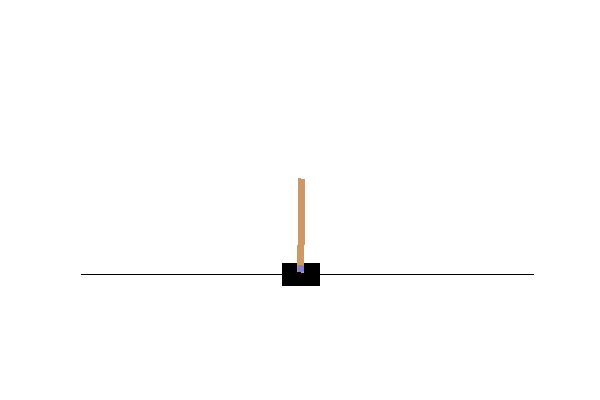
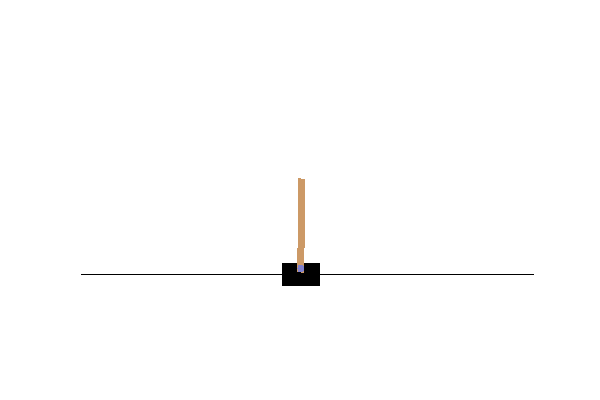
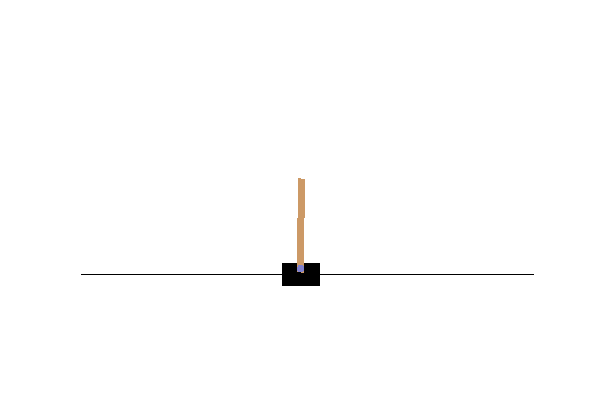
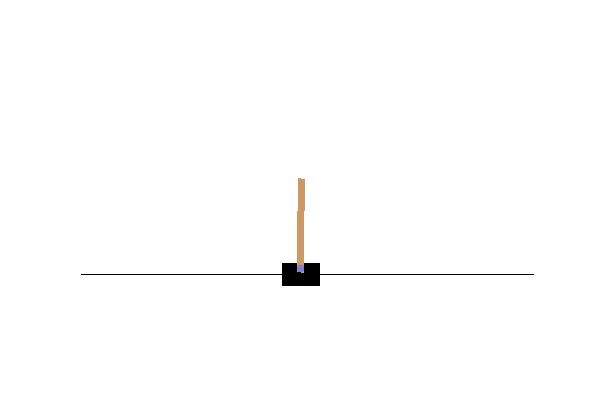
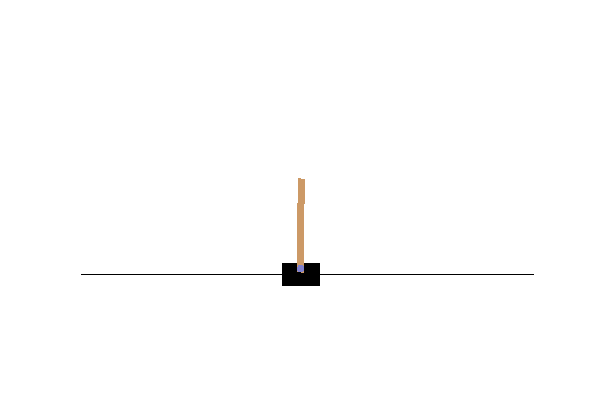
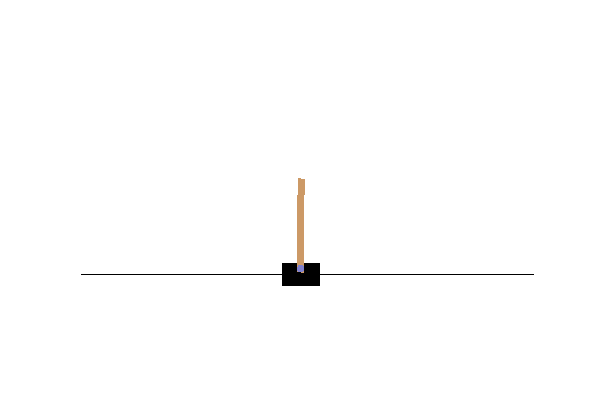
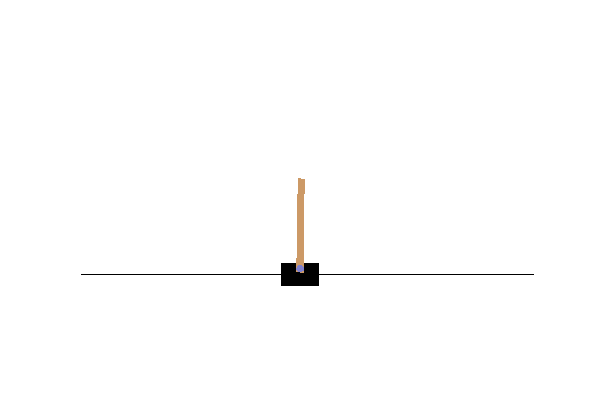
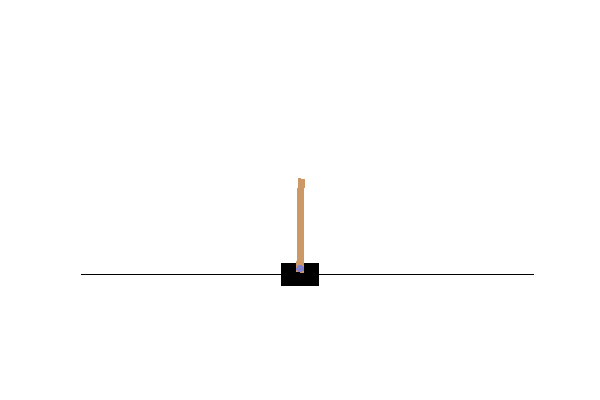
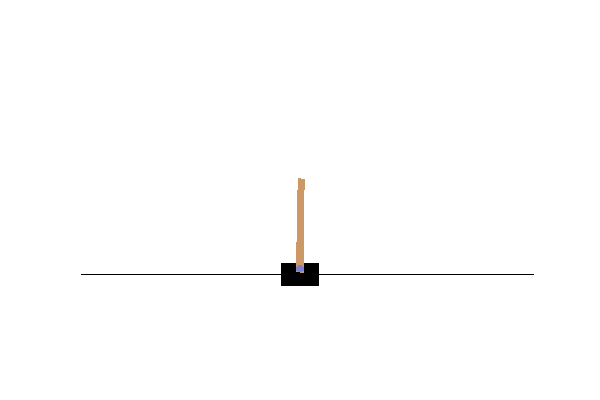
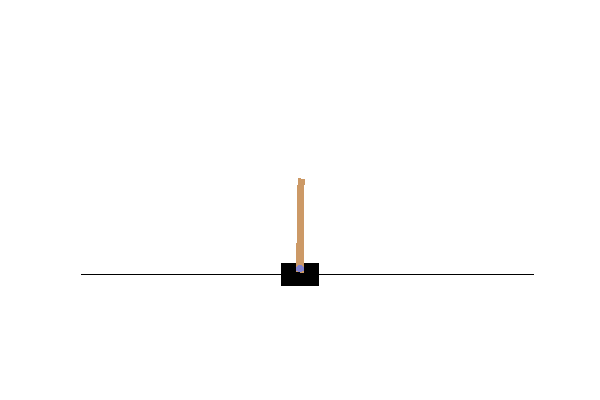
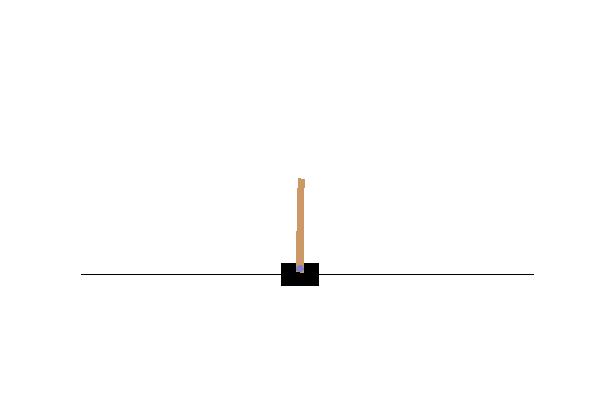
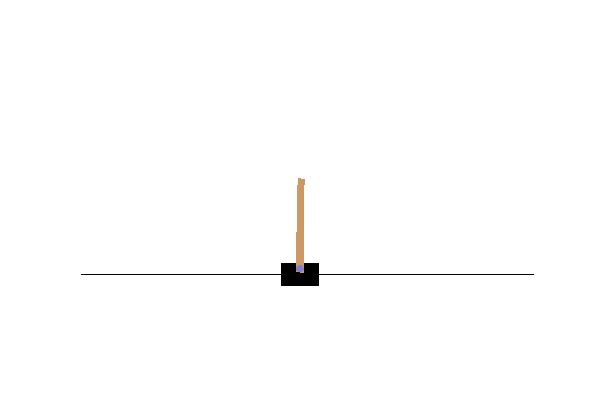
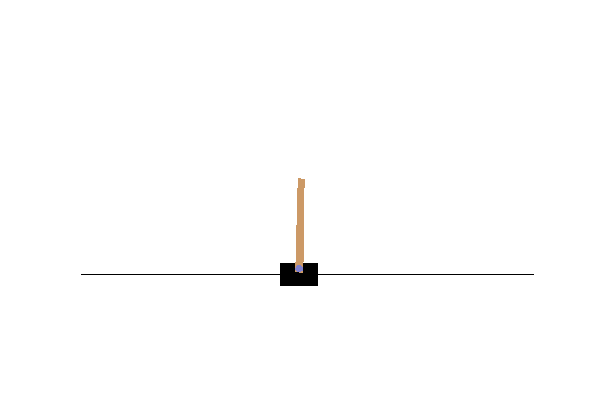
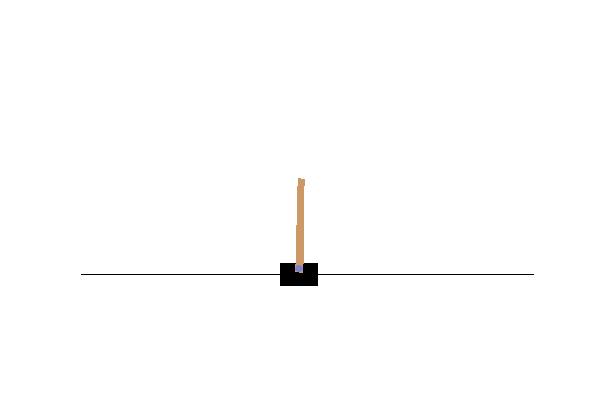
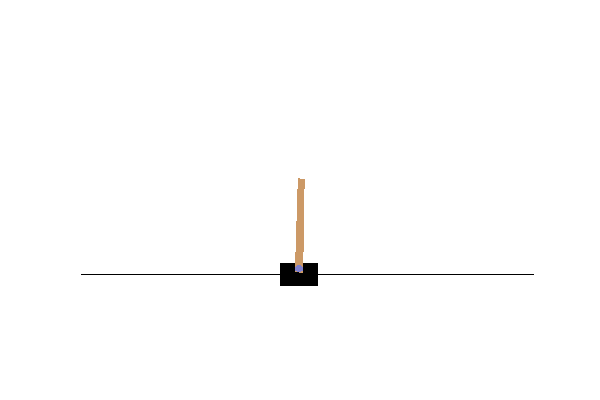
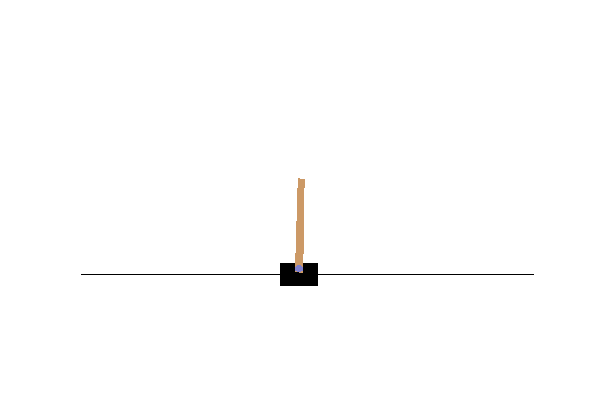
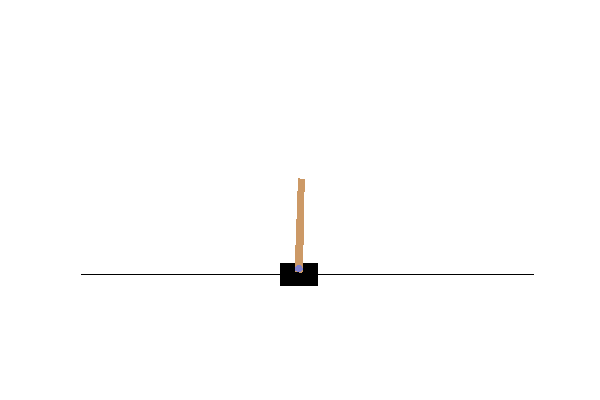
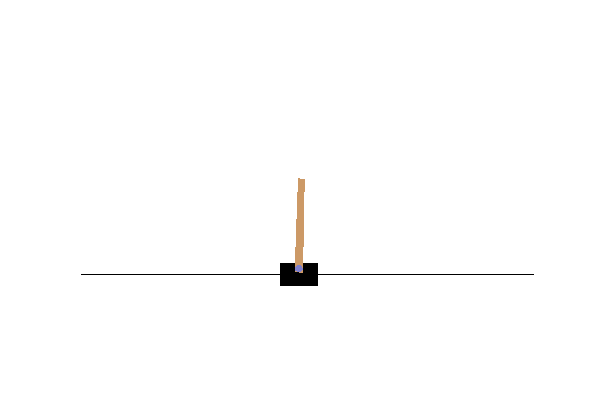
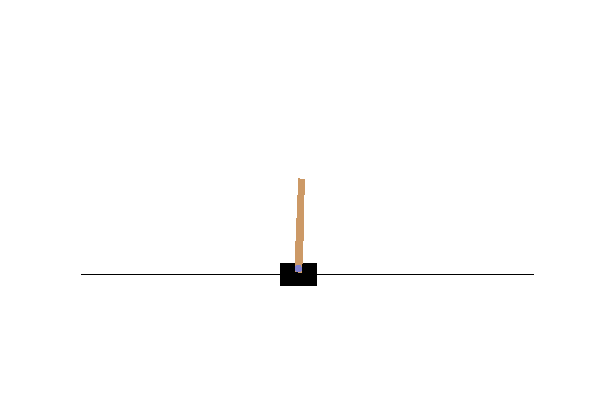
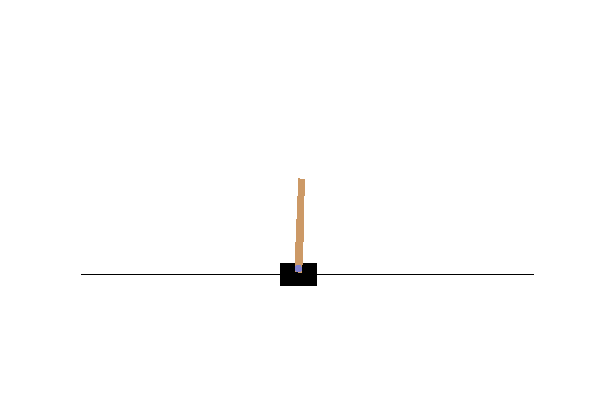
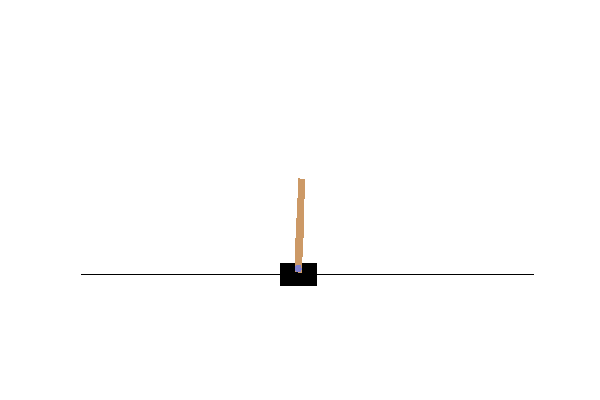
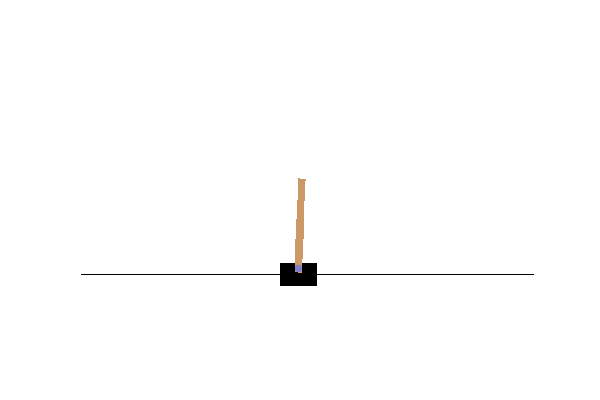
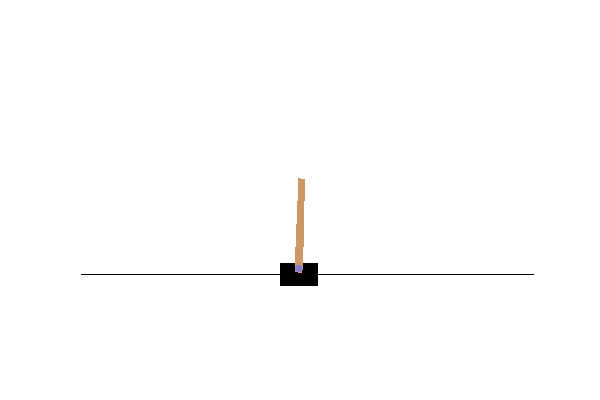
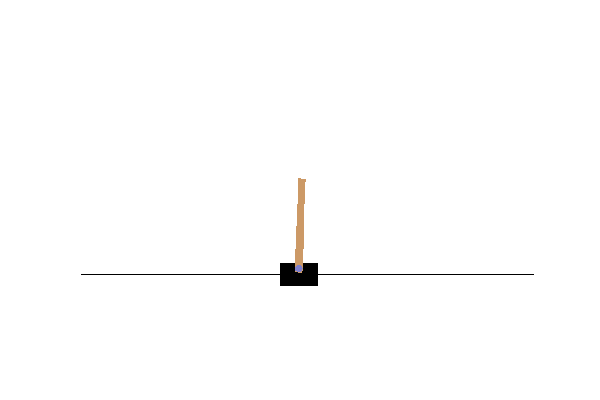
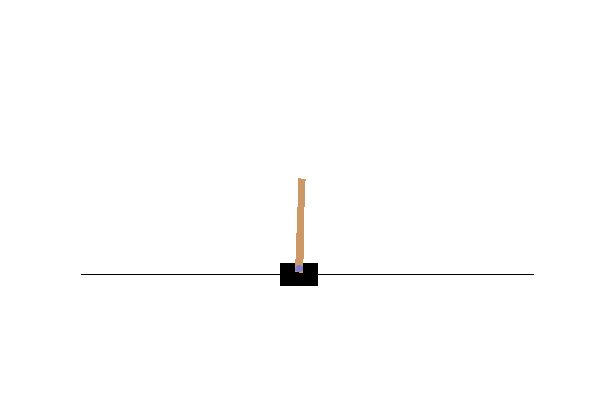
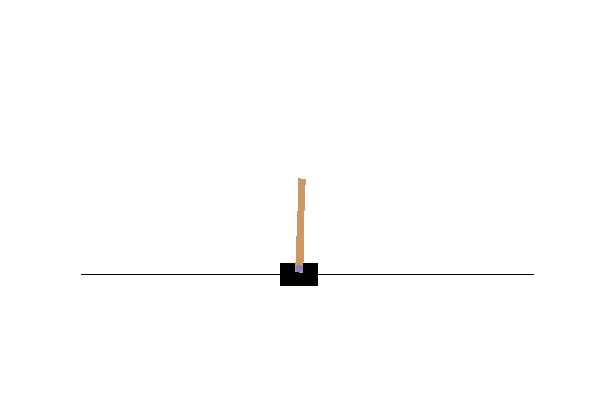
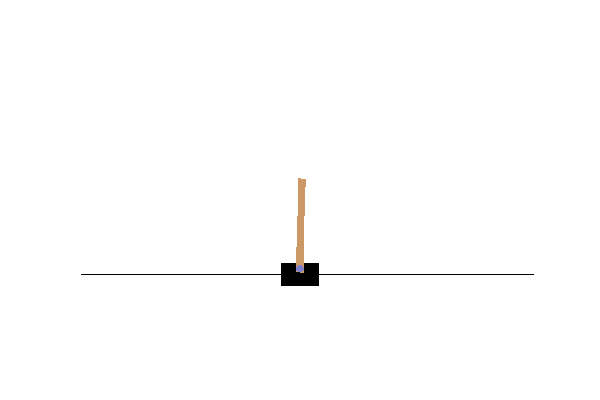
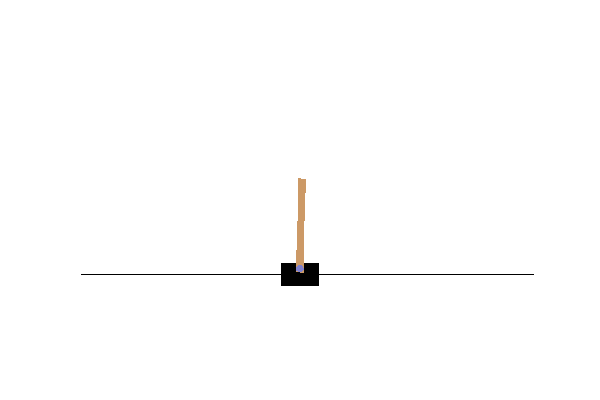
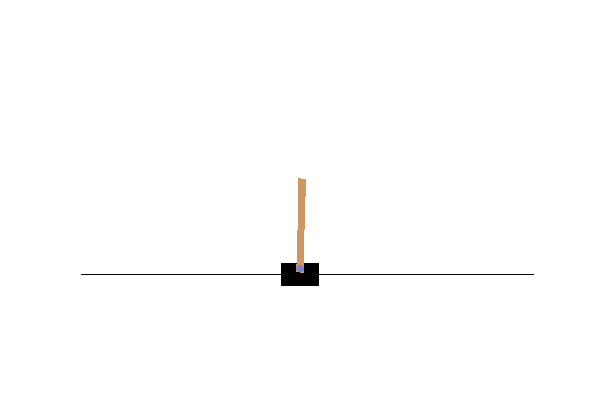
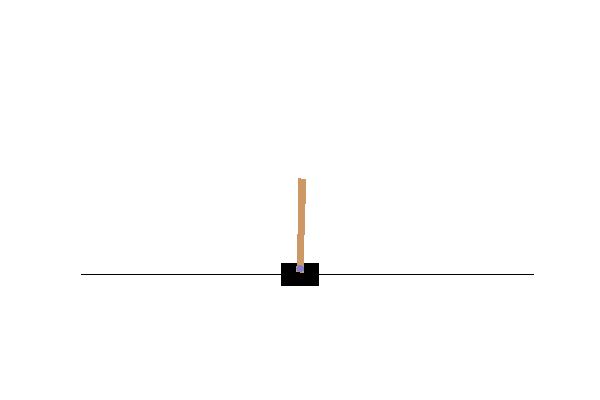
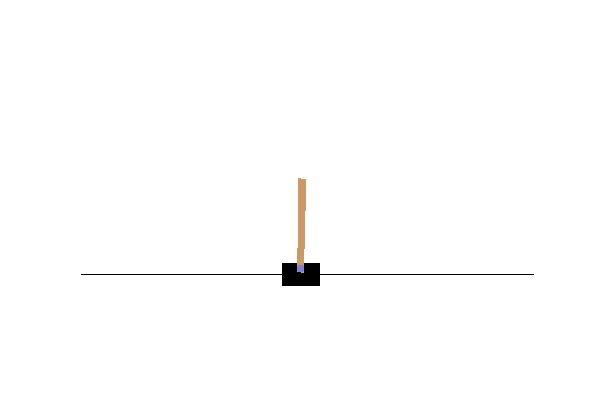
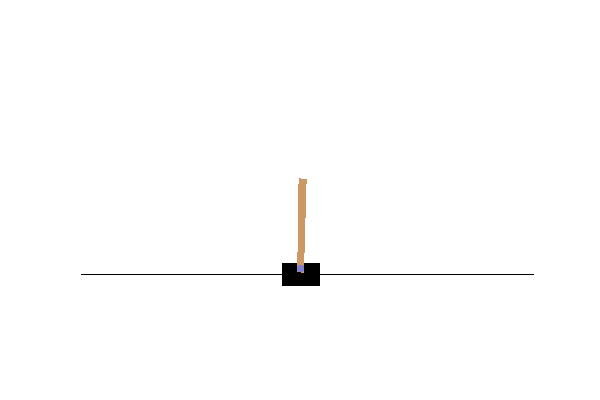
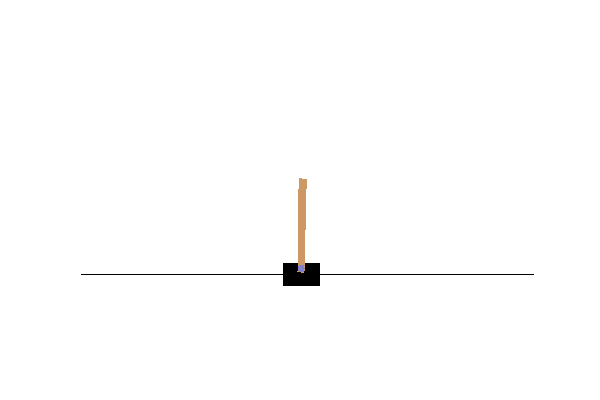
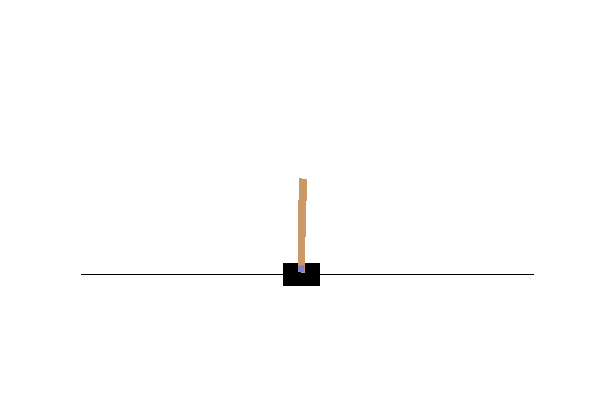
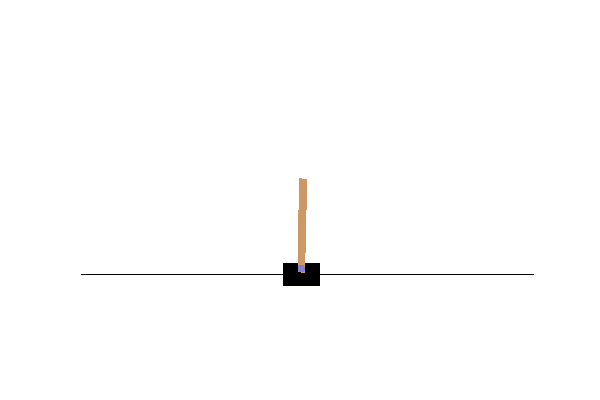
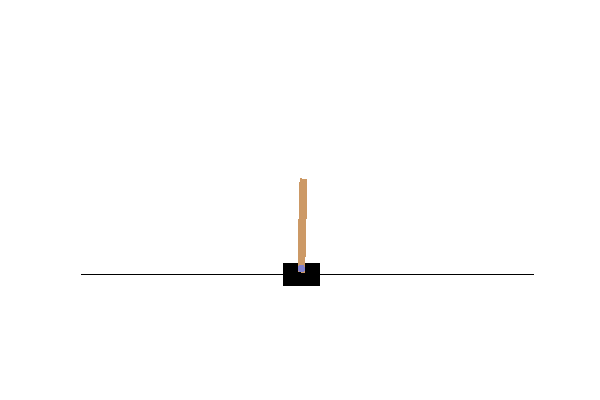
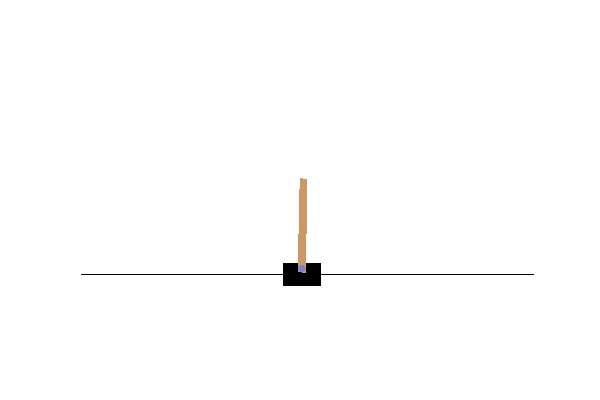
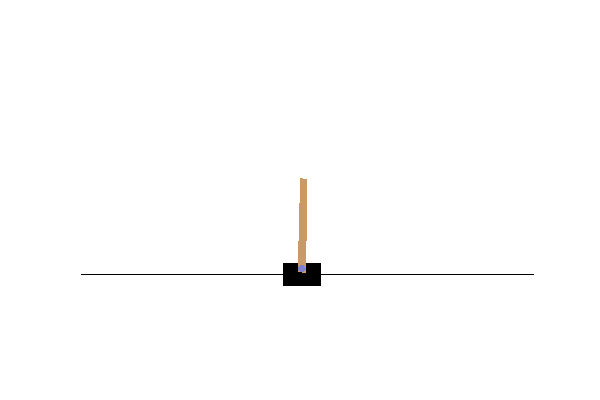
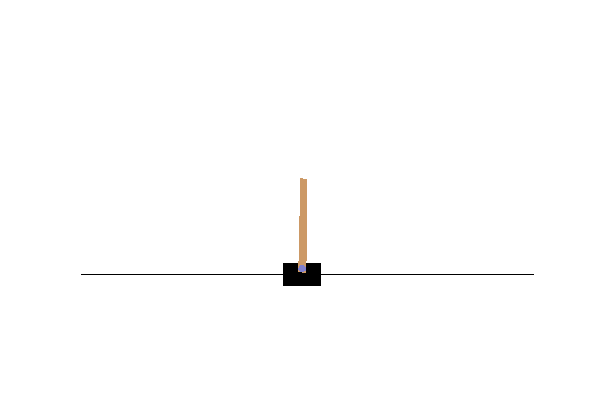
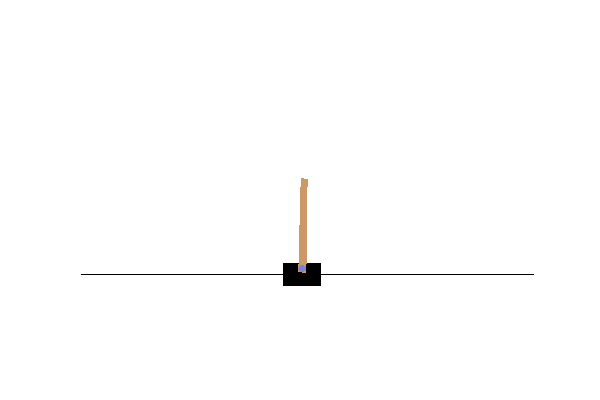
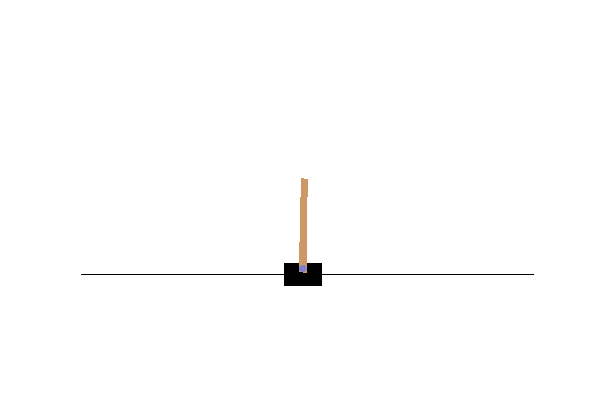
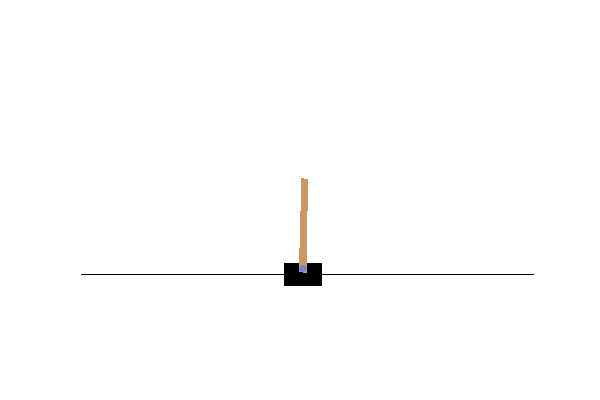
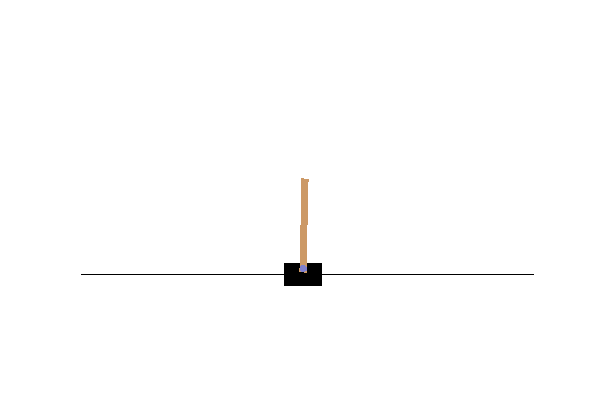
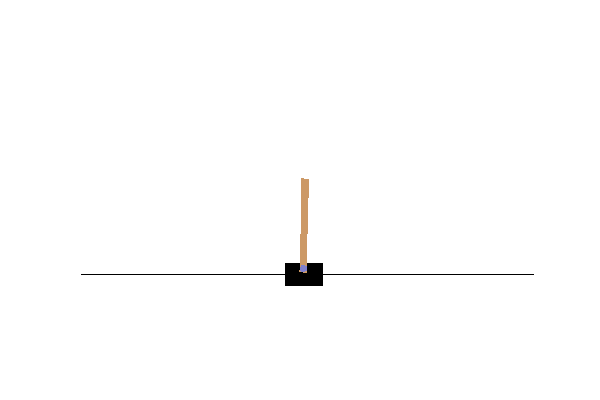
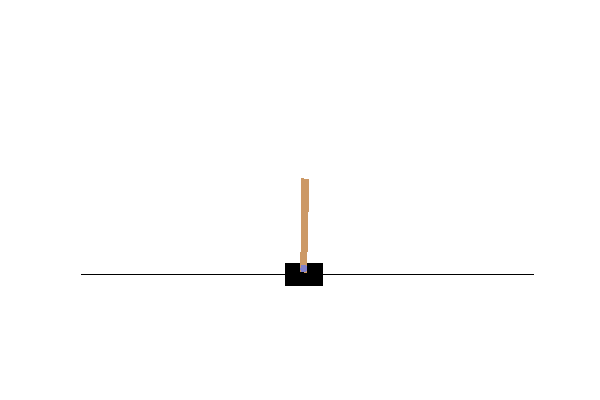
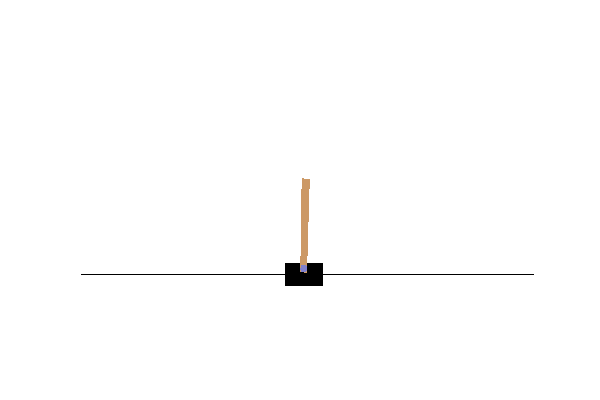
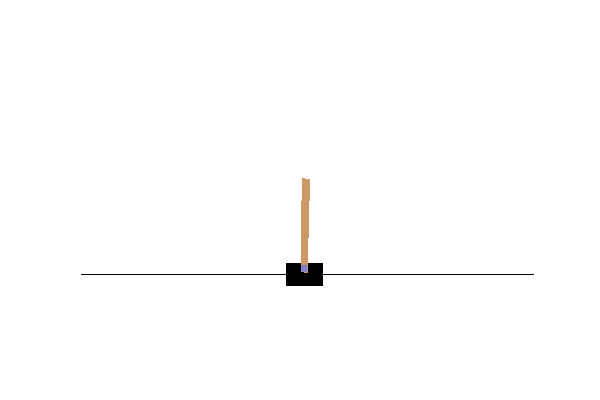
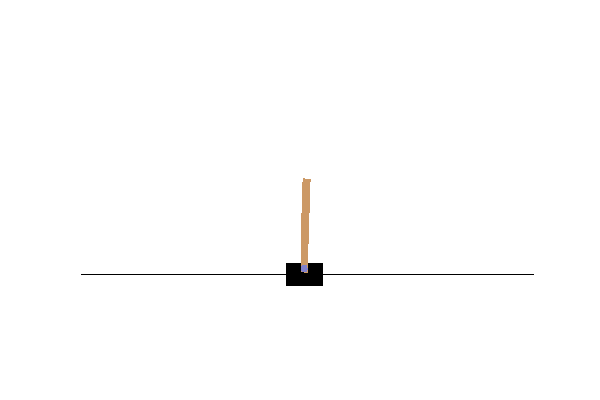
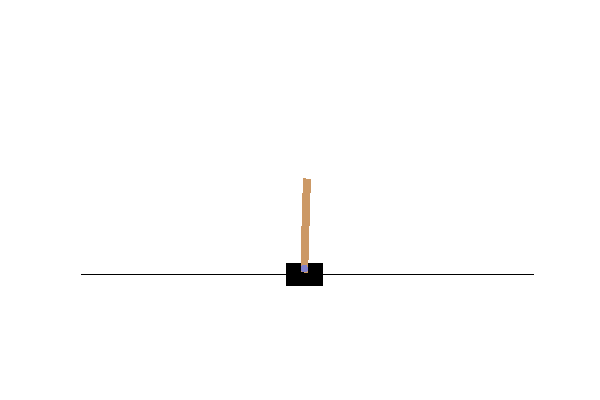
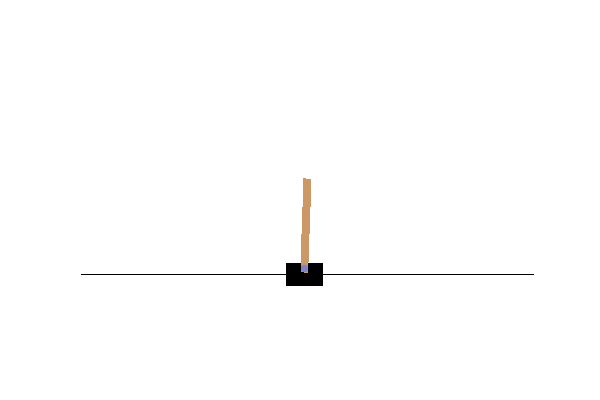
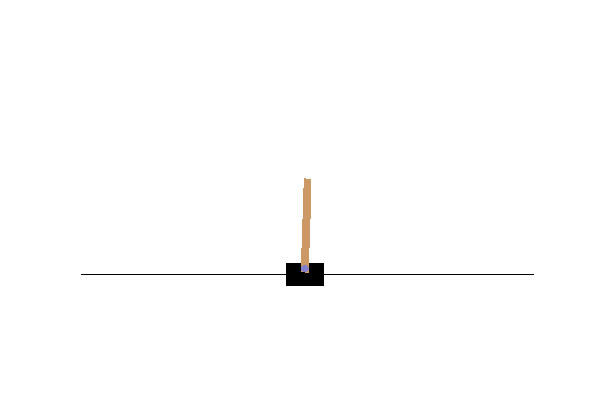
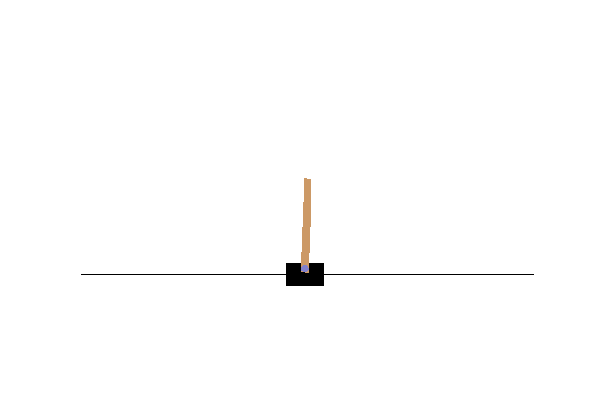
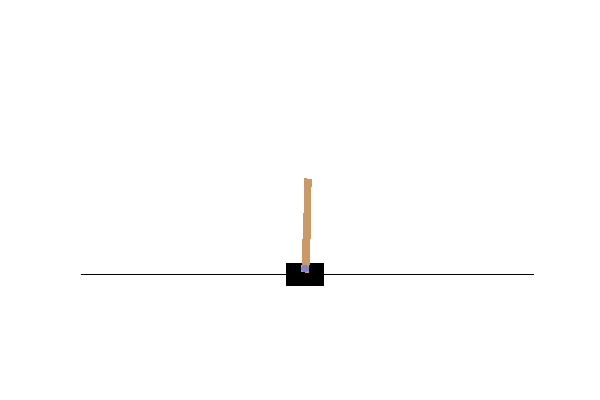
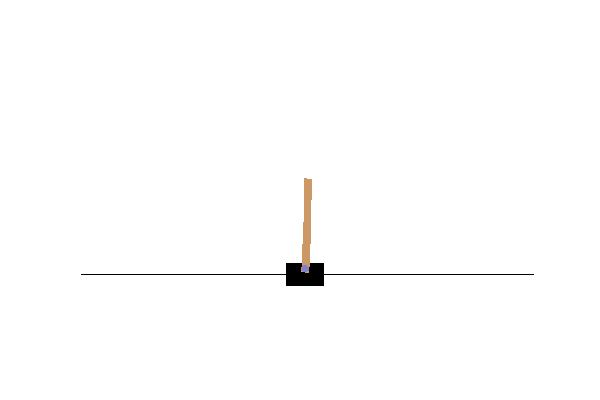
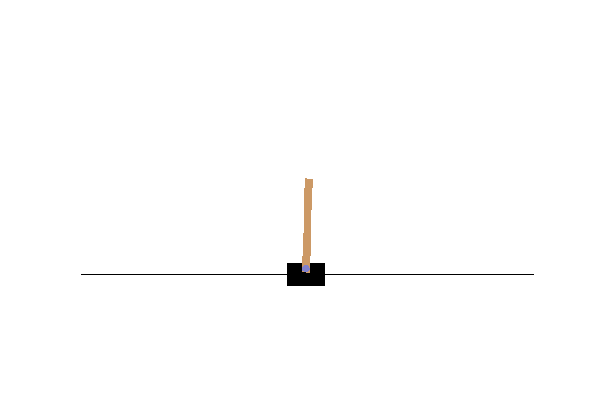
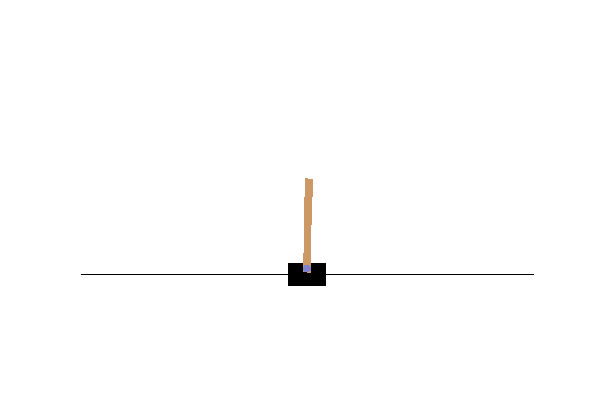
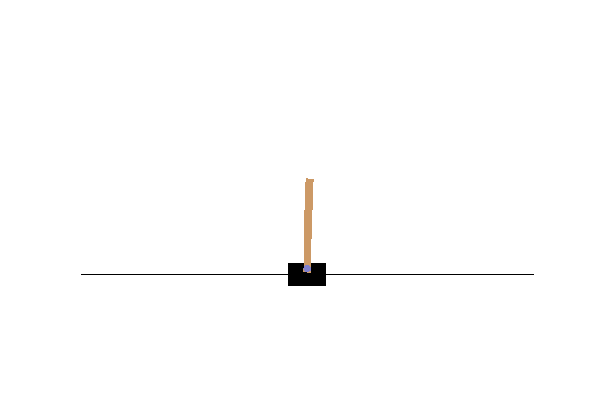
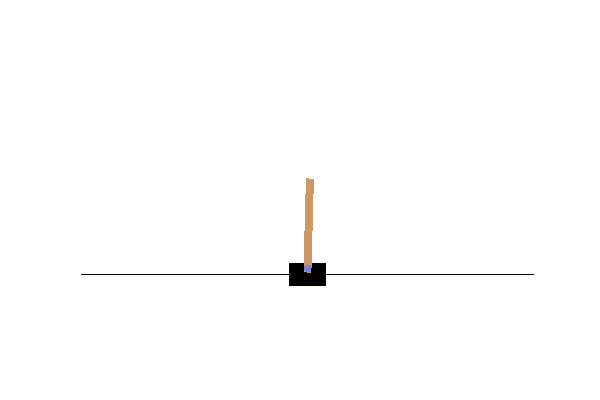
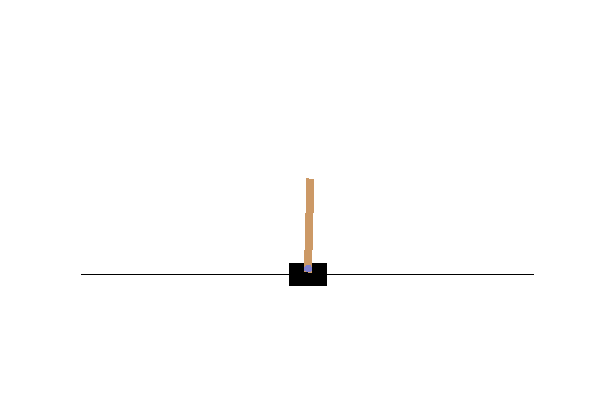
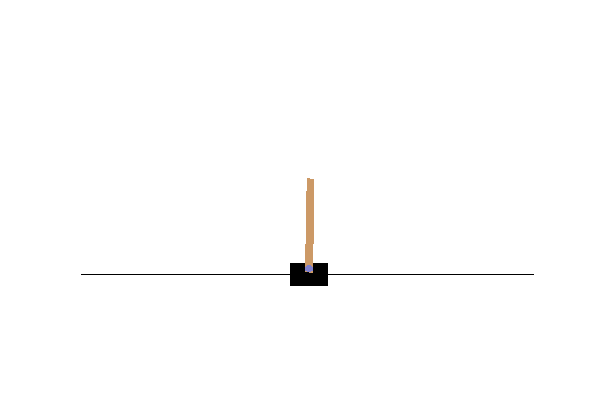
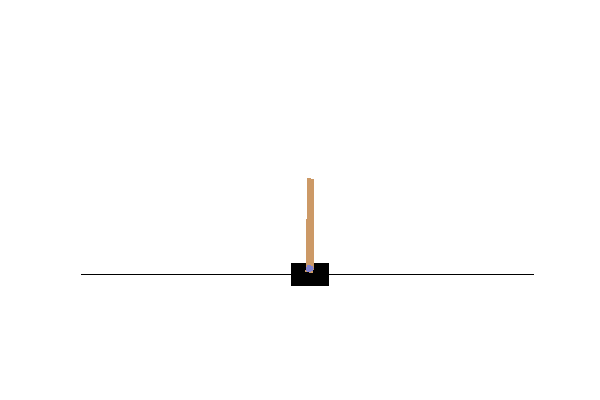
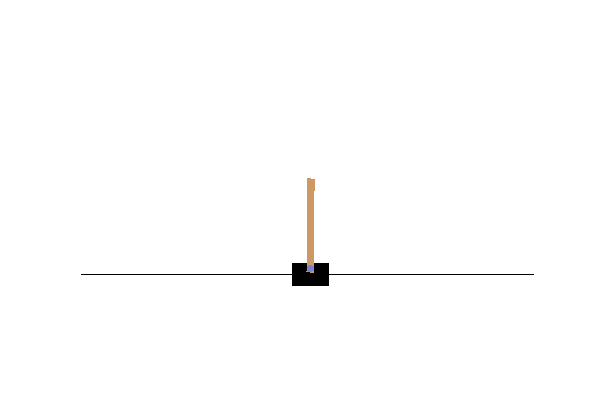
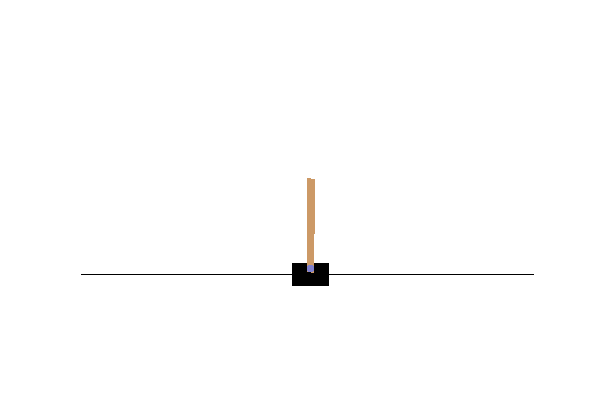
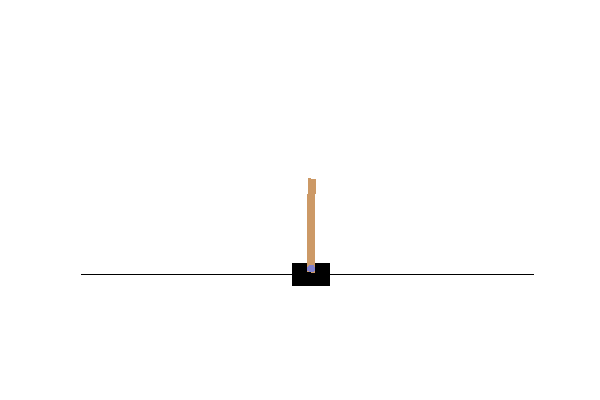
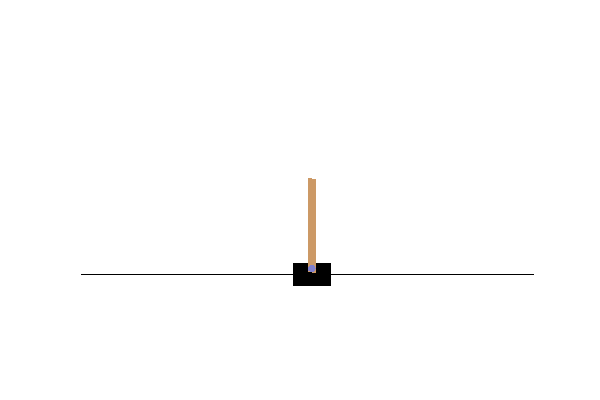
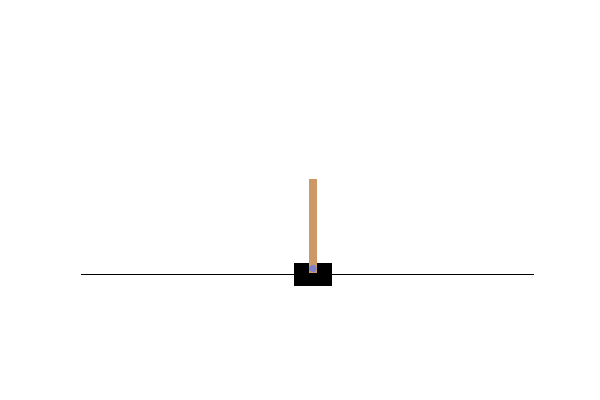
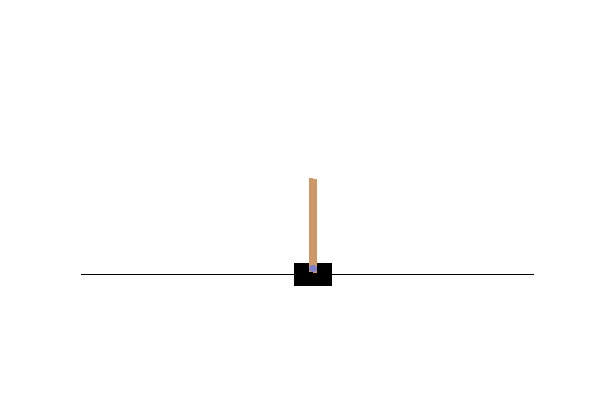
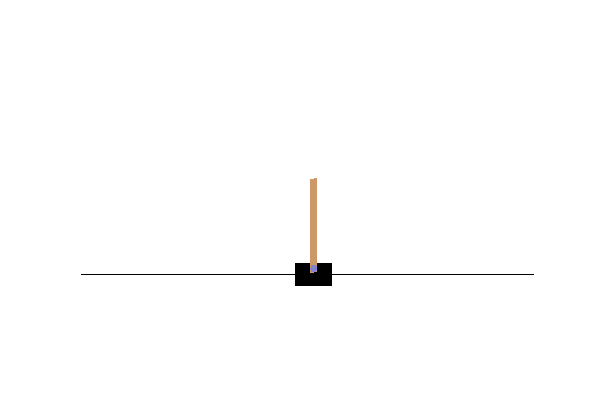
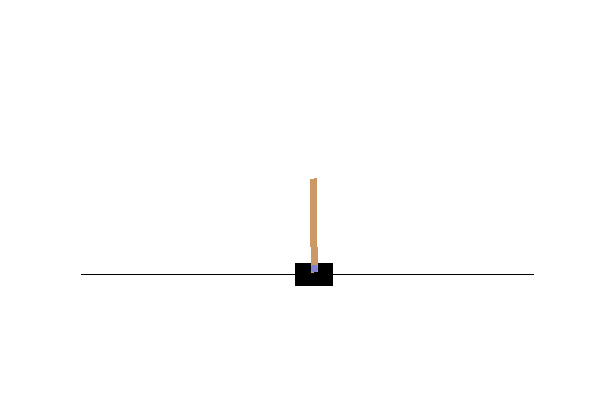
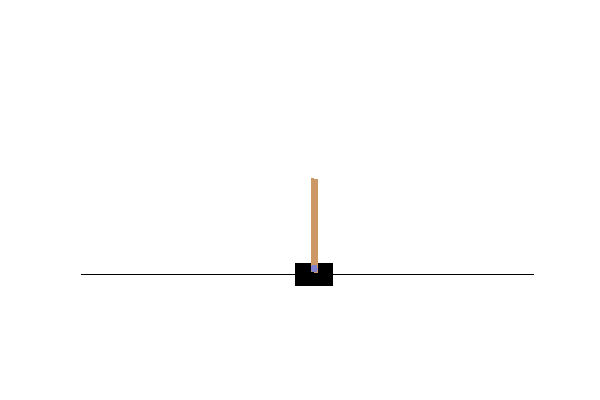

In [19]:
display_frames_as_gif(frames)

In [10]:
agent2 = DQNCartPoleSolver(n_episodes=5000, n_win_ticks=195)

I0715 01:17:47.878745 139826722694912 registration.py:117] Making new env: CartPole-v0
/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [12]:
agent2.run()

[Episode 0] - Mean survival time over last 100 episodes was 21.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 11.51 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 11.51 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 11.61 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 11.75 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 11.44 ticks.
[Episode 600] - Mean survival time over last 100 episodes was 10.77 ticks.
[Episode 700] - Mean survival time over last 100 episodes was 11.5 ticks.
[Episode 800] - Mean survival time over last 100 episodes was 12.73 ticks.
[Episode 900] - Mean survival time over last 100 episodes was 12.6 ticks.
[Episode 1000] - Mean survival time over last 100 episodes was 14.02 ticks.
[Episode 1100] - Mean survival time over last 100 episodes was 13.31 ticks.
[Episode 1200] - Mean survival time over last 100 episodes was 14.74 ticks.
[Episode 1300] - Mean survi

4999

In [13]:
env = gym.make('CartPole-v0')
observation = env.reset()
cum_reward = 0
frames = []
for t in range(100):
    # Render into buffer. 
    # You will still see the window.
    frames.append(env.render(mode = 'rgb_array'))
#    action = env.action_space.sample()
    # no epsilon, just follow the best strategy
    action = agent2.choose_action(agent2.preprocess_state(observation), 0)
    observation, reward, done, info = env.step(action)
    print (action, observation, reward, done, info)
#    if done:
#        print("Episode finished after {} timesteps".format(t+1))
#        break
env.render(close=True)

I0715 01:23:48.920966 139826722694912 registration.py:117] Making new env: CartPole-v0
/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


0 [ 0.01369467 -0.18676962  0.03180404  0.30008151] 1.0 False {}
0 [ 0.00995927 -0.38233012  0.03780567  0.60262273] 1.0 False {}
0 [ 0.00231267 -0.5779599   0.04985813  0.90696994] 1.0 False {}
1 [-0.00924653 -0.38354714  0.06799753  0.6303654 ] 1.0 False {}
0 [-0.01691747 -0.57954872  0.08060484  0.94366423] 1.0 False {}
1 [-0.02850844 -0.38559981  0.09947812  0.6773576 ] 1.0 False {}
1 [-0.03622044 -0.1919904   0.11302527  0.41757761] 1.0 False {}
1 [-0.04006025  0.00136359  0.12137682  0.16255591] 1.0 False {}
0 [-0.04003298 -0.19526799  0.12462794  0.49093054] 1.0 False {}
1 [-0.04393834 -0.0021041   0.13444655  0.23997782] 1.0 False {}
1 [-0.04398042  0.19086668  0.13924611 -0.00745788] 1.0 False {}
0 [-0.04016309 -0.00594912  0.13909695  0.3257145 ] 1.0 False {}
1 [-0.04028207  0.18694664  0.14561124  0.07992822] 1.0 False {}
1 [-0.03654313  0.37971365  0.14720981 -0.16350375] 1.0 False {}
0 [-0.02894886  0.18282464  0.14393973  0.17175903] 1.0 False {}
1 [-0.02529237  0.3756245

W0715 01:23:49.888242 139826722694912 cartpole.py:85] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


1 [1.38142461 1.81948662 0.17003746 0.17270925] 1.0 False {}
1 [ 1.41781435  2.01181866  0.17349165 -0.06187774] 1.0 False {}
0 [1.45805072 1.81468868 0.1722541  0.28012932] 1.0 False {}
1 [1.49434449 2.00698857 0.17785668 0.04634092] 1.0 False {}
0 [1.53448426 1.80982129 0.1787835  0.38944103] 1.0 False {}
1 [1.57068069 2.00201509 0.18657232 0.15802825] 1.0 False {}
1 [ 1.61072099  2.19404405  0.18973289 -0.07048184] 1.0 False {}
0 [1.65460187 1.9967802  0.18832325 0.27555138] 1.0 False {}
1 [1.69453748 2.18878619 0.19383428 0.04767487] 1.0 False {}
0 [1.7383132  1.99148954 0.19478777 0.39470873] 1.0 False {}
1 [1.77814299 2.18339144 0.20268195 0.1692057 ] 1.0 False {}
1 [ 1.82181082  2.37512274  0.20606606 -0.05332287] 1.0 False {}
0 [1.86931327 2.17773369 0.2049996  0.29665216] 1.0 False {}
1 [1.91286795 2.36943354 0.21093265 0.074972  ] 1.0 True {}
1 [ 1.96025662  2.56100601  0.21243209 -0.14446235] 0.0 True {}
0 [2.01147674 2.36357477 0.20954284 0.20701379] 0.0 True {}
1 [ 2.05874


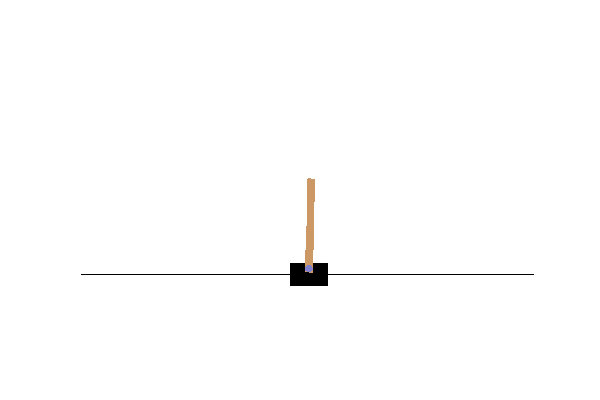
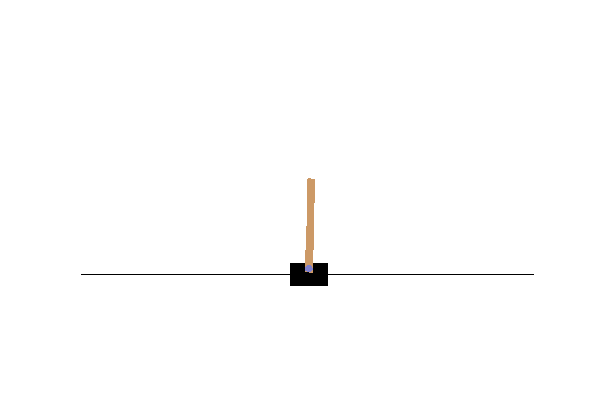
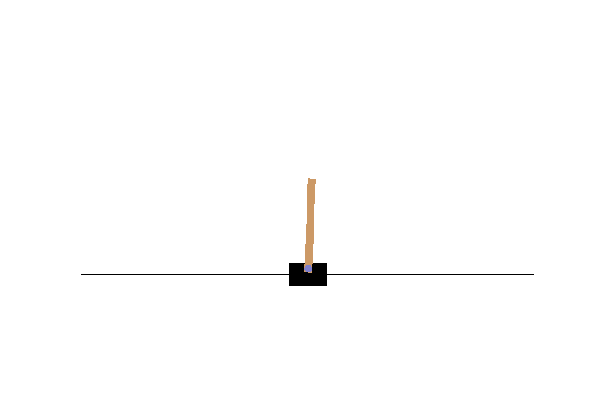
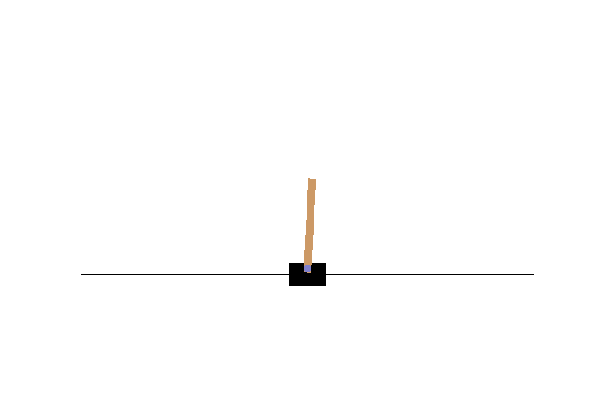
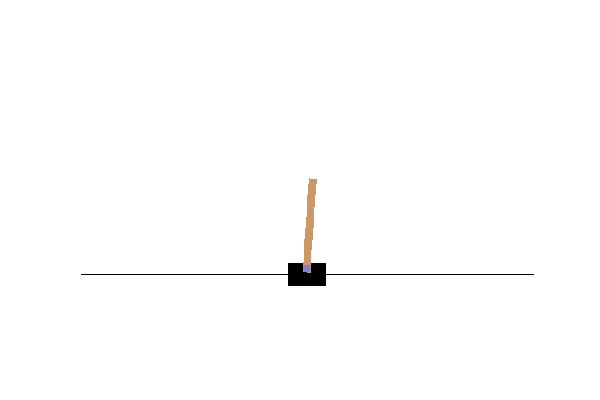
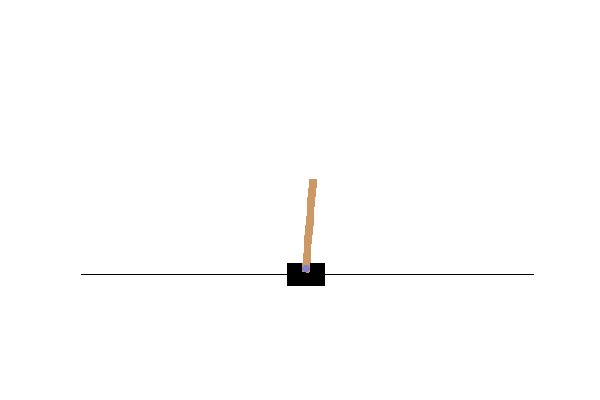
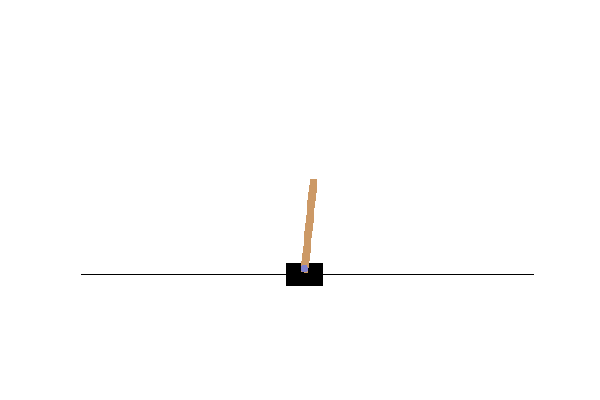
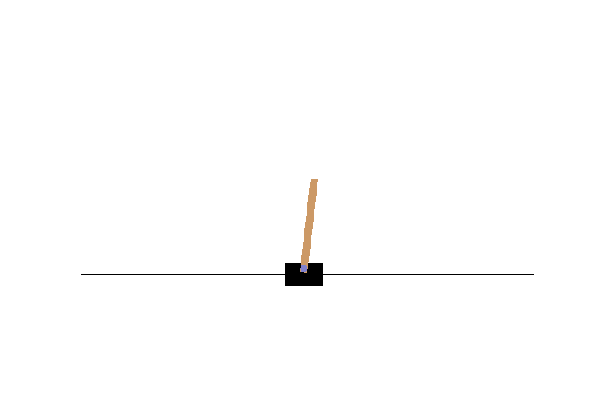
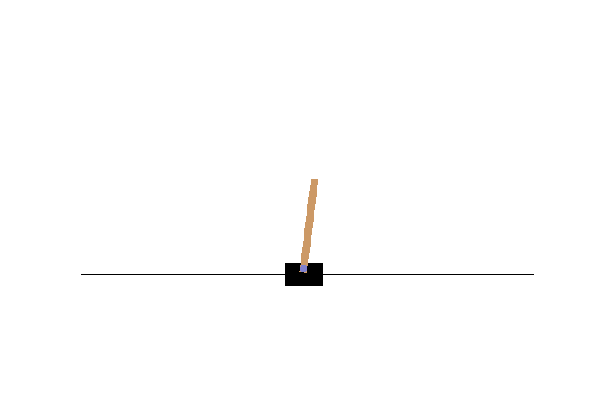
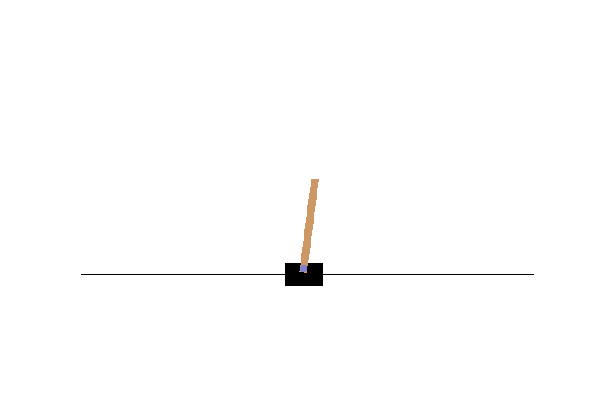
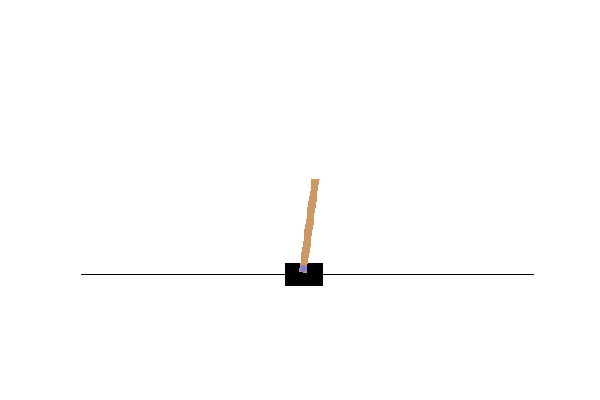
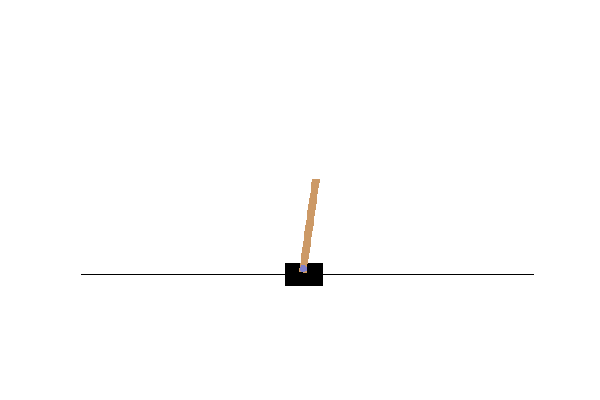
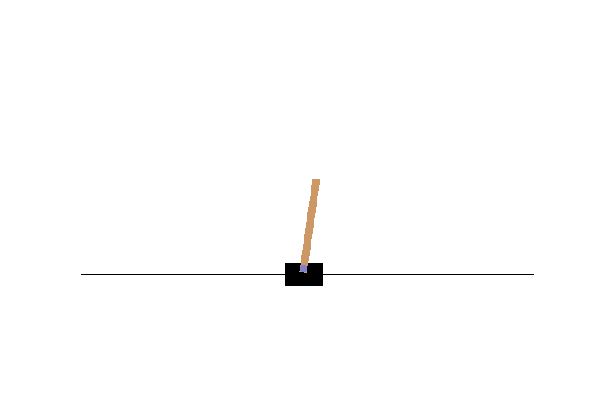
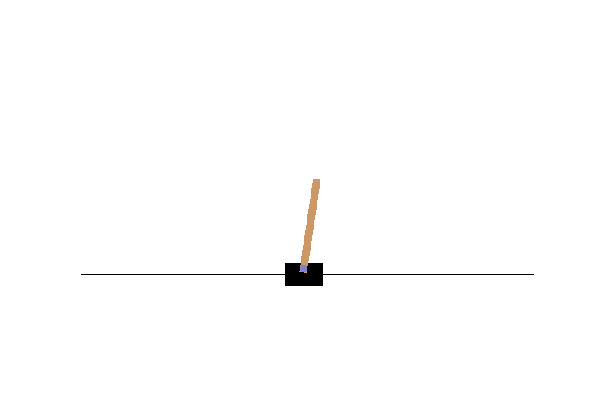
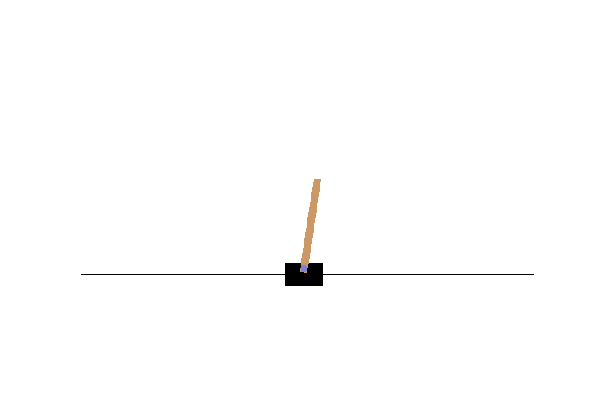
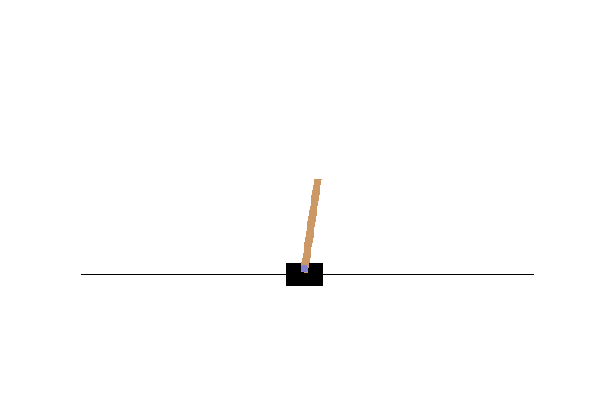
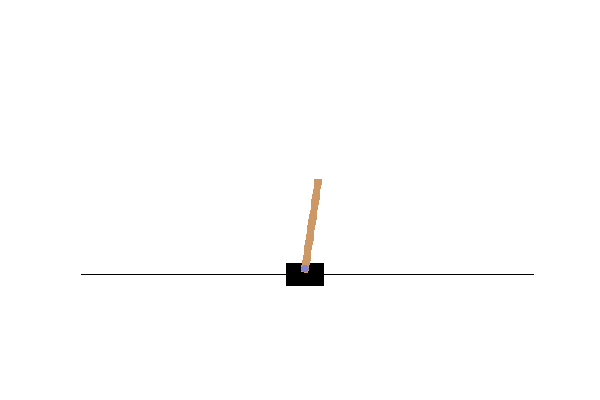
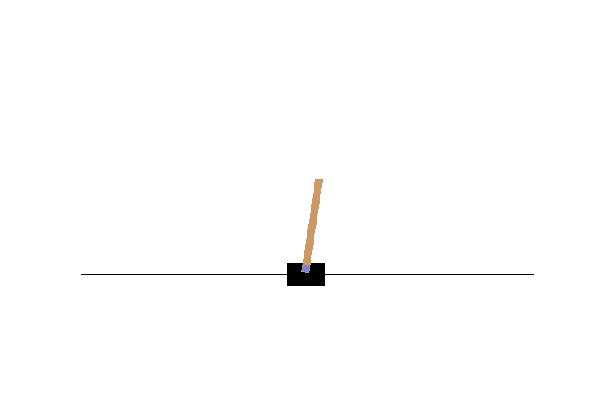
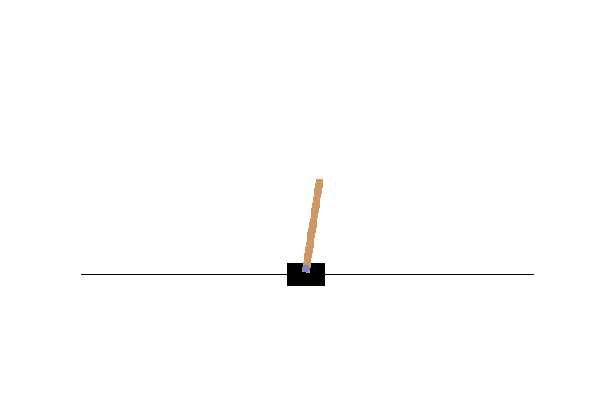
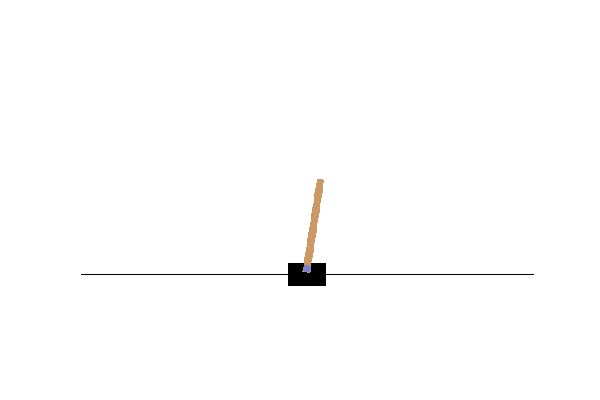
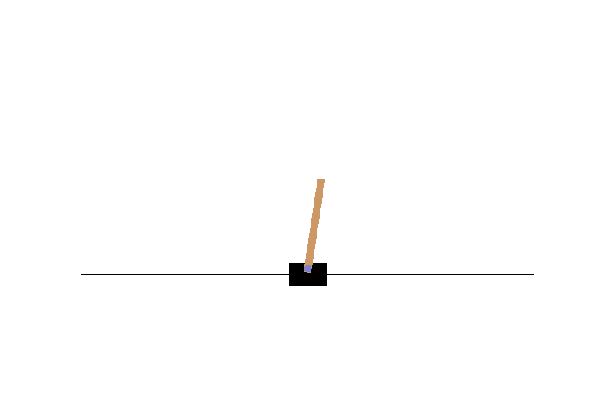
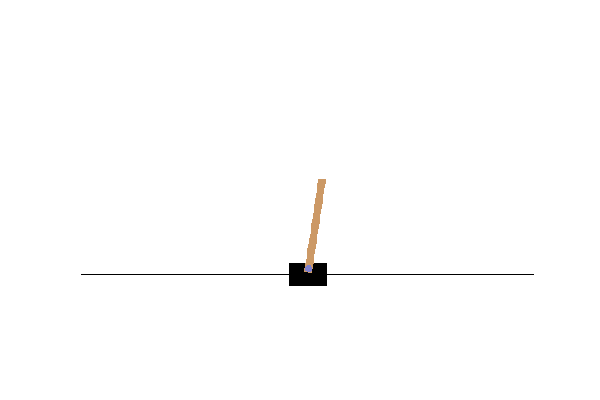
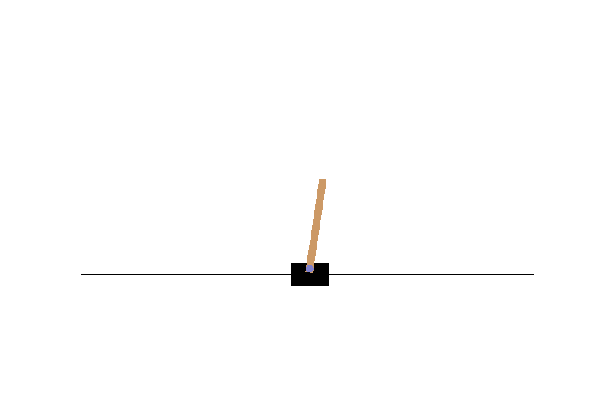
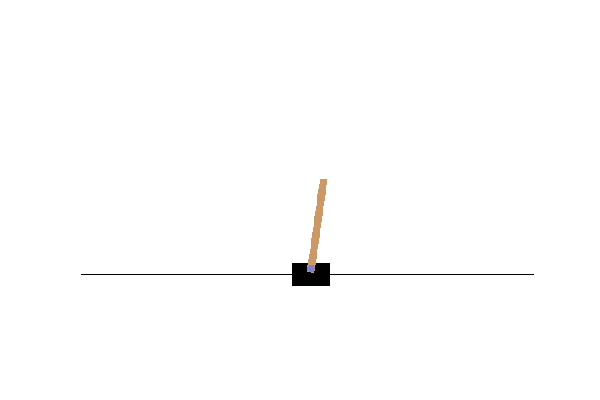
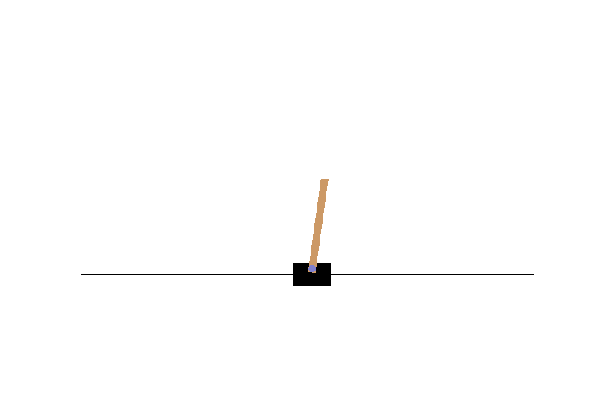
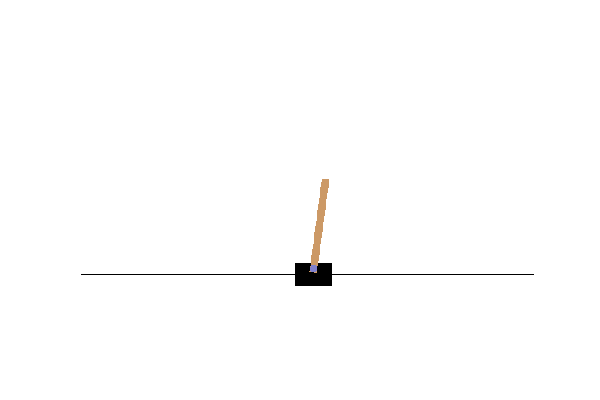
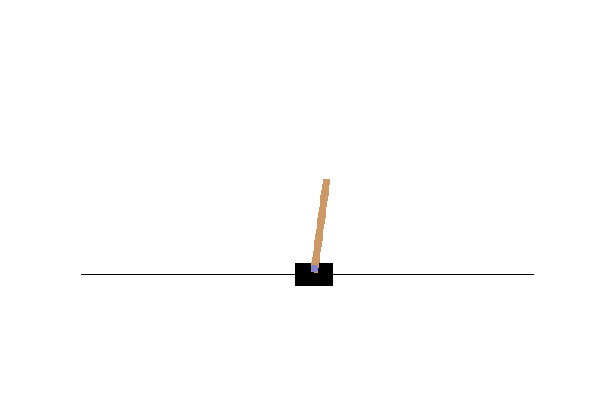
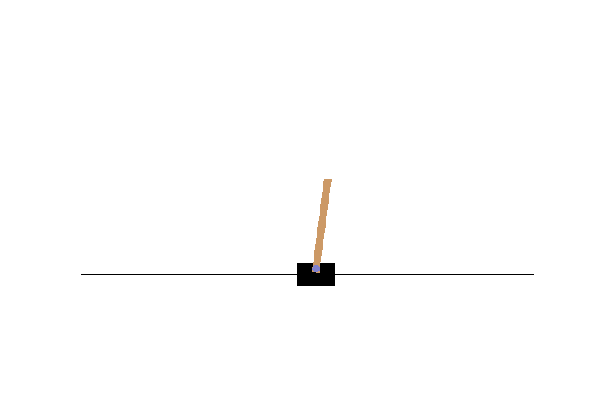
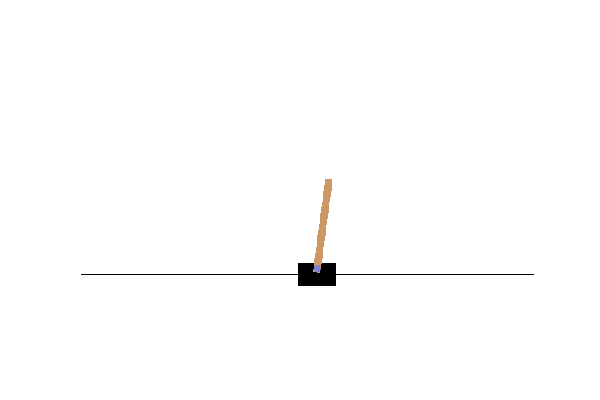
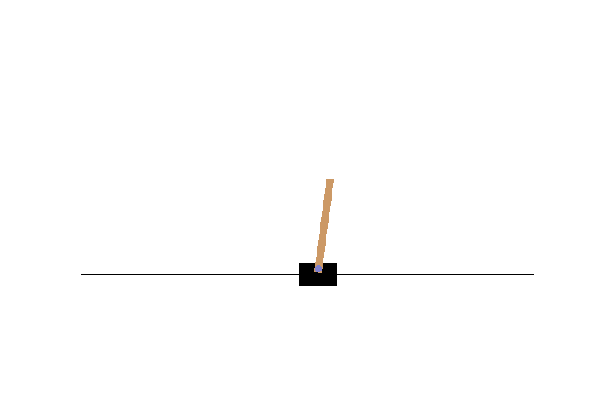
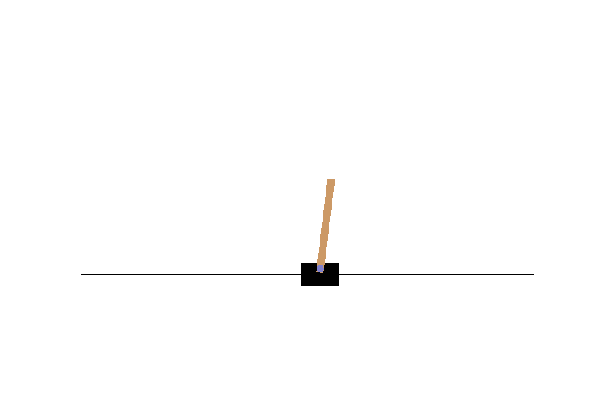
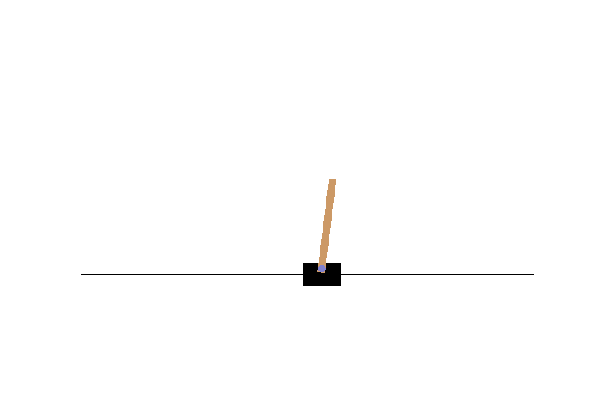
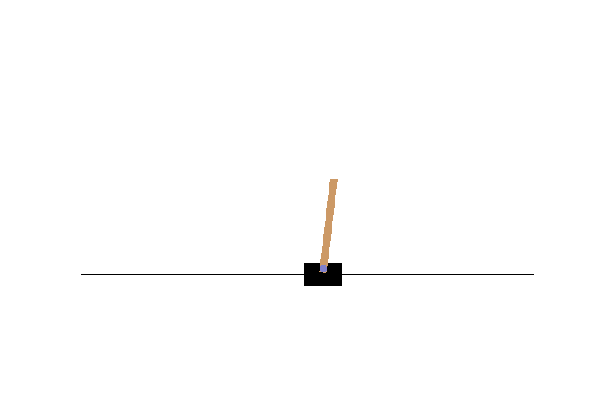
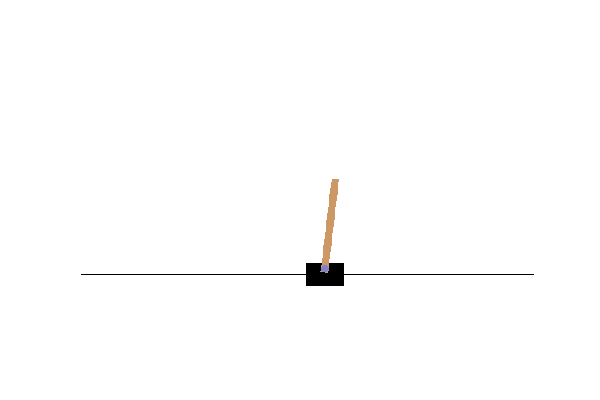
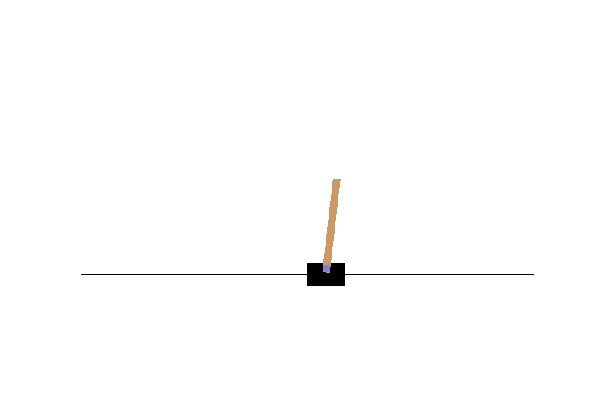
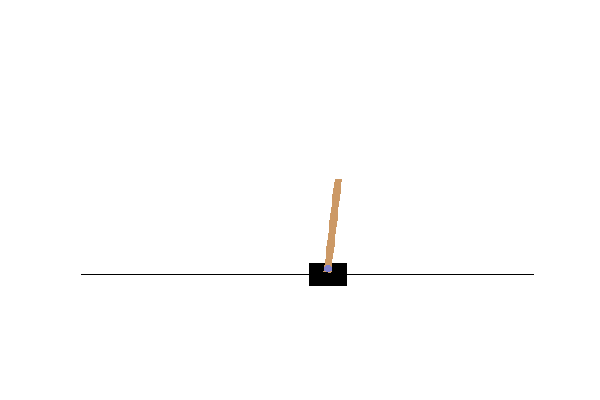
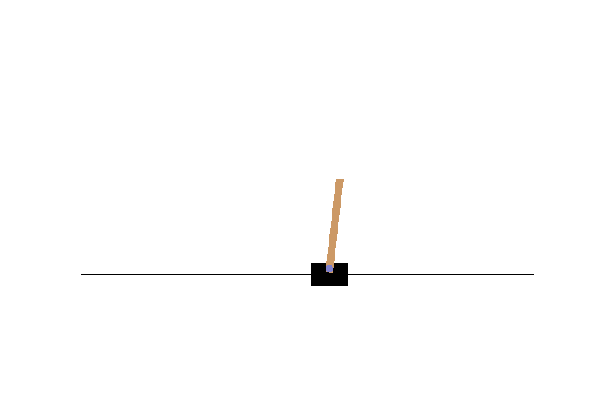
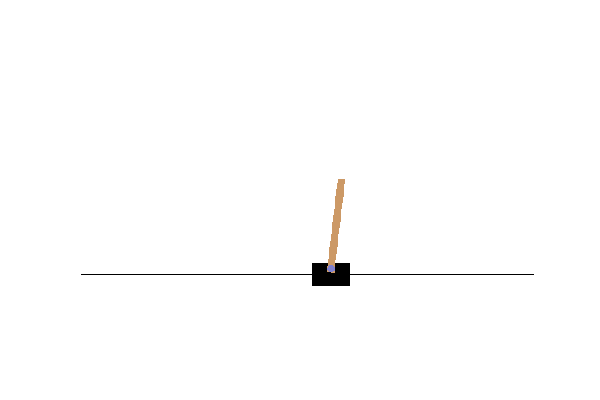
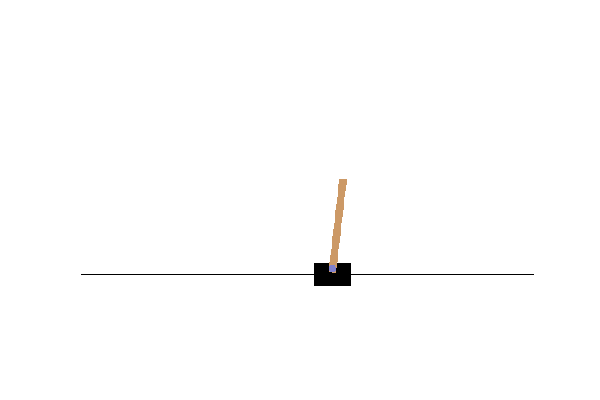
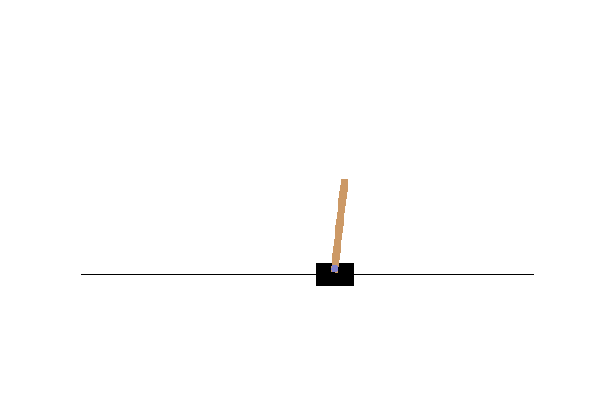
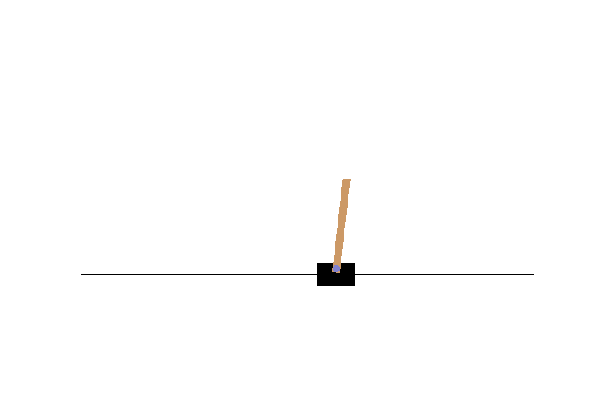
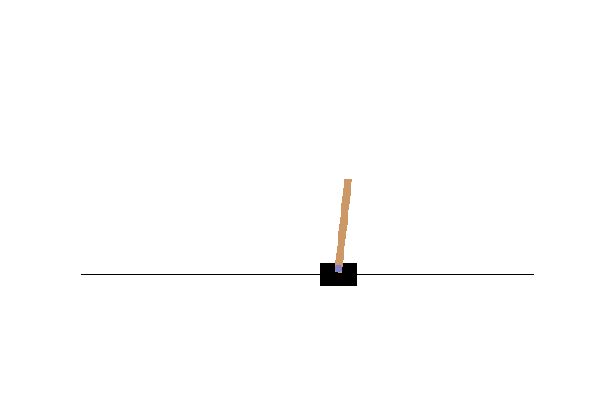
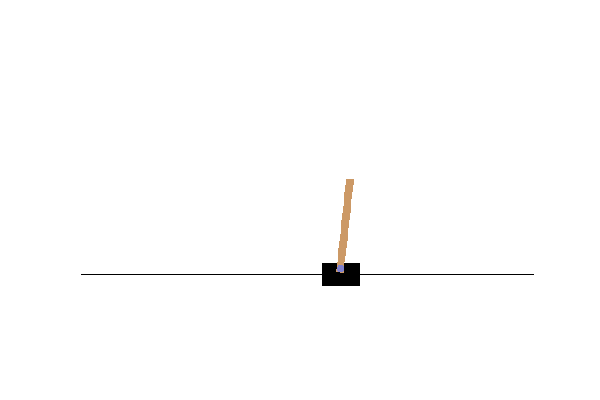
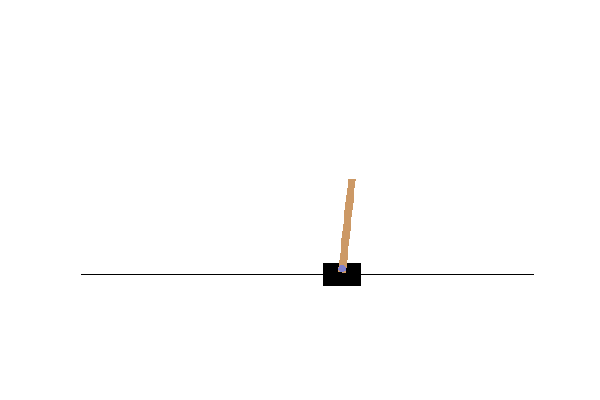
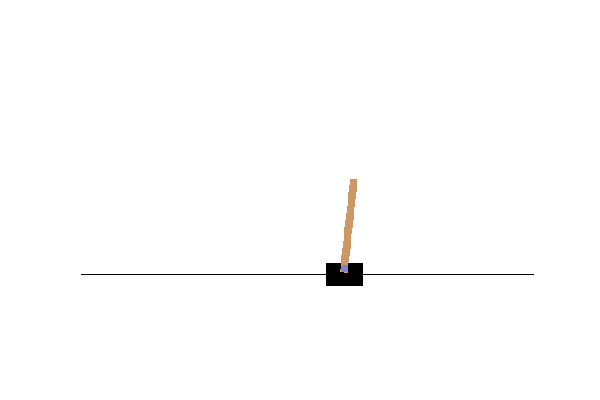
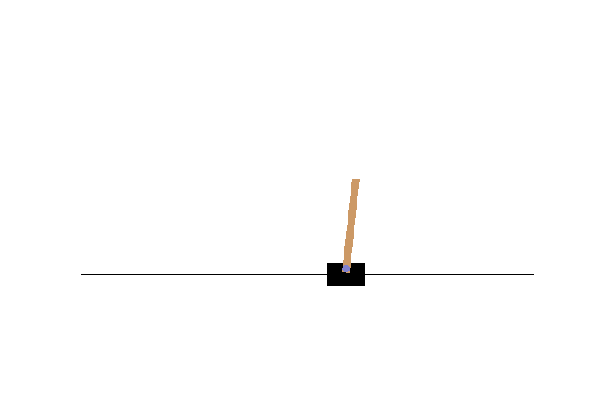
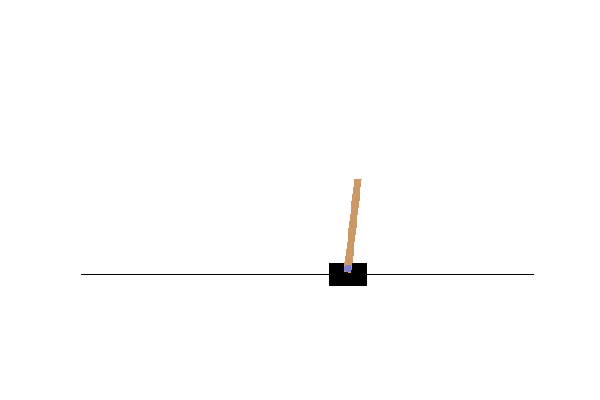
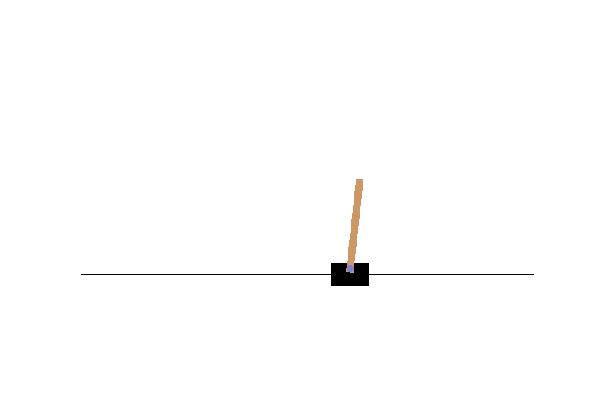
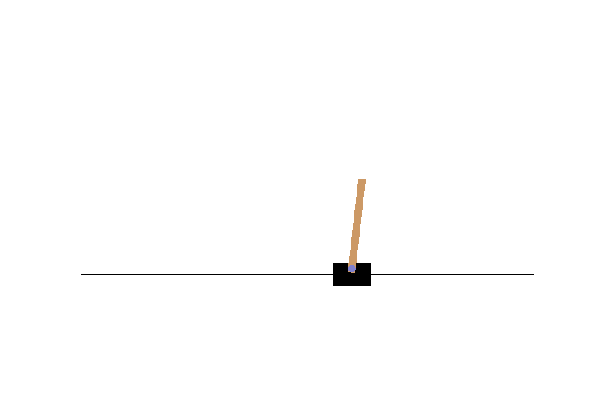
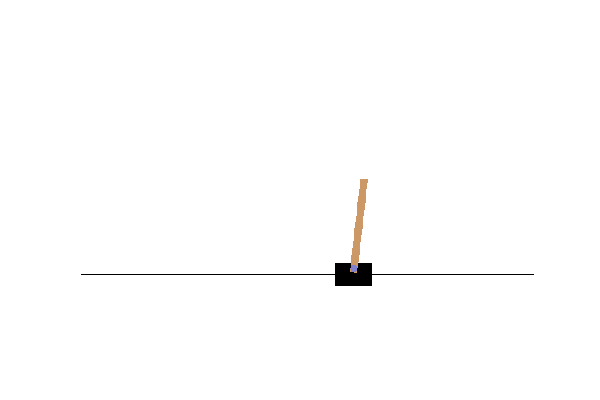
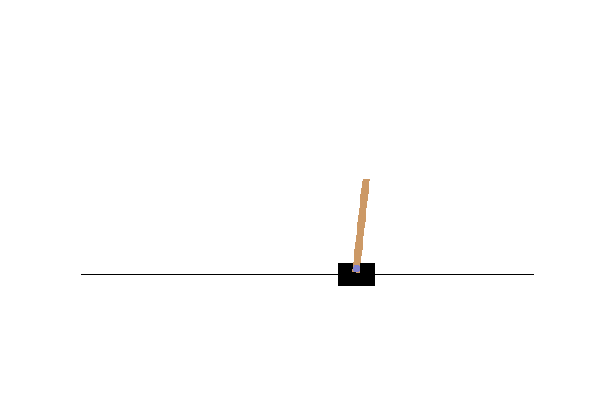
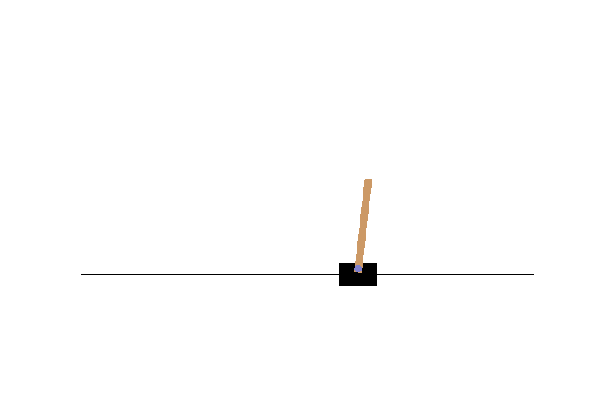
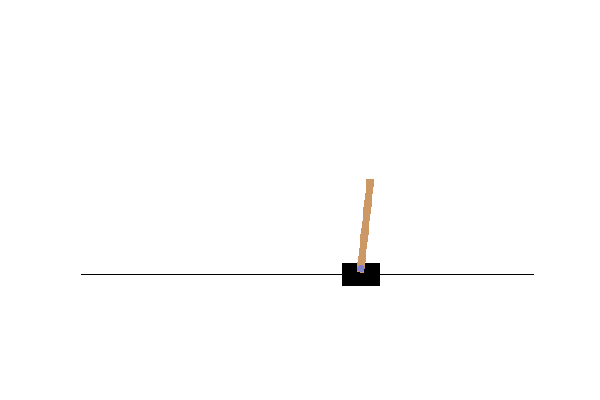
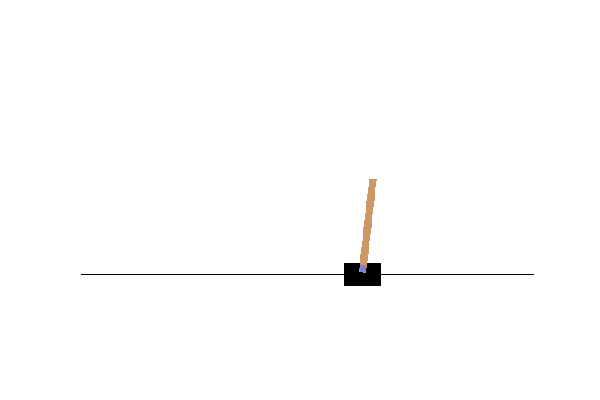
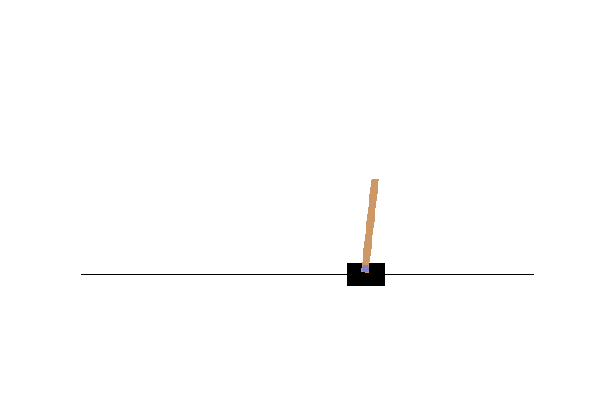
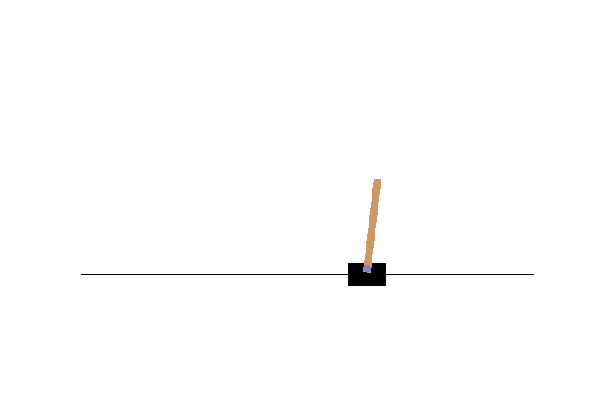
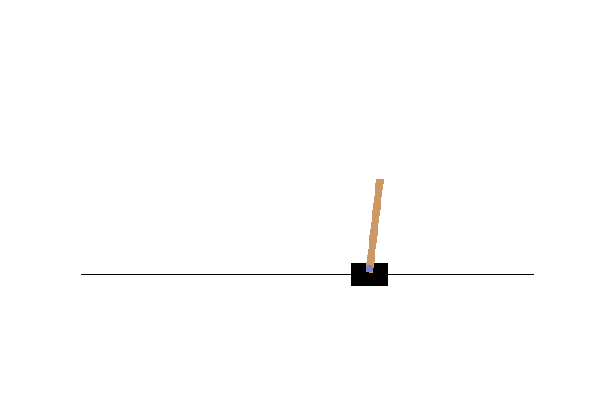
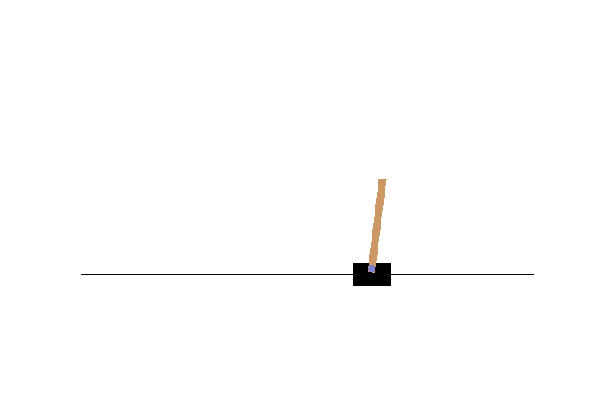
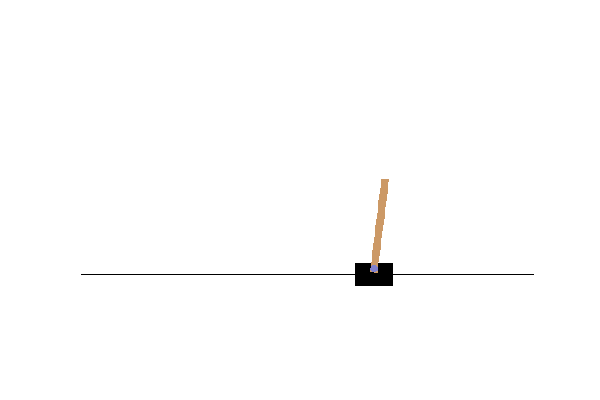
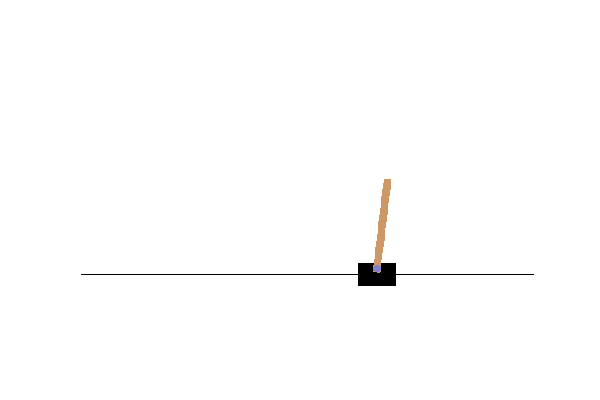
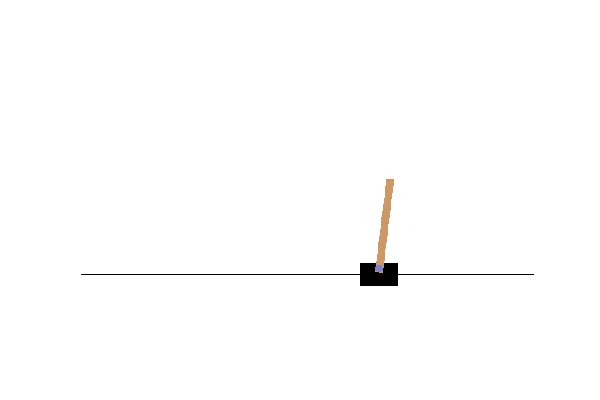
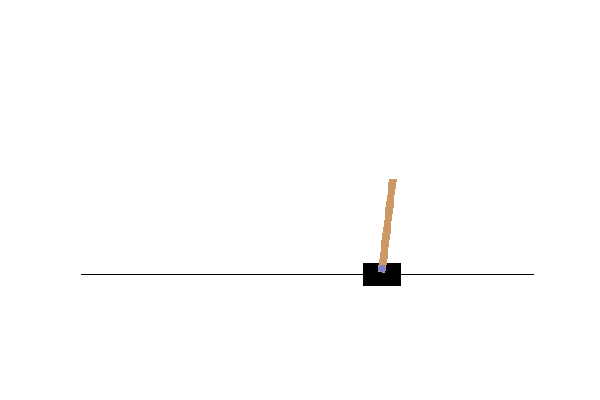
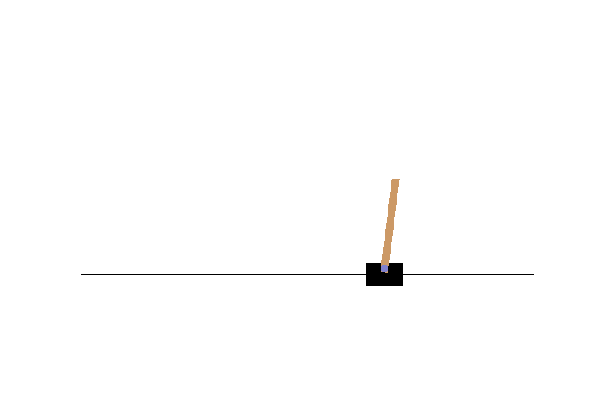
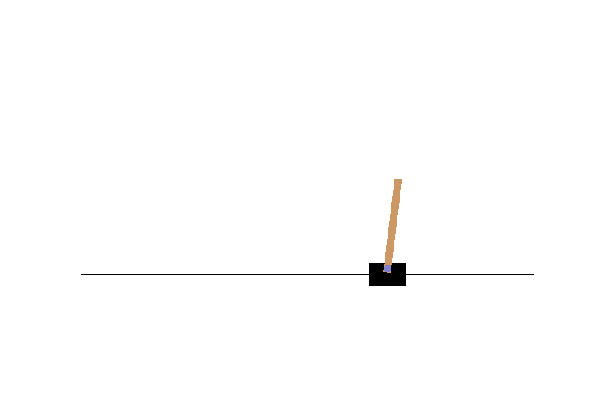
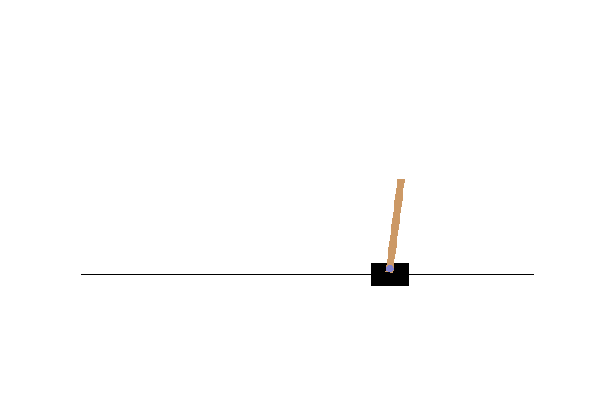
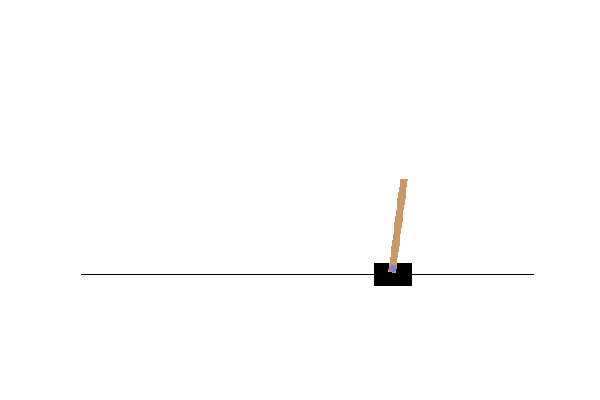
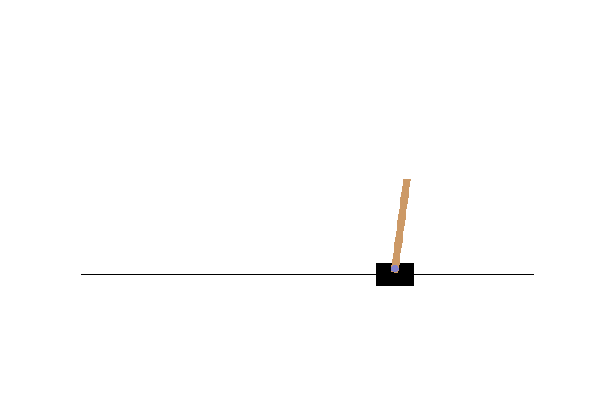
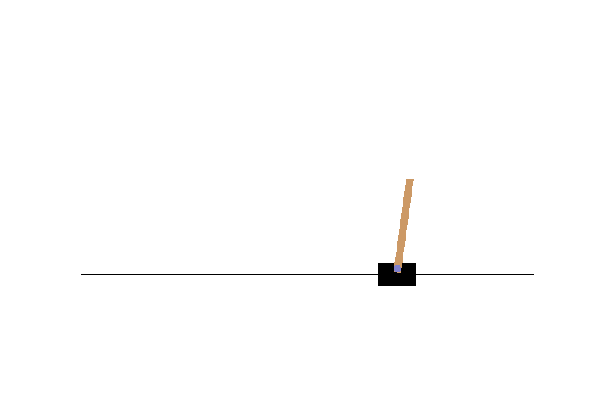
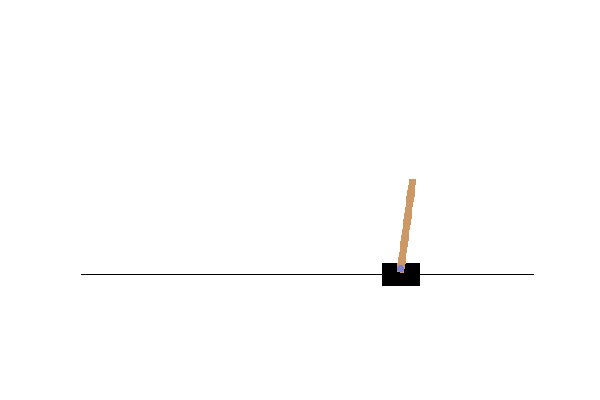
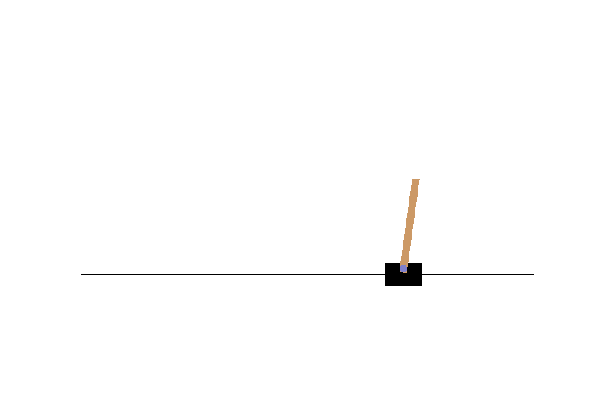
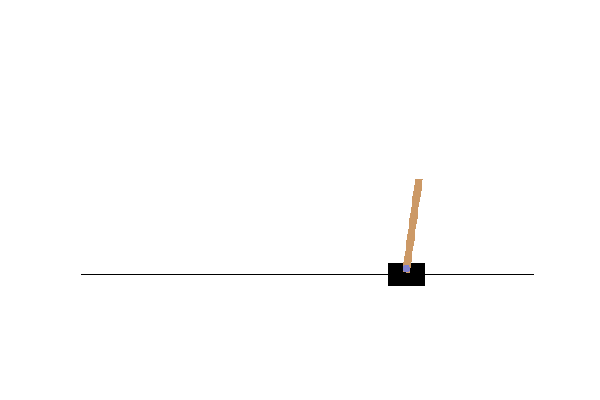
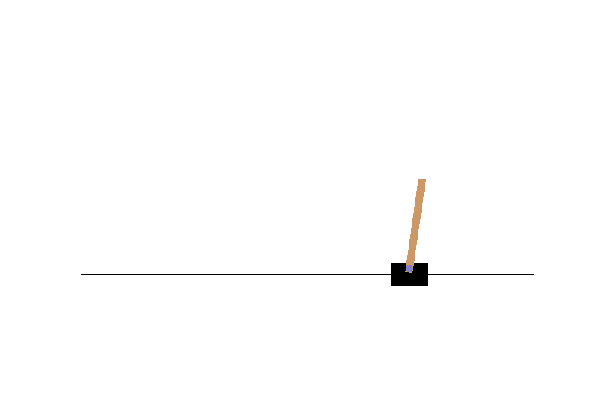
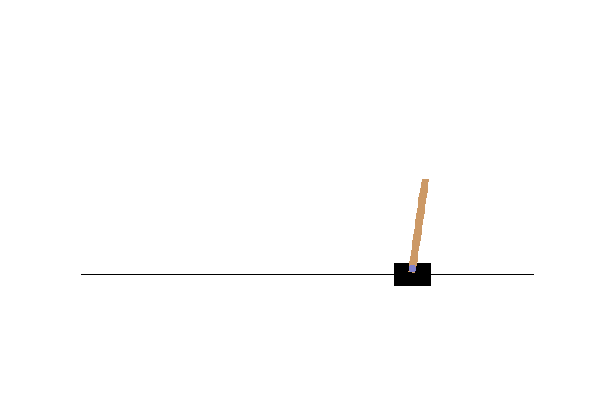
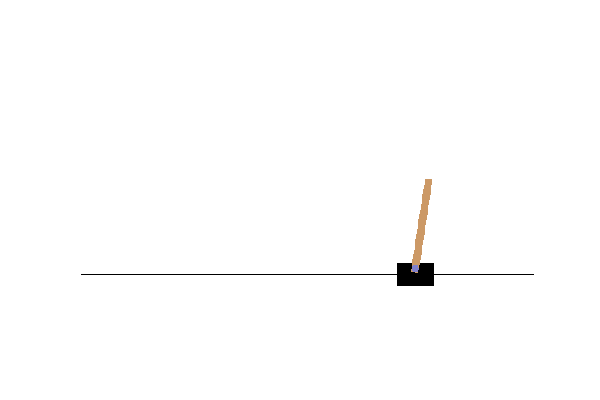
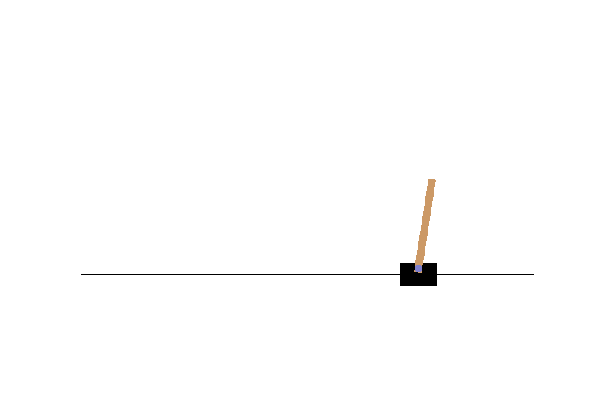
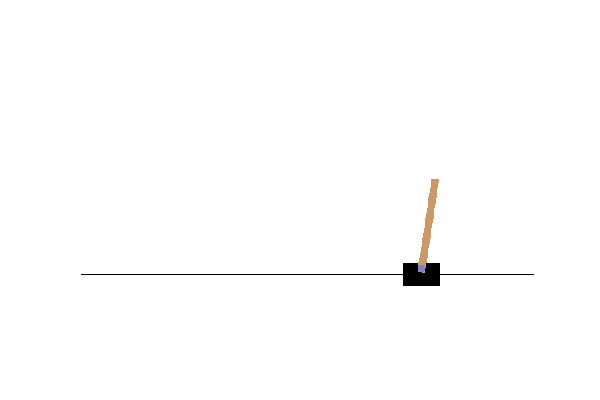
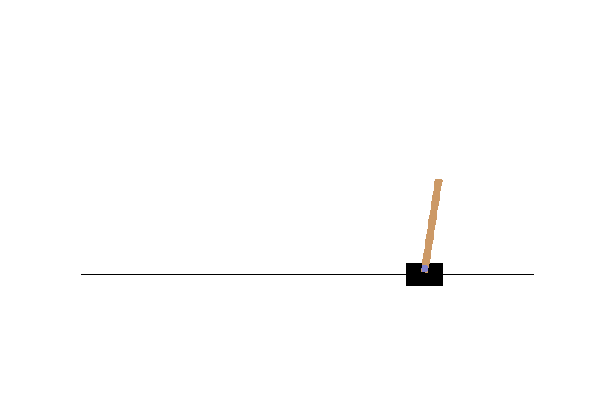
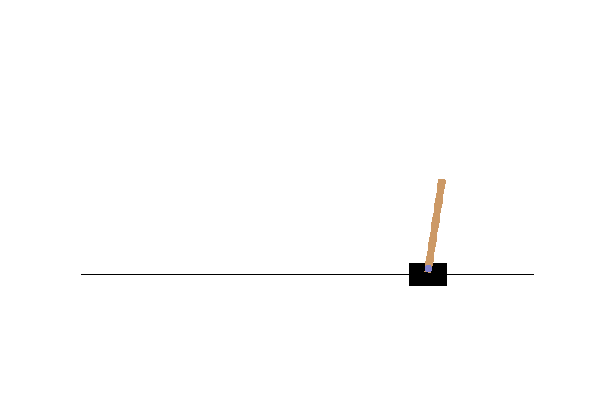
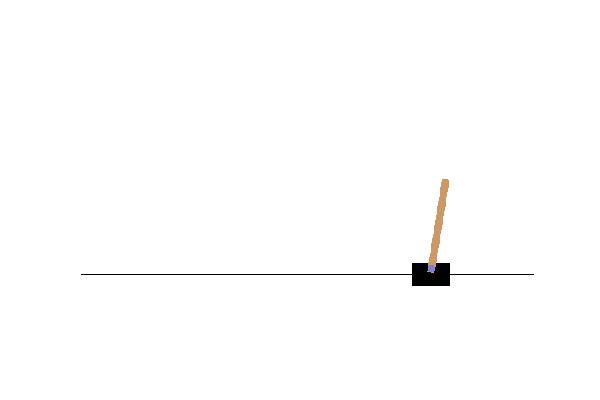
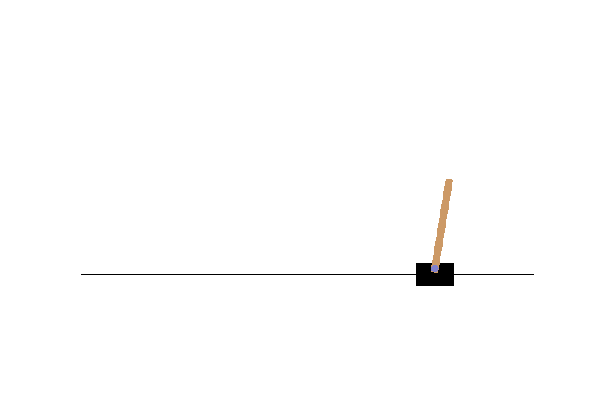
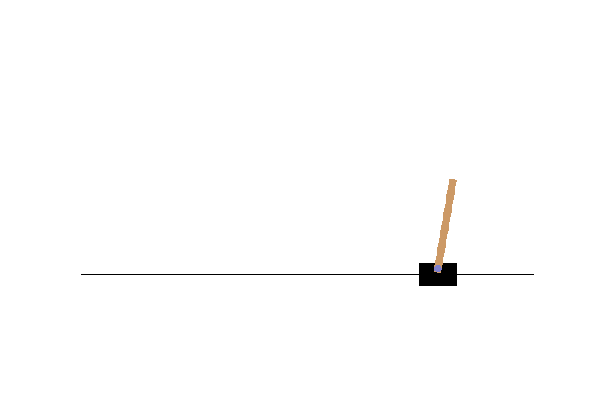
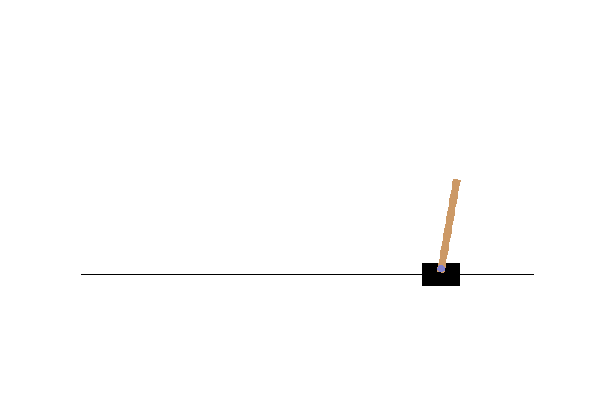
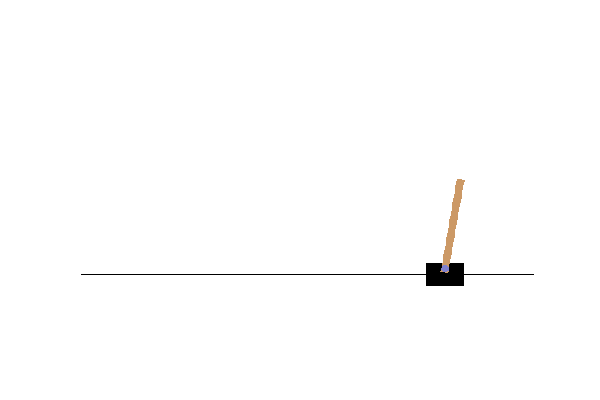
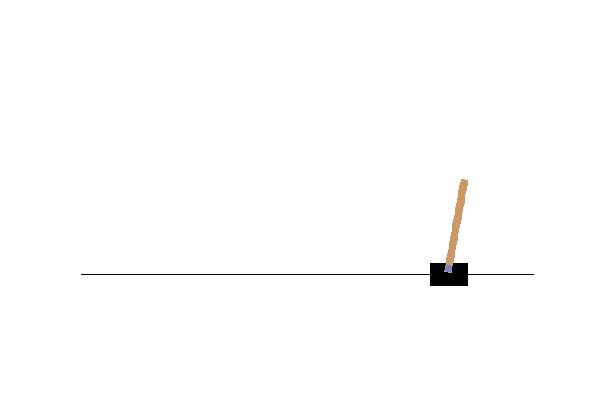
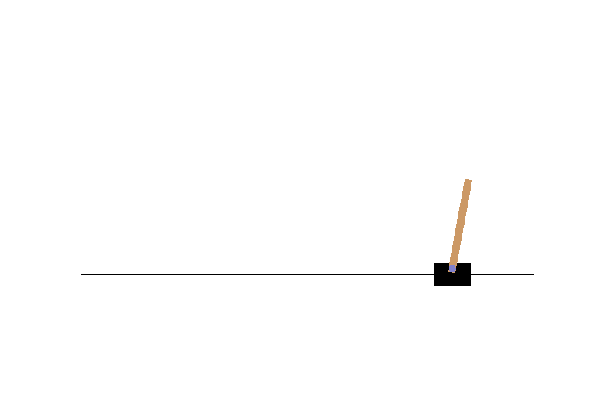
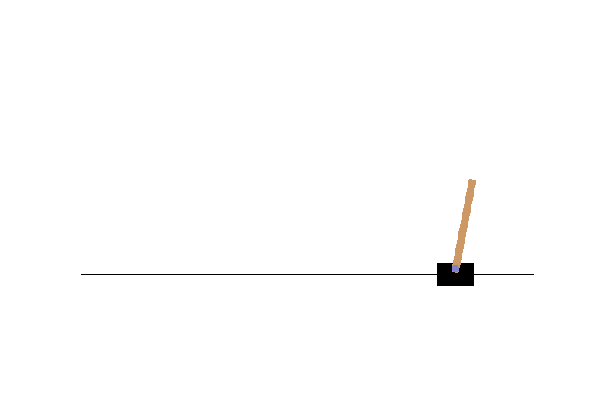
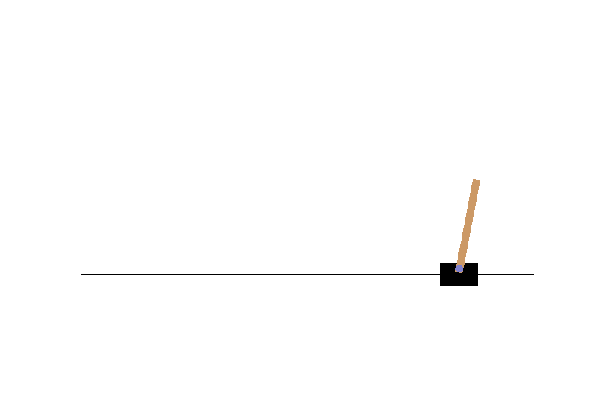
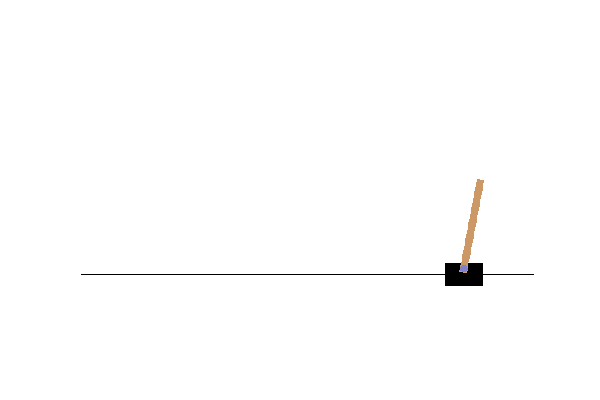
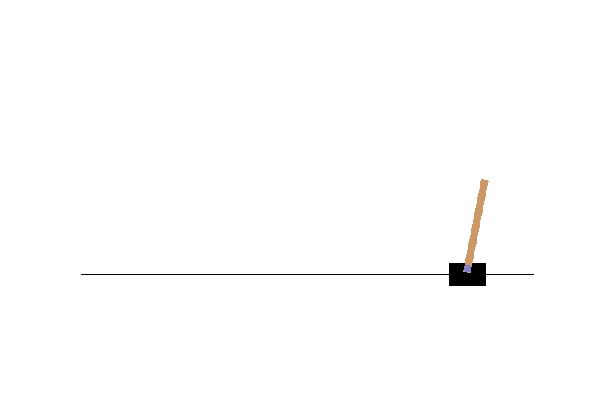
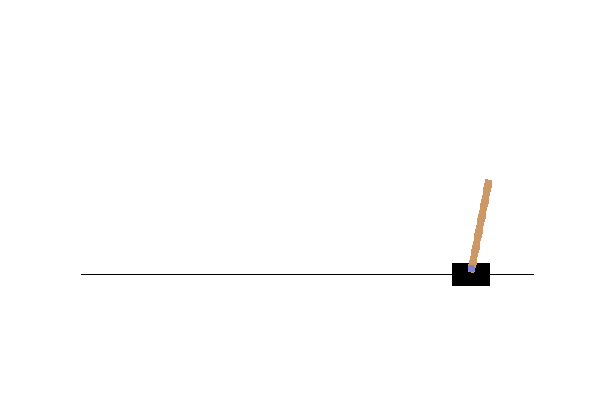
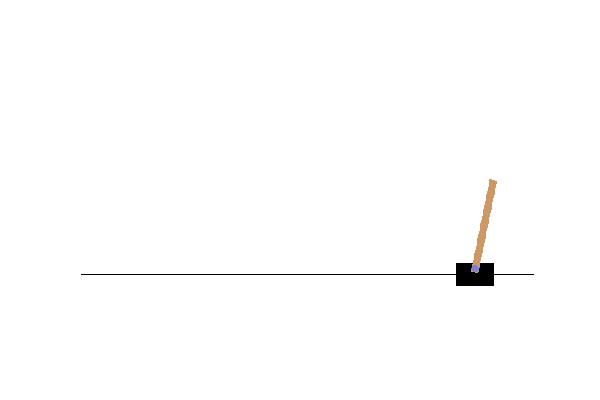
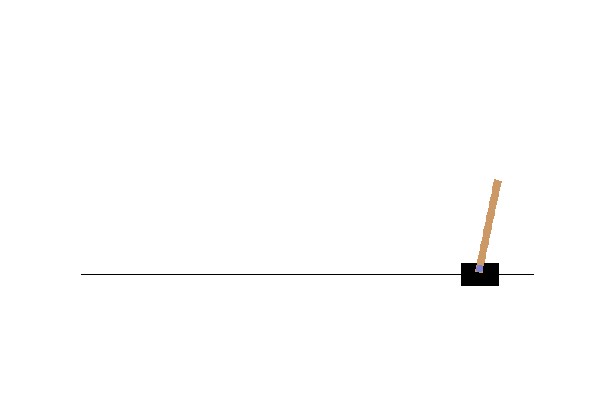
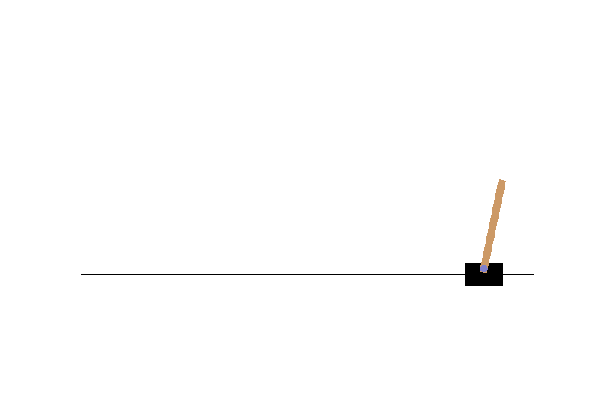
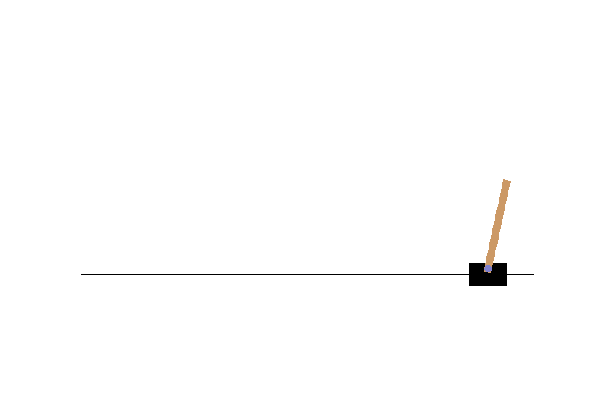
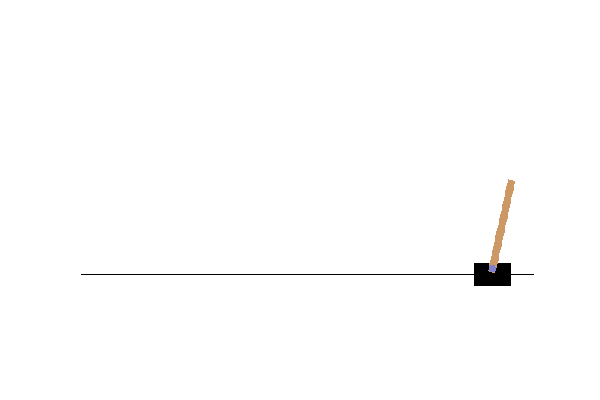
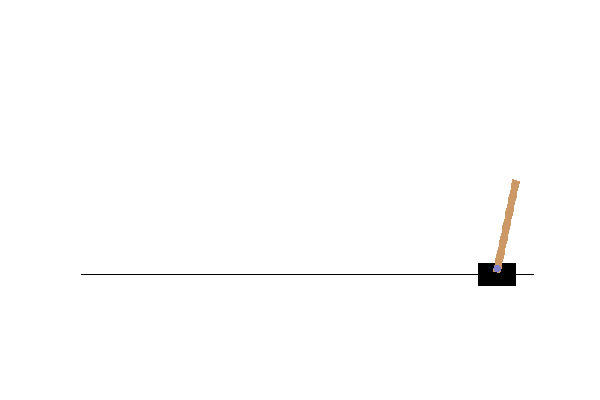
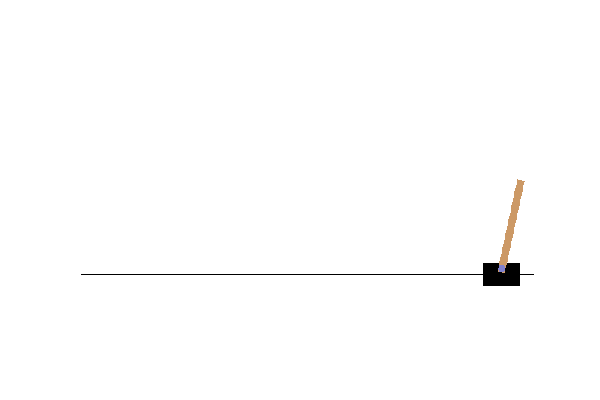
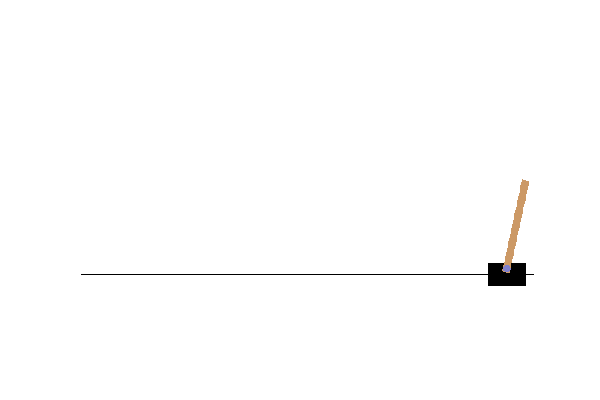
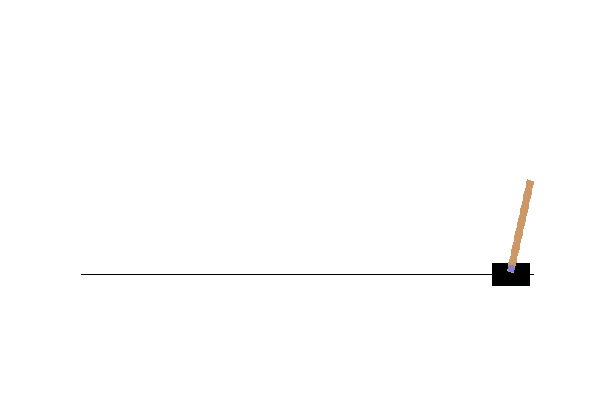
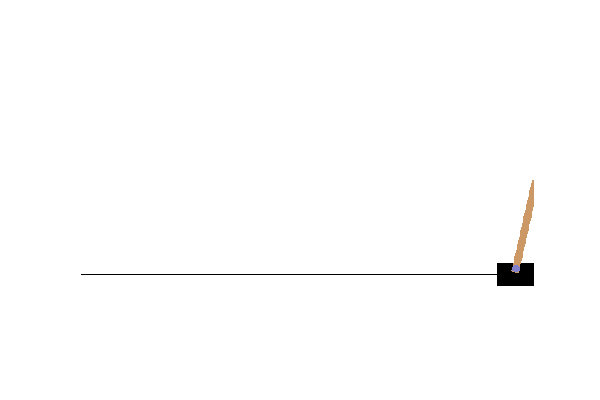

In [14]:
display_frames_as_gif(frames)

### model improves as we try with more episodes.